In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
sys.path.insert(0,"/analysis/fabiane/phd/patch_individual_filters/")

In [4]:
import os
import glob
import h5py
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch.nn.modules.module import Module

# sklearn functions
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GroupShuffleSplit

# load functions from nitorch

from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor, SagittalTranslate, SagittalFlip, \
                                AxialTranslate, normalization_factors, Normalize, \
                                IntensityRescale
from nitorch.callbacks import EarlyStopping, ModelCheckpoint
from nitorch.trainer import Trainer
from nitorch.initialization import weights_init
from nitorch.metrics import balanced_accuracy, sensitivity, specificity, auc_score
from nitorch.utils import count_parameters

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
from pif import PatchIndividualFilters3D

In [6]:
import random
from models_adni import ModelAPIF, ModelBPIF
from hyperparameter_options import params_pif as hyperparams

In [29]:
torch.__version__

'1.0.0'

In [30]:
gpu = 4
multi_gpus = None #[0, 1, 2]
zero_one_normalize = False
dtype = np.float64

In [31]:
# load mask
mask = None

In [32]:
# path to be used for all data sets
train_data_path = "/ritter/share/data/ADNI_HDF5/Splits_Eitel/10xrandom_splits/train_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_random_state"

In [33]:
class ADNIDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None, mask=None, z_factor=None, dtype=np.float32):
        self.X = np.copy(X)
        self.y = np.copy(y)
        self.transform = transform
        self.target_transform = target_transform
        self.mask = mask
        self.z_factor = z_factor
        self.dtype = dtype
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx] >= 0.5
        label = torch.FloatTensor([label])
        
        # normalize by max
        image /= np.max(image)
        
        if self.transform:
            image = self.transform(image)
            
        sample = {"image" : image,
                 "label" : label}
        return sample

In [34]:
augmentations = [SagittalFlip()]

In [35]:
def pick_model(name):
    if name == "ModelA":
        net = ModelA()
    elif name == "ModelB":
        net = ModelB()
    elif name == "ModelAPIF":
        net = ModelAPIF()
    elif name == "ModelBPIF":
        net = ModelBPIF()
    return net

def update_outer_scores(outer_fold_best, report, retain_metric, selected_hyperparams, inner_fold_idx):
    outer_fold_best["final_acc"] = report["val_metrics"][retain_metric][-1]
    outer_fold_best["best_acc"] = np.max(report["val_metrics"][retain_metric][ignore_epochs:])
    outer_fold_best["final_iter"] = len(report["val_metrics"][retain_metric])
    outer_fold_best["best_iter"] = outer_fold_best["final_iter"] - np.argmax(np.flip(np.copy(report["val_metrics"][retain_metric])))
    outer_fold_best["params"] = selected_hyperparams
    outer_fold_best["inner_fold_idx"] = inner_fold_idx
    return outer_fold_best

# Training

In [36]:
def run(
    net,
    data,
    shape,
    callbacks=[],
    augmentations=[],
    masked=False,
    metrics=[],
    k_folds=None,
    b=4,
    num_epochs=35,
    retain_metric=None
):      
   
    fold_metric = []
    all_outer_bests = []
    best_metric = []
    models = []
    fold = 0
    initial_prepend = None
    
    random_states = np.arange(20, 30) # will be used again to split in testing phase
    
    for outer_fold, r in enumerate(random_states):
        print("###### Starting outer fold {}".format(outer_fold))
        # load data sets
        train_h5 = h5py.File(train_data_path + str(r) + ".h5", 'r')
        val_h5 = h5py.File(train_data_path.replace("train", "val") + str(r) + ".h5", 'r')
        
        X_train, y_train = np.array(train_h5['X']), np.array(train_h5['y'])
        X_val, y_val = val_h5['X'], val_h5['y']
    
        # select only 20 % 
        #new_ind, _ = train_test_split(np.arange(len(X_train)), train_size=0.2, random_state=42)
        X_train, _, y_train, _ = train_test_split(X_train, y_train, train_size=0.2, random_state=42)
        #X_train = X_train[new_ind]
        #y_train = y_train[new_ind]

        # dataset overview
        y = np.concatenate([np.array(y_train), np.array(y_val)])
        print("# of patients {}, # of healthy controls {}".format(np.sum(y), len(y)-np.sum(y)))

        print(len(y_train))
        print(len(y_val))
        
        if zero_one_normalize:
            intensity = IntensityRescale(data_min=np.min(X_train), data_max=np.max(X_train)) # use the same min and max for all datasets
            adni_data_train = ADNIDataset(X_train, y_train, transform=transforms.Compose(augmentations + [intensity, ToTensor()]), mask=mask, dtype=dtype)
            adni_data_val = ADNIDataset(X_val, y_val, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
        else:
            adni_data_train = ADNIDataset(X_train, y_train, transform=transforms.Compose(augmentations + [ToTensor()]), mask=mask, dtype=dtype)
            adni_data_val = ADNIDataset(X_val, y_val, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)
        
        train_h5.close()
        val_h5.close()
        
        outer_fold_best = {
            "final_acc" : 0,
            "best_acc" : 0,
            "final_iter" : 0,
            "best_iter" : 0,
            "params" : {},
            "inner_fold_idx" : 0
        }
        
        for inner_fold in range(5):
            print("###### Starting inner fold {}".format(inner_fold))
            # sample randomly from the hyperparameter options each inner fold
            b = random.choice(hyperparams["batch_size"])
            patience = random.choice(hyperparams["patience"]["small"])
            lr = random.choice(hyperparams["lr"])
            
            # force each model architecture to occur twice
            if inner_fold < 2:
                model_name = "ModelAPIF"
            elif inner_fold < 4:
                model_name = "ModelBPIF"
            else:
                # only choose model randomly in the last run
                model_name = random.choice(hyperparams["model"])

            selected_hyperparams = {
                "model" : model_name,
                "batch_size" : b,
                "patience" : patience,
                "lr" : lr
                }
            print(selected_hyperparams)
            
            # load model
            if multi_gpus is None:
                net = pick_model(model_name).cuda(gpu)
            else:
                net = torch.nn.DataParallel(pick_model(model_name), device_ids=multi_gpus).cuda(gpu)
            
            print("Trainable model parameters: {}".format(count_parameters(net)))
        
            callbacks = [EarlyStopping(patience=patience, ignore_before=ignore_epochs, retain_metric="loss", mode='min'),
                         ModelCheckpoint(path=output_dir,
                                         prepend="outer_{}_inner_{}".format(outer_fold, inner_fold),
                                         store_best=True,
                                         ignore_before=ignore_epochs,
                                         retain_metric=retain_metric)]
        
            # add current fold number to model checkpoint path
            if callbacks is not None:
                for idx, callback in enumerate(callbacks):
                    if isinstance(callback, ModelCheckpoint):
                        if initial_prepend is None:
                            initial_prepend = callbacks[idx].prepend
                        callbacks[idx].prepend = initial_prepend + "cv_fold_{}_".format(fold)
                        initial_prepend = None
            fold += 1
            
            # set optimizer
            wd = 1e-4
            criterion = nn.BCEWithLogitsLoss().cuda(gpu)
            optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
            
            train_loader = DataLoader(
            adni_data_train, batch_size=b, num_workers=4, shuffle=True
            )
            val_loader = DataLoader(
                adni_data_val, batch_size=1, num_workers=1, shuffle=True
            )
        
            trainer = Trainer(
                net,
                criterion,
                optimizer,
                metrics=metrics,
                callbacks=callbacks,
                device=gpu
            )
            # train model and store results
            net, report = trainer.train_model(
                train_loader,
                val_loader,
                num_epochs=num_epochs,
                show_train_steps=10,
                show_validation_epochs=1,
            )
            # append validation score of the retain metric
            if isinstance(retain_metric, str):
                # use the average of the last 10 epochs
                best_val = np.mean(report["val_metrics"][retain_metric][-10:])
                fold_metric.append(report["val_metrics"][retain_metric][-1])
                best_metric.append(best_val)
                # replace best model for this outer_fold in case of improvement
                #if report["val_metrics"][retain_metric][-1] > outer_fold_best["final_acc"]:
                if report["val_metrics"][retain_metric][-1] > outer_fold_best["final_acc"]:
                    update_outer_scores(outer_fold_best, report, retain_metric, selected_hyperparams, inner_fold)
            else:
                # use the average of the last 10 epochs
                best_val = np.mean(report["val_metrics"][retain_metric.__name__][-10:])
                fold_metric.append(report["val_metrics"][retain_metric.__name__][-1])
                best_metric.append(best_val)
                # replace best model for this outer_fold in case of improvement
                #if report["val_metrics"][retain_metric.__name__][-1] > outer_fold_best["final_acc"]:
                if best_val > outer_fold_best["final_acc"]:
                    update_outer_scores(outer_fold_best, report, retain_metric.__name__, selected_hyperparams, inner_fold)

            models.append(net)        
            print("Finished inner fold.")

            # visualize result
            trainer.visualize_training(report, metrics)
            trainer.evaluate_model(val_loader, gpu)
        print("Finished outer fold.")
        print(outer_fold_best)
        all_outer_bests.append(outer_fold_best)

    print("################################")
    print("################################")
    print("All accuracies: {}".format(fold_metric))
    print("Best accuracies mean: {} All :{}".format(np.mean(best_metric), best_metric))
    print(all_outer_bests)
    return fold_metric, models


In [37]:
num_epochs = 200
min_iters = 3
ignore_epochs = 25
normalize = False
retain_metric = balanced_accuracy
metrics = [accuracy_score, balanced_accuracy, auc_score]

In [38]:
r = 1

In [39]:
output_dir = "/ritter/share/projects/Methods/Eitel_local_filter/experiments_submission/models/ADNI/20_percent/10xrandom_splits/experiment/"
callbacks = [EarlyStopping(patience=12, ignore_before=ignore_epochs, retain_metric="loss", mode='min'),
             ModelCheckpoint(path=output_dir,
                             prepend="repeat_{}".format(r),
                             store_best=True,
                             ignore_before=ignore_epochs,
                             retain_metric=retain_metric)]

###### Starting outer fold 0


/home/fabiane/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


# of patients 128, # of healthy controls 118
139
107
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 259131
[0,    10] loss: 0.68864
Time elapsed: 0h:0m:2s
train accuracy_score: 56.83 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.701620
[1,    10] loss: 0.68396
Time elapsed: 0h:0m:5s
train accuracy_score: 56.83 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.707758
[2,    10] loss: 0.68805
Time elapsed: 0h:0m:9s
train accuracy_score: 56.83 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.706372
[3,    10] loss: 0.67948
Time elapsed: 0h:0m:13s
train accuracy_score: 56.83 %
train balanced_accuracy

val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.703534
[34,    10] loss: 0.67998
Time elapsed: 0h:2m:14s
train accuracy_score: 57.55 %
train balanced_accuracy: 51.03 %
train auc_score: 51.03 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.702136
[35,    10] loss: 0.66469
Time elapsed: 0h:2m:17s
train accuracy_score: 57.55 %
train balanced_accuracy: 51.03 %
train auc_score: 51.03 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.697178
[36,    10] loss: 0.66635
Time elapsed: 0h:2m:21s
train accuracy_score: 58.99 %
train balanced_accuracy: 54.91 %
train auc_score: 54.91 %
val accuracy_score: 66.36 %
val balanced_accuracy: 68.17 %
val auc_score: 68.17 %
Val loss: 0.680025
[37,    10] loss: 0.67092
Time elapsed: 0h:2m:25s
train accuracy_score: 58.99 %
train balanced_accuracy: 54.91 %
train auc_score: 54.91 %
val accuracy_score: 45.79 %
val balanced_acc

[68,    10] loss: 0.61259
Time elapsed: 0h:4m:27s
train accuracy_score: 66.19 %
train balanced_accuracy: 62.84 %
train auc_score: 62.84 %
val accuracy_score: 66.36 %
val balanced_accuracy: 65.32 %
val auc_score: 65.32 %
Val loss: 0.631321
[69,    10] loss: 0.59992
Time elapsed: 0h:4m:31s
train accuracy_score: 69.78 %
train balanced_accuracy: 67.81 %
train auc_score: 67.81 %
val accuracy_score: 71.03 %
val balanced_accuracy: 72.01 %
val auc_score: 72.01 %
Val loss: 0.636288
[70,    10] loss: 0.62172
Time elapsed: 0h:4m:35s
train accuracy_score: 69.06 %
train balanced_accuracy: 66.57 %
train auc_score: 66.57 %
val accuracy_score: 72.90 %
val balanced_accuracy: 73.26 %
val auc_score: 73.26 %
Val loss: 0.627251
[71,    10] loss: 0.59515
Time elapsed: 0h:4m:39s
train accuracy_score: 65.47 %
train balanced_accuracy: 64.01 %
train auc_score: 64.01 %
val accuracy_score: 72.90 %
val balanced_accuracy: 73.73 %
val auc_score: 73.73 %
Val loss: 0.624991
[72,    10] loss: 0.62897
Time elapsed: 0h:4

val accuracy_score: 73.83 %
val balanced_accuracy: 74.75 %
val auc_score: 74.75 %
Val loss: 0.574415
[103,    10] loss: 0.47390
Time elapsed: 0h:6m:45s
train accuracy_score: 71.94 %
train balanced_accuracy: 71.31 %
train auc_score: 71.31 %
val accuracy_score: 77.57 %
val balanced_accuracy: 77.73 %
val auc_score: 77.73 %
Val loss: 0.540844
[104,    10] loss: 0.44242
Time elapsed: 0h:6m:49s
train accuracy_score: 75.54 %
train balanced_accuracy: 75.07 %
train auc_score: 75.07 %
val accuracy_score: 76.64 %
val balanced_accuracy: 77.34 %
val auc_score: 77.34 %
Val loss: 0.555865
[105,    10] loss: 0.45915
Time elapsed: 0h:6m:53s
train accuracy_score: 76.26 %
train balanced_accuracy: 75.51 %
train auc_score: 75.51 %
val accuracy_score: 70.09 %
val balanced_accuracy: 72.10 %
val auc_score: 72.10 %
Val loss: 0.651884
[106,    10] loss: 0.46445
Time elapsed: 0h:6m:57s
train accuracy_score: 77.70 %
train balanced_accuracy: 77.97 %
train auc_score: 77.97 %
val accuracy_score: 75.70 %
val balanced

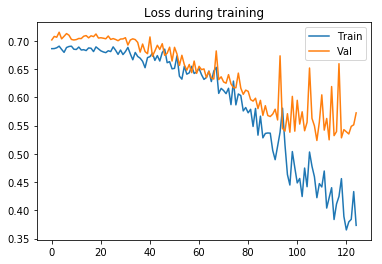

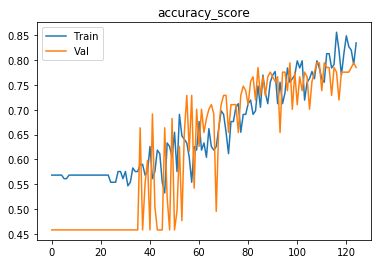

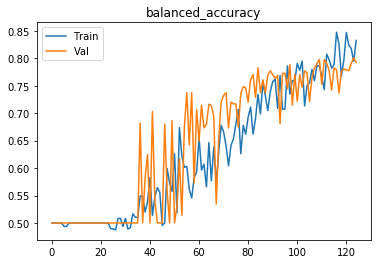

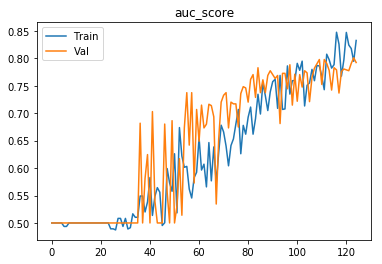

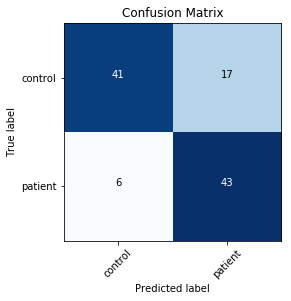

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 259131
[0,    10] loss: 0.69356
[0,    20] loss: 0.68154
Time elapsed: 0h:0m:2s
train accuracy_score: 56.83 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.702415
[1,    10] loss: 0.69335
[1,    20] loss: 0.67765
Time elapsed: 0h:0m:6s
train accuracy_score: 56.83 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.706632
[2,    10] loss: 0.69611
[2,    20] loss: 0.68244
Time elapsed: 0h:0m:10s
train accuracy_score: 56.83 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.702894
[3,    10] loss: 0.69239
[3,    20] loss: 0.67989
Time elapsed: 0h:0m:15s
train

val accuracy_score: 75.70 %
val balanced_accuracy: 74.74 %
val auc_score: 74.74 %
Val loss: 0.523402
[31,    10] loss: 0.53572
[31,    20] loss: 0.49322
Time elapsed: 0h:2m:15s
train accuracy_score: 72.66 %
train balanced_accuracy: 72.54 %
train auc_score: 72.54 %
val accuracy_score: 78.50 %
val balanced_accuracy: 78.11 %
val auc_score: 78.11 %
Val loss: 0.526327
[32,    10] loss: 0.47796
[32,    20] loss: 0.45624
Time elapsed: 0h:2m:20s
train accuracy_score: 79.86 %
train balanced_accuracy: 79.67 %
train auc_score: 79.67 %
val accuracy_score: 77.57 %
val balanced_accuracy: 76.78 %
val auc_score: 76.78 %
Val loss: 0.523279
[33,    10] loss: 0.57551
[33,    20] loss: 0.42182
Time elapsed: 0h:2m:24s
train accuracy_score: 72.66 %
train balanced_accuracy: 71.74 %
train auc_score: 71.74 %
val accuracy_score: 81.31 %
val balanced_accuracy: 81.18 %
val auc_score: 81.18 %
Val loss: 0.532196
[34,    10] loss: 0.36672
[34,    20] loss: 0.53540
Time elapsed: 0h:2m:28s
train accuracy_score: 84.89 

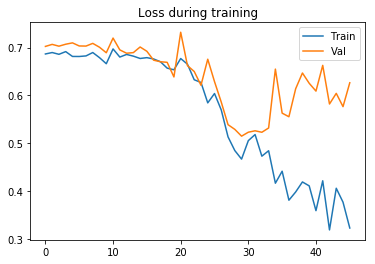

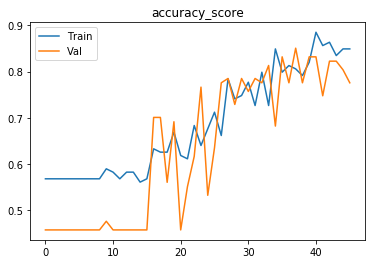

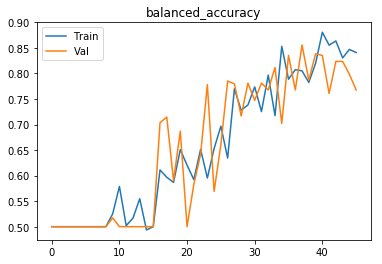

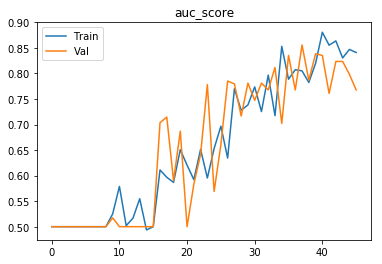

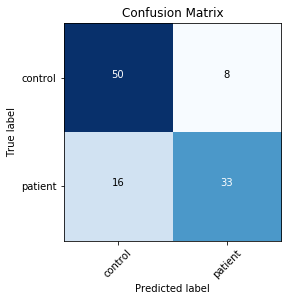

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 519979
[0,    10] loss: 0.69330
[0,    20] loss: 0.68688
Time elapsed: 0h:0m:4s
train accuracy_score: 53.96 %
train balanced_accuracy: 50.47 %
train auc_score: 50.47 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.708557
[1,    10] loss: 0.68806
[1,    20] loss: 0.70530
Time elapsed: 0h:0m:11s
train accuracy_score: 49.64 %
train balanced_accuracy: 44.27 %
train auc_score: 44.27 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.695312
[2,    10] loss: 0.69132
[2,    20] loss: 0.67827
Time elapsed: 0h:0m:17s
train accuracy_score: 56.83 %
train balanced_accuracy: 51.00 %
train auc_score: 51.00 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.707713
[3,    10] loss: 0.69230
[3,    20] loss: 0.68662
Time elapsed: 0h:0m:24s
train

val accuracy_score: 80.37 %
val balanced_accuracy: 80.00 %
val auc_score: 80.00 %
Val loss: 0.619459
[31,    10] loss: 0.62684
[31,    20] loss: 0.57093
Time elapsed: 0h:3m:30s
train accuracy_score: 69.78 %
train balanced_accuracy: 68.01 %
train auc_score: 68.01 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.684001
[32,    10] loss: 0.61789
[32,    20] loss: 0.61554
Time elapsed: 0h:3m:37s
train accuracy_score: 64.75 %
train balanced_accuracy: 62.37 %
train auc_score: 62.37 %
val accuracy_score: 70.09 %
val balanced_accuracy: 72.41 %
val auc_score: 72.41 %
Val loss: 0.599240
[33,    10] loss: 0.53187
[33,    20] loss: 0.51507
Time elapsed: 0h:3m:44s
train accuracy_score: 76.26 %
train balanced_accuracy: 74.30 %
train auc_score: 74.30 %
val accuracy_score: 77.57 %
val balanced_accuracy: 76.94 %
val auc_score: 76.94 %
Val loss: 0.491223
[34,    10] loss: 0.57029
[34,    20] loss: 0.46591
Time elapsed: 0h:3m:51s
train accuracy_score: 71.22 

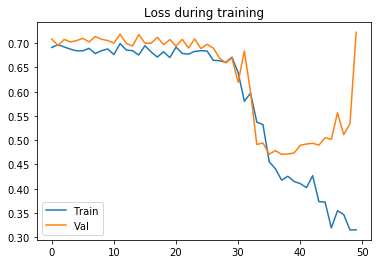

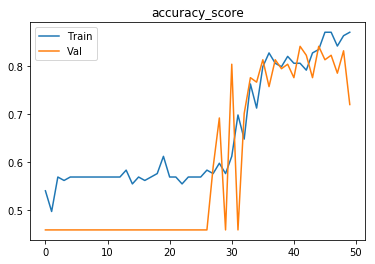

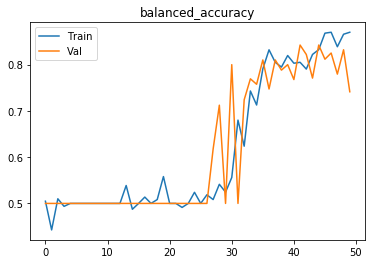

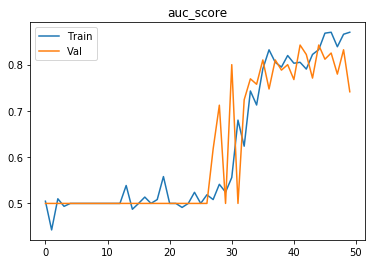

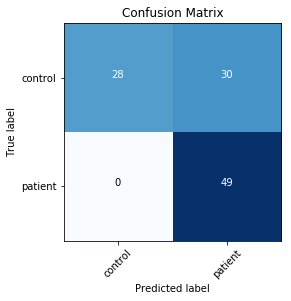

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 519979
[0,    10] loss: 0.68369
Time elapsed: 0h:0m:4s
train accuracy_score: 56.83 %
train balanced_accuracy: 50.40 %
train auc_score: 50.40 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.737247
[1,    10] loss: 0.70161
Time elapsed: 0h:0m:10s
train accuracy_score: 56.12 %
train balanced_accuracy: 49.37 %
train auc_score: 49.37 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.704242
[2,    10] loss: 0.69037
Time elapsed: 0h:0m:17s
train accuracy_score: 56.83 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.711536
[3,    10] loss: 0.68438
Time elapsed: 0h:0m:23s
train accuracy_score: 56.83 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_sc

[34,    10] loss: 0.44507
Time elapsed: 0h:3m:41s
train accuracy_score: 80.58 %
train balanced_accuracy: 80.11 %
train auc_score: 80.11 %
val accuracy_score: 83.18 %
val balanced_accuracy: 83.37 %
val auc_score: 83.37 %
Val loss: 0.531639
[35,    10] loss: 0.37720
Time elapsed: 0h:3m:47s
train accuracy_score: 86.33 %
train balanced_accuracy: 85.57 %
train auc_score: 85.57 %
val accuracy_score: 70.09 %
val balanced_accuracy: 71.62 %
val auc_score: 71.62 %
Val loss: 0.641133
[36,    10] loss: 0.37829
Time elapsed: 0h:3m:54s
train accuracy_score: 84.17 %
train balanced_accuracy: 84.47 %
train auc_score: 84.47 %
val accuracy_score: 76.64 %
val balanced_accuracy: 77.66 %
val auc_score: 77.66 %
Val loss: 0.617230
[37,    10] loss: 0.32877
Time elapsed: 0h:4m:0s
train accuracy_score: 87.05 %
train balanced_accuracy: 86.20 %
train auc_score: 86.20 %
val accuracy_score: 83.18 %
val balanced_accuracy: 83.22 %
val auc_score: 83.22 %
Val loss: 0.557106
[38,    10] loss: 0.36343
Time elapsed: 0h:4m

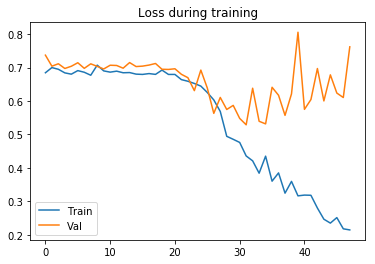

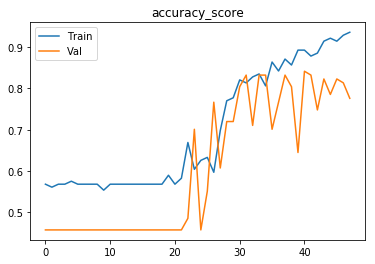

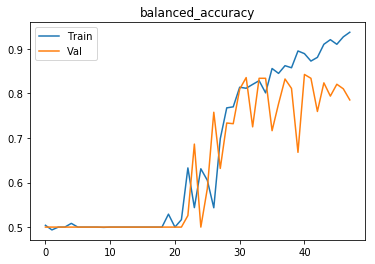

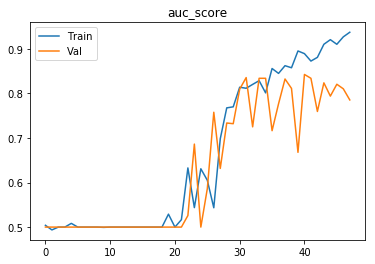

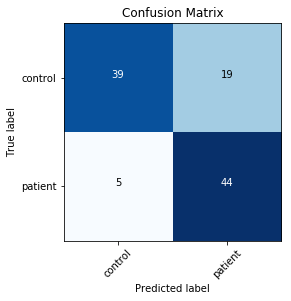

###### Starting inner fold 4
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 259131
[0,    10] loss: 0.69590
Time elapsed: 0h:0m:2s
train accuracy_score: 53.24 %
train balanced_accuracy: 48.04 %
train auc_score: 48.04 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.704754
[1,    10] loss: 0.69149
Time elapsed: 0h:0m:6s
train accuracy_score: 56.83 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.702522
[2,    10] loss: 0.68784
Time elapsed: 0h:0m:9s
train accuracy_score: 57.55 %
train balanced_accuracy: 50.83 %
train auc_score: 50.83 %
val accuracy_score: 45.79 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.704795
[3,    10] loss: 0.70048
Time elapsed: 0h:0m:13s
train accuracy_score: 56.12 %
train balanced_accuracy: 49.37 %
train auc_score: 49.37 %
val accuracy_scor

[34,    10] loss: 0.61495
Time elapsed: 0h:2m:17s
train accuracy_score: 62.59 %
train balanced_accuracy: 58.27 %
train auc_score: 58.27 %
val accuracy_score: 76.64 %
val balanced_accuracy: 77.02 %
val auc_score: 77.02 %
Val loss: 0.600438
[35,    10] loss: 0.61319
Time elapsed: 0h:2m:20s
train accuracy_score: 65.47 %
train balanced_accuracy: 67.22 %
train auc_score: 67.22 %
val accuracy_score: 70.09 %
val balanced_accuracy: 71.94 %
val auc_score: 71.94 %
Val loss: 0.609692
[36,    10] loss: 0.61692
Time elapsed: 0h:2m:24s
train accuracy_score: 64.03 %
train balanced_accuracy: 59.94 %
train auc_score: 59.94 %
val accuracy_score: 74.77 %
val balanced_accuracy: 75.93 %
val auc_score: 75.93 %
Val loss: 0.595270
[37,    10] loss: 0.55875
Time elapsed: 0h:2m:28s
train accuracy_score: 74.82 %
train balanced_accuracy: 73.84 %
train auc_score: 73.84 %
val accuracy_score: 69.16 %
val balanced_accuracy: 71.08 %
val auc_score: 71.08 %
Val loss: 0.594021
[38,    10] loss: 0.55868
Time elapsed: 0h:2

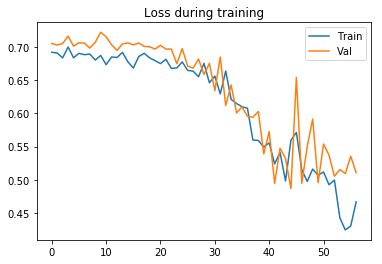

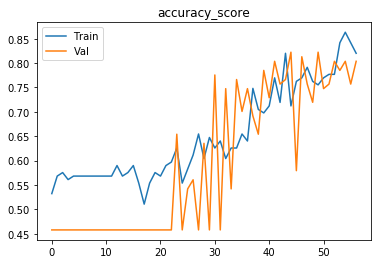

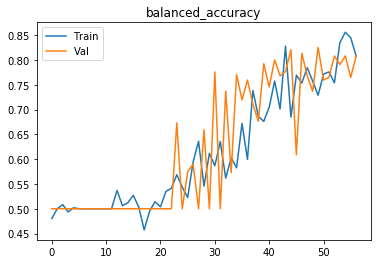

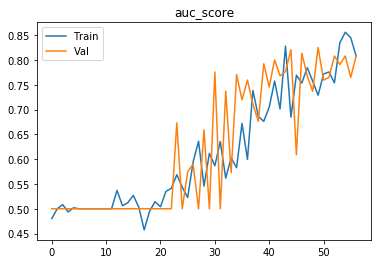

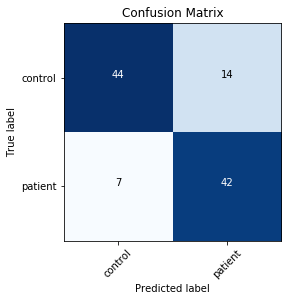

Finished outer fold.
{'final_acc': 0.7851864883884588, 'best_acc': 0.8423645320197044, 'final_iter': 48, 'best_iter': 41, 'params': {'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 3}
###### Starting outer fold 1
# of patients 109, # of healthy controls 125
139
95
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 259131
[0,    10] loss: 0.69285
[0,    20] loss: 0.69586
[0,    30] loss: 0.69584
Time elapsed: 0h:0m:3s
train accuracy_score: 48.92 %
train balanced_accuracy: 49.23 %
train auc_score: 49.23 %
val accuracy_score: 42.11 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.694590
[1,    10] loss: 0.69577
[1,    20] loss: 0.69281
[1,    30] loss: 0.69160
Time elapsed: 0h:0m:7s
train accuracy_score: 48.92 %
train balanced_accuracy: 49.12 %
train auc_score: 49.12 %
val accuracy_score: 42.11 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val lo

[27,    10] loss: 0.69223
[27,    20] loss: 0.68846
[27,    30] loss: 0.69449
Time elapsed: 0h:2m:6s
train accuracy_score: 49.64 %
train balanced_accuracy: 49.52 %
train auc_score: 49.52 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.688266
[28,    10] loss: 0.69188
[28,    20] loss: 0.68964
[28,    30] loss: 0.69346
Time elapsed: 0h:2m:11s
train accuracy_score: 51.80 %
train balanced_accuracy: 51.71 %
train auc_score: 51.71 %
val accuracy_score: 65.26 %
val balanced_accuracy: 59.09 %
val auc_score: 59.09 %
Val loss: 0.689849
[29,    10] loss: 0.69017
[29,    20] loss: 0.69185
[29,    30] loss: 0.69329
Time elapsed: 0h:2m:15s
train accuracy_score: 54.68 %
train balanced_accuracy: 54.66 %
train auc_score: 54.66 %
val accuracy_score: 72.63 %
val balanced_accuracy: 68.52 %
val auc_score: 68.52 %
Val loss: 0.690340
[30,    10] loss: 0.69308
[30,    20] loss: 0.68995
[30,    30] loss: 0.69118
Time elapsed: 0h:2m:20s
train accuracy_score: 54.6

[55,    30] loss: 0.60913
Time elapsed: 0h:4m:18s
train accuracy_score: 67.63 %
train balanced_accuracy: 67.71 %
train auc_score: 67.71 %
val accuracy_score: 75.79 %
val balanced_accuracy: 71.93 %
val auc_score: 71.93 %
Val loss: 0.603290
[56,    10] loss: 0.64252
[56,    20] loss: 0.63846
[56,    30] loss: 0.61019
Time elapsed: 0h:4m:23s
train accuracy_score: 66.19 %
train balanced_accuracy: 66.20 %
train auc_score: 66.20 %
val accuracy_score: 82.11 %
val balanced_accuracy: 80.45 %
val auc_score: 80.45 %
Val loss: 0.593984
[57,    10] loss: 0.62341
[57,    20] loss: 0.56377
[57,    30] loss: 0.57373
Time elapsed: 0h:4m:27s
train accuracy_score: 74.82 %
train balanced_accuracy: 74.77 %
train auc_score: 74.77 %
val accuracy_score: 81.05 %
val balanced_accuracy: 79.55 %
val auc_score: 79.55 %
Val loss: 0.564003
[58,    10] loss: 0.55108
[58,    20] loss: 0.59424
[58,    30] loss: 0.59607
Time elapsed: 0h:4m:32s
train accuracy_score: 71.94 %
train balanced_accuracy: 71.94 %
train auc_scor

val accuracy_score: 84.21 %
val balanced_accuracy: 82.61 %
val auc_score: 82.61 %
Val loss: 0.464831
[84,    10] loss: 0.32427
[84,    20] loss: 0.47343
[84,    30] loss: 0.22674
Time elapsed: 0h:6m:34s
train accuracy_score: 88.49 %
train balanced_accuracy: 88.48 %
train auc_score: 88.48 %
val accuracy_score: 76.84 %
val balanced_accuracy: 76.25 %
val auc_score: 76.25 %
Val loss: 0.464248
[85,    10] loss: 0.42227
[85,    20] loss: 0.29155
[85,    30] loss: 0.36360
Time elapsed: 0h:6m:38s
train accuracy_score: 84.89 %
train balanced_accuracy: 84.89 %
train auc_score: 84.89 %
val accuracy_score: 80.00 %
val balanced_accuracy: 78.98 %
val auc_score: 78.98 %
Val loss: 0.463340
[86,    10] loss: 0.30138
[86,    20] loss: 0.31681
[86,    30] loss: 0.29603
Time elapsed: 0h:6m:43s
train accuracy_score: 89.93 %
train balanced_accuracy: 89.93 %
train auc_score: 89.93 %
val accuracy_score: 82.11 %
val balanced_accuracy: 80.80 %
val auc_score: 80.80 %
Val loss: 0.462295
[87,    10] loss: 0.32821


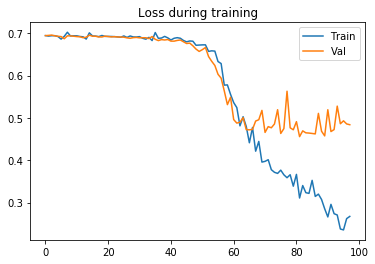

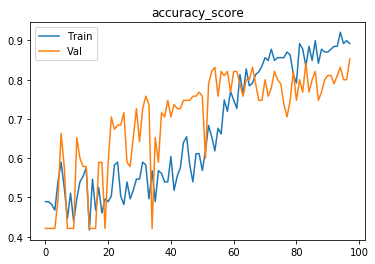

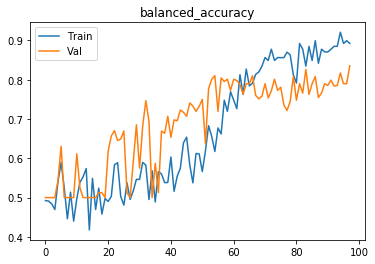

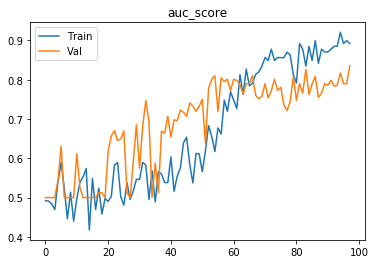

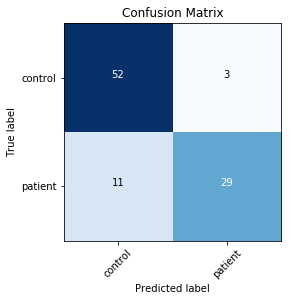

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 259131
[0,    10] loss: 0.69459
[0,    20] loss: 0.69683
[0,    30] loss: 0.69598
Time elapsed: 0h:0m:3s
train accuracy_score: 50.36 %
train balanced_accuracy: 50.53 %
train auc_score: 50.53 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.691014
[1,    10] loss: 0.69567
[1,    20] loss: 0.69475
[1,    30] loss: 0.69346
Time elapsed: 0h:0m:8s
train accuracy_score: 46.76 %
train balanced_accuracy: 46.75 %
train auc_score: 46.75 %
val accuracy_score: 51.58 %
val balanced_accuracy: 57.84 %
val auc_score: 57.84 %
Val loss: 0.692600
[2,    10] loss: 0.69031
[2,    20] loss: 0.69748
[2,    30] loss: 0.70082
Time elapsed: 0h:0m:12s
train accuracy_score: 43.17 %
train balanced_accuracy: 43.03 %
train auc_score: 43.03 %
val accuracy_score: 42.11 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.694264
[3, 

[28,    10] loss: 0.61940
[28,    20] loss: 0.36699
[28,    30] loss: 0.49072
Time elapsed: 0h:2m:15s
train accuracy_score: 78.42 %
train balanced_accuracy: 78.37 %
train auc_score: 78.37 %
val accuracy_score: 80.00 %
val balanced_accuracy: 76.25 %
val auc_score: 76.25 %
Val loss: 0.495776
[29,    10] loss: 0.66119
[29,    20] loss: 0.52812
[29,    30] loss: 0.51386
Time elapsed: 0h:2m:20s
train accuracy_score: 74.10 %
train balanced_accuracy: 74.08 %
train auc_score: 74.08 %
val accuracy_score: 82.11 %
val balanced_accuracy: 79.09 %
val auc_score: 79.09 %
Val loss: 0.453088
[30,    10] loss: 0.40329
[30,    20] loss: 0.32073
[30,    30] loss: 0.52666
Time elapsed: 0h:2m:24s
train accuracy_score: 83.45 %
train balanced_accuracy: 83.45 %
train auc_score: 83.45 %
val accuracy_score: 82.11 %
val balanced_accuracy: 80.11 %
val auc_score: 80.11 %
Val loss: 0.417451
[31,    10] loss: 0.45055
[31,    20] loss: 0.36722
[31,    30] loss: 0.46014
Time elapsed: 0h:2m:29s
train accuracy_score: 79.

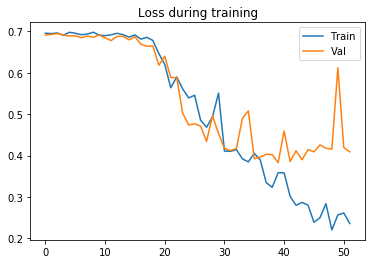

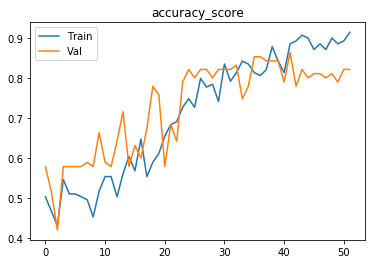

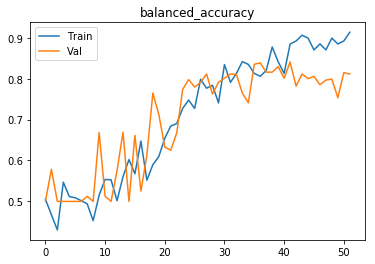

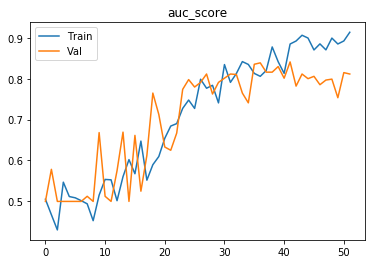

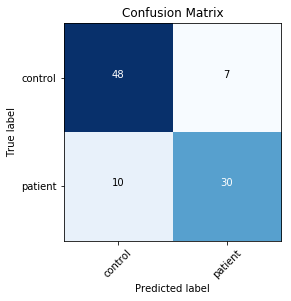

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 519979
[0,    10] loss: 0.70016
Time elapsed: 0h:0m:4s
train accuracy_score: 52.52 %
train balanced_accuracy: 52.77 %
train auc_score: 52.77 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.689547
[1,    10] loss: 0.69338
Time elapsed: 0h:0m:10s
train accuracy_score: 51.80 %
train balanced_accuracy: 51.63 %
train auc_score: 51.63 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.687445
[2,    10] loss: 0.69487
Time elapsed: 0h:0m:16s
train accuracy_score: 45.32 %
train balanced_accuracy: 45.04 %
train auc_score: 45.04 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.691093
[3,    10] loss: 0.69451
Time elapsed: 0h:0m:22s
train accuracy_score: 48.20 %
train balanced_accuracy: 48.04 %
train auc_score: 48.04 %
val accuracy_sc

[34,    10] loss: 0.32931
Time elapsed: 0h:3m:32s
train accuracy_score: 87.05 %
train balanced_accuracy: 87.01 %
train auc_score: 87.01 %
val accuracy_score: 81.05 %
val balanced_accuracy: 77.50 %
val auc_score: 77.50 %
Val loss: 0.412384
[35,    10] loss: 0.31782
Time elapsed: 0h:3m:38s
train accuracy_score: 87.77 %
train balanced_accuracy: 87.76 %
train auc_score: 87.76 %
val accuracy_score: 80.00 %
val balanced_accuracy: 76.25 %
val auc_score: 76.25 %
Val loss: 0.457380
[36,    10] loss: 0.32490
Time elapsed: 0h:3m:44s
train accuracy_score: 86.33 %
train balanced_accuracy: 86.31 %
train auc_score: 86.31 %
val accuracy_score: 84.21 %
val balanced_accuracy: 81.59 %
val auc_score: 81.59 %
Val loss: 0.352981
[37,    10] loss: 0.27476
Time elapsed: 0h:3m:50s
train accuracy_score: 86.33 %
train balanced_accuracy: 86.34 %
train auc_score: 86.34 %
val accuracy_score: 83.16 %
val balanced_accuracy: 80.00 %
val auc_score: 80.00 %
Val loss: 0.386796
[38,    10] loss: 0.27725
Time elapsed: 0h:3

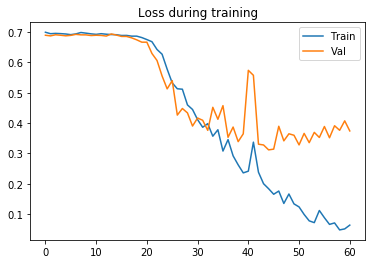

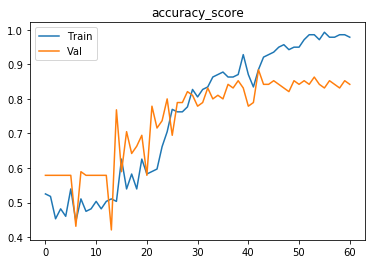

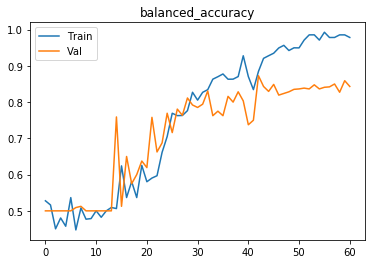

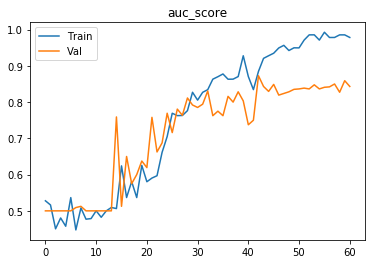

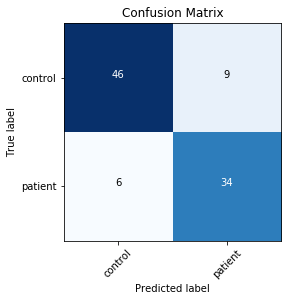

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 519979
[0,    10] loss: 0.70482
[0,    20] loss: 0.69196
[0,    30] loss: 0.70384
Time elapsed: 0h:0m:5s
train accuracy_score: 49.64 %
train balanced_accuracy: 49.33 %
train auc_score: 49.33 %
val accuracy_score: 42.11 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.694023
[1,    10] loss: 0.68720
[1,    20] loss: 0.70493
[1,    30] loss: 0.70700
Time elapsed: 0h:0m:12s
train accuracy_score: 47.48 %
train balanced_accuracy: 47.66 %
train auc_score: 47.66 %
val accuracy_score: 62.11 %
val balanced_accuracy: 57.73 %
val auc_score: 57.73 %
Val loss: 0.692341
[2,    10] loss: 0.69462
[2,    20] loss: 0.70190
[2,    30] loss: 0.69826
Time elapsed: 0h:0m:19s
train accuracy_score: 45.32 %
train balanced_accuracy: 45.22 %
train auc_score: 45.22 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.686783
[3,

[28,    10] loss: 0.18466
[28,    20] loss: 0.13423
[28,    30] loss: 0.20153
Time elapsed: 0h:3m:21s
train accuracy_score: 94.96 %
train balanced_accuracy: 94.95 %
train auc_score: 94.95 %
val accuracy_score: 80.00 %
val balanced_accuracy: 80.34 %
val auc_score: 80.34 %
Val loss: 0.504013
[29,    10] loss: 0.13362
[29,    20] loss: 0.13351
[29,    30] loss: 0.21094
Time elapsed: 0h:3m:28s
train accuracy_score: 93.53 %
train balanced_accuracy: 93.53 %
train auc_score: 93.53 %
val accuracy_score: 78.95 %
val balanced_accuracy: 76.02 %
val auc_score: 76.02 %
Val loss: 0.548888
[30,    10] loss: 0.14138
[30,    20] loss: 0.23968
[30,    30] loss: 0.10708
Time elapsed: 0h:3m:35s
train accuracy_score: 93.53 %
train balanced_accuracy: 93.53 %
train auc_score: 93.53 %
val accuracy_score: 76.84 %
val balanced_accuracy: 75.23 %
val auc_score: 75.23 %
Val loss: 0.499837
[31,    10] loss: 0.16652
[31,    20] loss: 0.16773
[31,    30] loss: 0.11443
Time elapsed: 0h:3m:42s
train accuracy_score: 94.

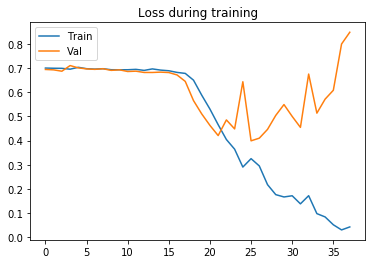

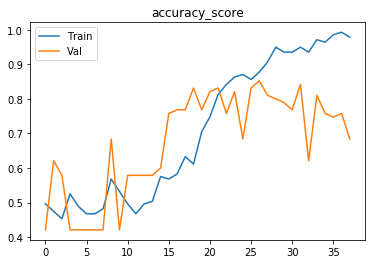

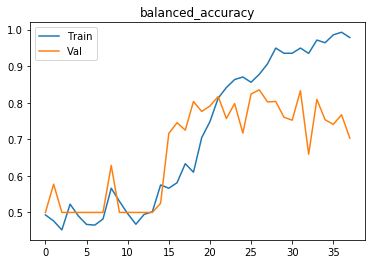

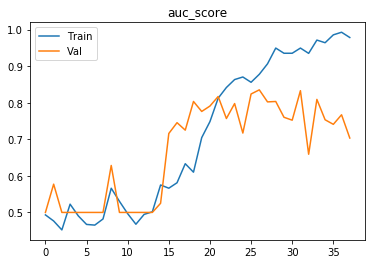

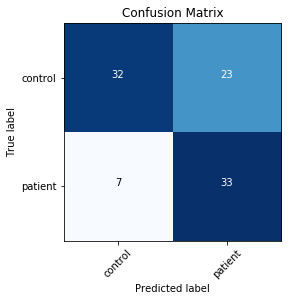

###### Starting inner fold 4
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 259131
[0,    10] loss: 0.69657
Time elapsed: 0h:0m:2s
train accuracy_score: 51.80 %
train balanced_accuracy: 51.46 %
train auc_score: 51.46 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.690121
[1,    10] loss: 0.69019
Time elapsed: 0h:0m:5s
train accuracy_score: 55.40 %
train balanced_accuracy: 55.18 %
train auc_score: 55.18 %
val accuracy_score: 38.95 %
val balanced_accuracy: 42.84 %
val auc_score: 42.84 %
Val loss: 0.693424
[2,    10] loss: 0.69954
Time elapsed: 0h:0m:9s
train accuracy_score: 46.76 %
train balanced_accuracy: 46.82 %
train auc_score: 46.82 %
val accuracy_score: 57.89 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.692040
[3,    10] loss: 0.69536
Time elapsed: 0h:0m:13s
train accuracy_score: 47.48 %
train balanced_accuracy: 47.30 %
train auc_score: 47.30 %
val accuracy_scor

[34,    10] loss: 0.68820
Time elapsed: 0h:2m:11s
train accuracy_score: 56.12 %
train balanced_accuracy: 55.99 %
train auc_score: 55.99 %
val accuracy_score: 60.00 %
val balanced_accuracy: 52.50 %
val auc_score: 52.50 %
Val loss: 0.685230
[35,    10] loss: 0.69147
Time elapsed: 0h:2m:15s
train accuracy_score: 51.80 %
train balanced_accuracy: 51.81 %
train auc_score: 51.81 %
val accuracy_score: 57.89 %
val balanced_accuracy: 61.93 %
val auc_score: 61.93 %
Val loss: 0.689031
[36,    10] loss: 0.69152
Time elapsed: 0h:2m:19s
train accuracy_score: 52.52 %
train balanced_accuracy: 52.41 %
train auc_score: 52.41 %
val accuracy_score: 58.95 %
val balanced_accuracy: 51.25 %
val auc_score: 51.25 %
Val loss: 0.682724
[37,    10] loss: 0.68675
Time elapsed: 0h:2m:23s
train accuracy_score: 54.68 %
train balanced_accuracy: 54.50 %
train auc_score: 54.50 %
val accuracy_score: 64.21 %
val balanced_accuracy: 57.50 %
val auc_score: 57.50 %
Val loss: 0.679874
[38,    10] loss: 0.67899
Time elapsed: 0h:2

val accuracy_score: 86.32 %
val balanced_accuracy: 83.75 %
val auc_score: 83.75 %
Val loss: 0.374244
[69,    10] loss: 0.42148
Time elapsed: 0h:4m:22s
train accuracy_score: 77.70 %
train balanced_accuracy: 77.70 %
train auc_score: 77.70 %
val accuracy_score: 85.26 %
val balanced_accuracy: 83.52 %
val auc_score: 83.52 %
Val loss: 0.368915
[70,    10] loss: 0.37369
Time elapsed: 0h:4m:26s
train accuracy_score: 84.89 %
train balanced_accuracy: 84.83 %
train auc_score: 84.83 %
val accuracy_score: 81.05 %
val balanced_accuracy: 80.57 %
val auc_score: 80.57 %
Val loss: 0.367734
[71,    10] loss: 0.41238
Time elapsed: 0h:4m:29s
train accuracy_score: 83.45 %
train balanced_accuracy: 83.47 %
train auc_score: 83.47 %
val accuracy_score: 84.21 %
val balanced_accuracy: 81.25 %
val auc_score: 81.25 %
Val loss: 0.380206
[72,    10] loss: 0.38289
Time elapsed: 0h:4m:33s
train accuracy_score: 83.45 %
train balanced_accuracy: 83.42 %
train auc_score: 83.42 %
val accuracy_score: 85.26 %
val balanced_acc

[103,    10] loss: 0.32474
Time elapsed: 0h:6m:32s
train accuracy_score: 86.33 %
train balanced_accuracy: 86.33 %
train auc_score: 86.33 %
val accuracy_score: 82.11 %
val balanced_accuracy: 81.48 %
val auc_score: 81.48 %
Val loss: 0.318196
[104,    10] loss: 0.16453
Time elapsed: 0h:6m:35s
train accuracy_score: 91.37 %
train balanced_accuracy: 91.33 %
train auc_score: 91.33 %
val accuracy_score: 87.37 %
val balanced_accuracy: 88.07 %
val auc_score: 88.07 %
Val loss: 0.327694
[105,    10] loss: 0.14615
Time elapsed: 0h:6m:39s
train accuracy_score: 94.24 %
train balanced_accuracy: 94.27 %
train auc_score: 94.27 %
val accuracy_score: 82.11 %
val balanced_accuracy: 79.09 %
val auc_score: 79.09 %
Val loss: 0.371114
[106,    10] loss: 0.19078
Time elapsed: 0h:6m:43s
train accuracy_score: 92.09 %
train balanced_accuracy: 92.09 %
train auc_score: 92.09 %
val accuracy_score: 84.21 %
val balanced_accuracy: 83.30 %
val auc_score: 83.30 %
Val loss: 0.311384
Early stopping in epoch 107
Total time e

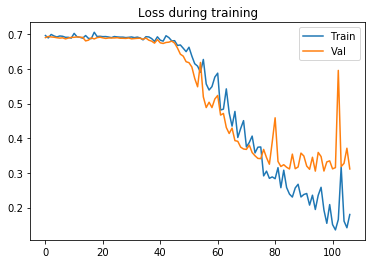

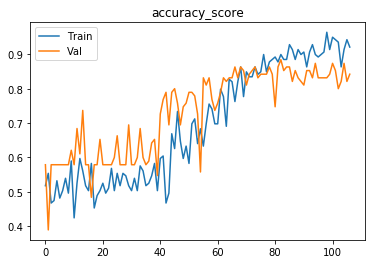

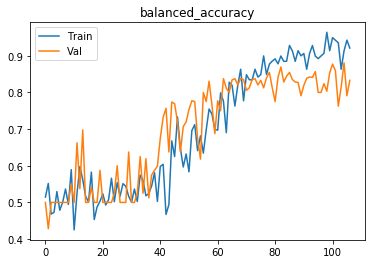

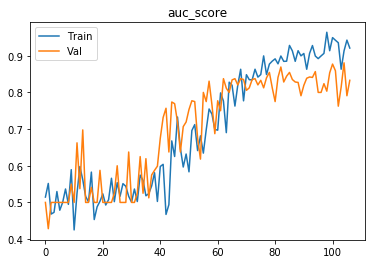

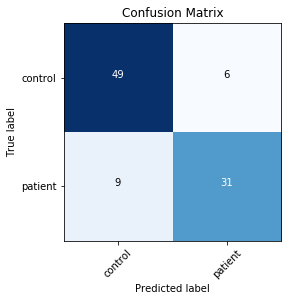

Finished outer fold.
{'final_acc': 0.8431818181818181, 'best_acc': 0.8727272727272728, 'final_iter': 61, 'best_iter': 43, 'params': {'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 2}
###### Starting outer fold 2
# of patients 122, # of healthy controls 117
138
101
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 259131
[0,    10] loss: 0.68710
[0,    20] loss: 0.69553
Time elapsed: 0h:0m:2s
train accuracy_score: 55.07 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.698777
[1,    10] loss: 0.70142
[1,    20] loss: 0.68443
Time elapsed: 0h:0m:6s
train accuracy_score: 55.80 %
train balanced_accuracy: 50.81 %
train auc_score: 50.81 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.696693
[2,    10] loss: 0.69371
[2,    20] 

val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.701530
[30,    10] loss: 0.68801
[30,    20] loss: 0.67546
Time elapsed: 0h:1m:53s
train accuracy_score: 57.25 %
train balanced_accuracy: 54.20 %
train auc_score: 54.20 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.691014
[31,    10] loss: 0.67922
[31,    20] loss: 0.67605
Time elapsed: 0h:1m:57s
train accuracy_score: 59.42 %
train balanced_accuracy: 55.88 %
train auc_score: 55.88 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.695300
[32,    10] loss: 0.68047
[32,    20] loss: 0.67793
Time elapsed: 0h:2m:1s
train accuracy_score: 59.42 %
train balanced_accuracy: 56.18 %
train auc_score: 56.18 %
val accuracy_score: 58.42 %
val balanced_accuracy: 60.75 %
val auc_score: 60.75 %
Val loss: 0.685550
[33,    10] loss: 0.66956
[33,    20] loss: 0.65948
Time elapsed: 0h:2m:4s
train accuracy_score: 61.59 %


val accuracy_score: 64.36 %
val balanced_accuracy: 64.25 %
val auc_score: 64.25 %
Val loss: 0.602576
[61,    10] loss: 0.38979
[61,    20] loss: 0.51131
Time elapsed: 0h:3m:46s
train accuracy_score: 81.88 %
train balanced_accuracy: 82.22 %
train auc_score: 82.22 %
val accuracy_score: 62.38 %
val balanced_accuracy: 63.50 %
val auc_score: 63.50 %
Val loss: 0.675417
[62,    10] loss: 0.37944
[62,    20] loss: 0.49039
Time elapsed: 0h:3m:50s
train accuracy_score: 78.26 %
train balanced_accuracy: 77.89 %
train auc_score: 77.89 %
val accuracy_score: 68.32 %
val balanced_accuracy: 67.89 %
val auc_score: 67.89 %
Val loss: 0.591012
[63,    10] loss: 0.39136
[63,    20] loss: 0.41943
Time elapsed: 0h:3m:54s
train accuracy_score: 83.33 %
train balanced_accuracy: 83.09 %
train auc_score: 83.09 %
val accuracy_score: 67.33 %
val balanced_accuracy: 67.87 %
val auc_score: 67.87 %
Val loss: 0.620423
[64,    10] loss: 0.35334
[64,    20] loss: 0.45455
Time elapsed: 0h:3m:58s
train accuracy_score: 84.78 

val accuracy_score: 73.27 %
val balanced_accuracy: 73.32 %
val auc_score: 73.32 %
Val loss: 0.564641
[92,    10] loss: 0.33827
[92,    20] loss: 0.28653
Time elapsed: 0h:5m:41s
train accuracy_score: 86.96 %
train balanced_accuracy: 87.12 %
train auc_score: 87.12 %
val accuracy_score: 65.35 %
val balanced_accuracy: 66.76 %
val auc_score: 66.76 %
Val loss: 0.663189
[93,    10] loss: 0.36610
[93,    20] loss: 0.29420
Time elapsed: 0h:5m:45s
train accuracy_score: 86.23 %
train balanced_accuracy: 86.16 %
train auc_score: 86.16 %
val accuracy_score: 71.29 %
val balanced_accuracy: 71.50 %
val auc_score: 71.50 %
Val loss: 0.592747
[94,    10] loss: 0.28696
[94,    20] loss: 0.31710
Time elapsed: 0h:5m:48s
train accuracy_score: 87.68 %
train balanced_accuracy: 87.92 %
train auc_score: 87.92 %
val accuracy_score: 72.28 %
val balanced_accuracy: 72.41 %
val auc_score: 72.41 %
Val loss: 0.571081
[95,    10] loss: 0.29837
[95,    20] loss: 0.21537
Time elapsed: 0h:5m:52s
train accuracy_score: 88.41 

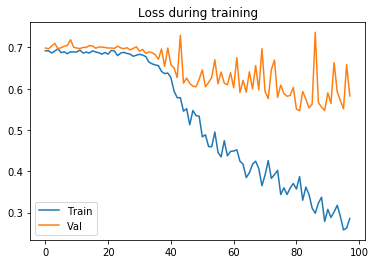

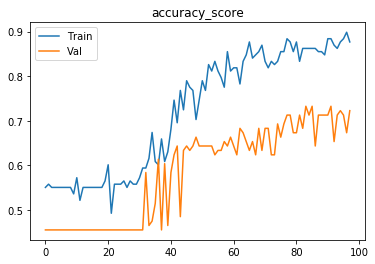

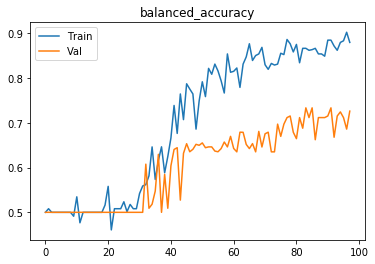

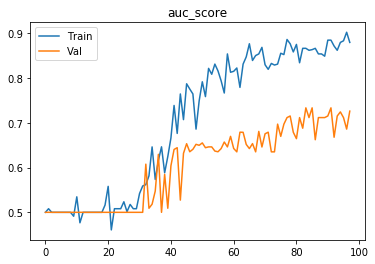

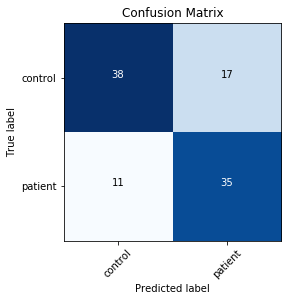

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 259131
[0,    10] loss: 0.69600
Time elapsed: 0h:0m:1s
train accuracy_score: 42.03 %
train balanced_accuracy: 46.33 %
train auc_score: 46.33 %
val accuracy_score: 55.45 %
val balanced_accuracy: 51.09 %
val auc_score: 51.09 %
Val loss: 0.693082
[1,    10] loss: 0.69262
Time elapsed: 0h:0m:5s
train accuracy_score: 51.45 %
train balanced_accuracy: 47.01 %
train auc_score: 47.01 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.696269
[2,    10] loss: 0.68860
Time elapsed: 0h:0m:8s
train accuracy_score: 55.07 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.708186
[3,    10] loss: 0.69208
Time elapsed: 0h:0m:11s
train accuracy_score: 55.07 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_scor

[34,    10] loss: 0.56319
Time elapsed: 0h:1m:54s
train accuracy_score: 74.64 %
train balanced_accuracy: 74.30 %
train auc_score: 74.30 %
val accuracy_score: 52.48 %
val balanced_accuracy: 55.47 %
val auc_score: 55.47 %
Val loss: 0.671079
[35,    10] loss: 0.55828
Time elapsed: 0h:1m:57s
train accuracy_score: 68.12 %
train balanced_accuracy: 65.70 %
train auc_score: 65.70 %
val accuracy_score: 69.31 %
val balanced_accuracy: 66.30 %
val auc_score: 66.30 %
Val loss: 0.615777
[36,    10] loss: 0.53324
Time elapsed: 0h:2m:0s
train accuracy_score: 74.64 %
train balanced_accuracy: 74.89 %
train auc_score: 74.89 %
val accuracy_score: 59.41 %
val balanced_accuracy: 60.42 %
val auc_score: 60.42 %
Val loss: 0.634030
[37,    10] loss: 0.52757
Time elapsed: 0h:2m:3s
train accuracy_score: 76.09 %
train balanced_accuracy: 75.76 %
train auc_score: 75.76 %
val accuracy_score: 65.35 %
val balanced_accuracy: 63.20 %
val auc_score: 63.20 %
Val loss: 0.633113
[38,    10] loss: 0.51198
Time elapsed: 0h:2m:

val accuracy_score: 59.41 %
val balanced_accuracy: 62.02 %
val auc_score: 62.02 %
Val loss: 0.868727
[69,    10] loss: 0.44312
Time elapsed: 0h:3m:52s
train accuracy_score: 76.81 %
train balanced_accuracy: 75.83 %
train auc_score: 75.83 %
val accuracy_score: 69.31 %
val balanced_accuracy: 68.62 %
val auc_score: 68.62 %
Val loss: 0.607437
[70,    10] loss: 0.38844
Time elapsed: 0h:3m:55s
train accuracy_score: 82.61 %
train balanced_accuracy: 81.98 %
train auc_score: 81.98 %
val accuracy_score: 74.26 %
val balanced_accuracy: 73.16 %
val auc_score: 73.16 %
Val loss: 0.577737
[71,    10] loss: 0.38787
Time elapsed: 0h:3m:58s
train accuracy_score: 80.43 %
train balanced_accuracy: 81.64 %
train auc_score: 81.64 %
val accuracy_score: 60.40 %
val balanced_accuracy: 62.75 %
val auc_score: 62.75 %
Val loss: 0.755954
[72,    10] loss: 0.36088
Time elapsed: 0h:4m:2s
train accuracy_score: 85.51 %
train balanced_accuracy: 84.76 %
train auc_score: 84.76 %
val accuracy_score: 72.28 %
val balanced_accu

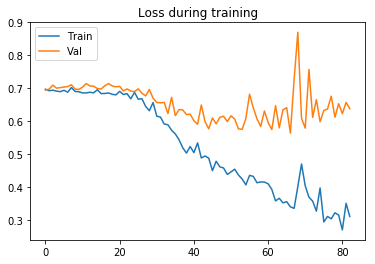

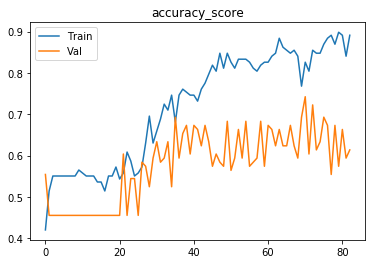

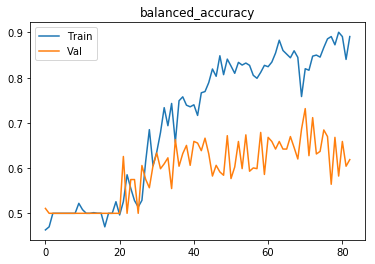

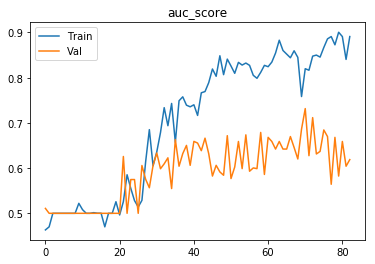

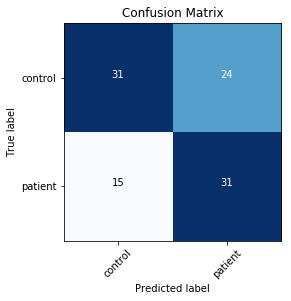

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 519979
[0,    10] loss: 0.69545
[0,    20] loss: 0.68975
[0,    30] loss: 0.68993
Time elapsed: 0h:0m:4s
train accuracy_score: 55.07 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.705764
[1,    10] loss: 0.68768
[1,    20] loss: 0.69027
[1,    30] loss: 0.69684
Time elapsed: 0h:0m:11s
train accuracy_score: 55.07 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.698723
[2,    10] loss: 0.70397
[2,    20] loss: 0.68732
[2,    30] loss: 0.68645
Time elapsed: 0h:0m:18s
train accuracy_score: 52.17 %
train balanced_accuracy: 47.81 %
train auc_score: 47.81 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.699550
[3, 

[28,    10] loss: 0.49453
[28,    20] loss: 0.40699
[28,    30] loss: 0.42856
Time elapsed: 0h:3m:10s
train accuracy_score: 81.16 %
train balanced_accuracy: 81.11 %
train auc_score: 81.11 %
val accuracy_score: 65.35 %
val balanced_accuracy: 65.16 %
val auc_score: 65.16 %
Val loss: 0.569978
[29,    10] loss: 0.38108
[29,    20] loss: 0.40917
[29,    30] loss: 0.42593
Time elapsed: 0h:3m:17s
train accuracy_score: 82.61 %
train balanced_accuracy: 82.72 %
train auc_score: 82.72 %
val accuracy_score: 60.40 %
val balanced_accuracy: 62.04 %
val auc_score: 62.04 %
Val loss: 0.642695
[30,    10] loss: 0.27261
[30,    20] loss: 0.50813
[30,    30] loss: 0.41977
Time elapsed: 0h:3m:24s
train accuracy_score: 82.61 %
train balanced_accuracy: 82.43 %
train auc_score: 82.43 %
val accuracy_score: 61.39 %
val balanced_accuracy: 63.30 %
val auc_score: 63.30 %
Val loss: 0.681487
[31,    10] loss: 0.39034
[31,    20] loss: 0.44695
[31,    30] loss: 0.33225
Time elapsed: 0h:3m:30s
train accuracy_score: 81.

[56,    30] loss: 0.01638
Time elapsed: 0h:6m:17s
train accuracy_score: 97.83 %
train balanced_accuracy: 97.88 %
train auc_score: 97.88 %
val accuracy_score: 74.26 %
val balanced_accuracy: 73.52 %
val auc_score: 73.52 %
Val loss: 0.621996
[57,    10] loss: 0.05032
[57,    20] loss: 0.11566
[57,    30] loss: 0.04709
Time elapsed: 0h:6m:24s
train accuracy_score: 98.55 %
train balanced_accuracy: 98.54 %
train auc_score: 98.54 %
val accuracy_score: 74.26 %
val balanced_accuracy: 73.87 %
val auc_score: 73.87 %
Val loss: 0.630439
[58,    10] loss: 0.03398
[58,    20] loss: 0.02333
[58,    30] loss: 0.02308
Time elapsed: 0h:6m:30s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
train auc_score: 100.00 %
val accuracy_score: 75.25 %
val balanced_accuracy: 74.25 %
val auc_score: 74.25 %
Val loss: 0.678617
[59,    10] loss: 0.04253
[59,    20] loss: 0.04161
[59,    30] loss: 0.04380
Time elapsed: 0h:6m:37s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
train auc

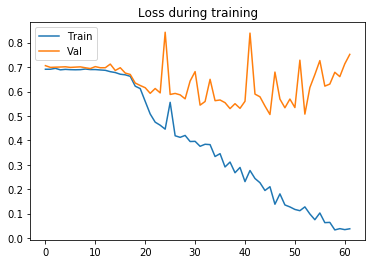

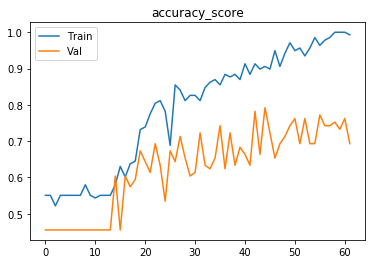

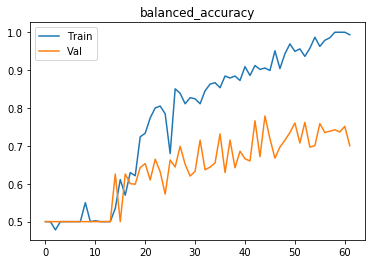

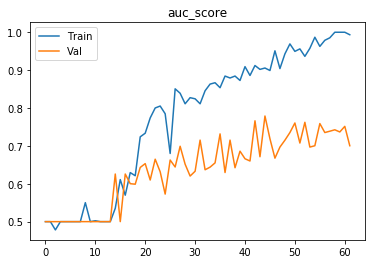

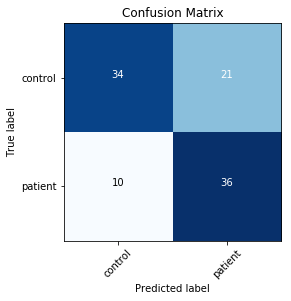

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 519979
[0,    10] loss: 0.69428
[0,    20] loss: 0.69525
Time elapsed: 0h:0m:4s
train accuracy_score: 44.93 %
train balanced_accuracy: 47.92 %
train auc_score: 47.92 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.695900
[1,    10] loss: 0.68871
[1,    20] loss: 0.69318
Time elapsed: 0h:0m:10s
train accuracy_score: 55.07 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.701143
[2,    10] loss: 0.69370
[2,    20] loss: 0.69060
Time elapsed: 0h:0m:16s
train accuracy_score: 55.07 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.697706
[3,    10] loss: 0.69719
[3,    20] loss: 0.67719
Time elapsed: 0h:0m:22s
train

val accuracy_score: 56.44 %
val balanced_accuracy: 52.89 %
val auc_score: 52.89 %
Val loss: 0.709374
[31,    10] loss: 0.63569
[31,    20] loss: 0.59709
Time elapsed: 0h:3m:12s
train accuracy_score: 65.22 %
train balanced_accuracy: 65.60 %
train auc_score: 65.60 %
val accuracy_score: 52.48 %
val balanced_accuracy: 56.36 %
val auc_score: 56.36 %
Val loss: 0.690065
[32,    10] loss: 0.57639
[32,    20] loss: 0.57248
Time elapsed: 0h:3m:18s
train accuracy_score: 69.57 %
train balanced_accuracy: 68.95 %
train auc_score: 68.95 %
val accuracy_score: 60.40 %
val balanced_accuracy: 59.37 %
val auc_score: 59.37 %
Val loss: 0.624314
[33,    10] loss: 0.55369
[33,    20] loss: 0.56666
Time elapsed: 0h:3m:24s
train accuracy_score: 77.54 %
train balanced_accuracy: 76.93 %
train auc_score: 76.93 %
val accuracy_score: 63.37 %
val balanced_accuracy: 61.74 %
val auc_score: 61.74 %
Val loss: 0.613932
[34,    10] loss: 0.48782
[34,    20] loss: 0.54245
Time elapsed: 0h:3m:30s
train accuracy_score: 72.46 

val accuracy_score: 75.25 %
val balanced_accuracy: 74.25 %
val auc_score: 74.25 %
Val loss: 0.505932
[62,    10] loss: 0.22588
[62,    20] loss: 0.33664
Time elapsed: 0h:6m:21s
train accuracy_score: 88.41 %
train balanced_accuracy: 88.43 %
train auc_score: 88.43 %
val accuracy_score: 66.34 %
val balanced_accuracy: 67.67 %
val auc_score: 67.67 %
Val loss: 0.566395
[63,    10] loss: 0.23322
[63,    20] loss: 0.21902
Time elapsed: 0h:6m:28s
train accuracy_score: 91.30 %
train balanced_accuracy: 91.21 %
train auc_score: 91.21 %
val accuracy_score: 67.33 %
val balanced_accuracy: 68.04 %
val auc_score: 68.04 %
Val loss: 0.527385
[64,    10] loss: 0.33065
[64,    20] loss: 0.27748
Time elapsed: 0h:6m:34s
train accuracy_score: 87.68 %
train balanced_accuracy: 87.33 %
train auc_score: 87.33 %
val accuracy_score: 72.28 %
val balanced_accuracy: 71.88 %
val auc_score: 71.88 %
Val loss: 0.491256
[65,    10] loss: 0.36963
[65,    20] loss: 0.48927
Time elapsed: 0h:6m:41s
train accuracy_score: 84.78 

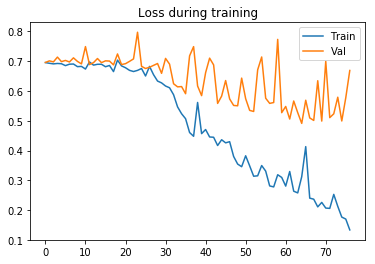

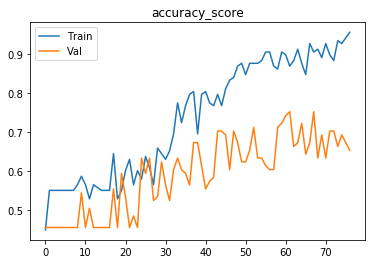

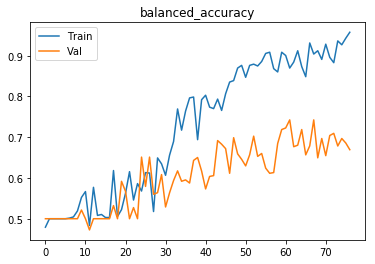

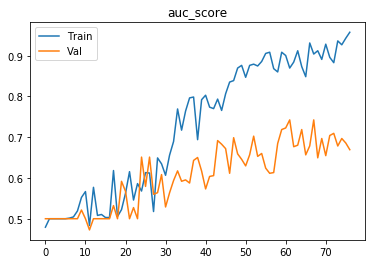

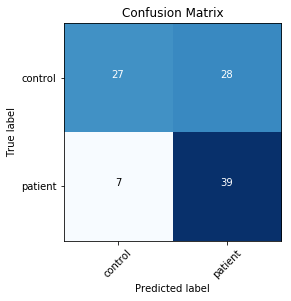

###### Starting inner fold 4
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 519979
[0,    10] loss: 0.69427
[0,    20] loss: 0.68874
Time elapsed: 0h:0m:4s
train accuracy_score: 53.62 %
train balanced_accuracy: 48.98 %
train auc_score: 48.98 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.704101
[1,    10] loss: 0.68582
[1,    20] loss: 0.69885
Time elapsed: 0h:0m:11s
train accuracy_score: 55.07 %
train balanced_accuracy: 51.49 %
train auc_score: 51.49 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.699554
[2,    10] loss: 0.69457
[2,    20] loss: 0.70203
Time elapsed: 0h:0m:18s
train accuracy_score: 47.10 %
train balanced_accuracy: 43.95 %
train auc_score: 43.95 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.696716
[3,    10] loss: 0.69951
[3,    20] loss: 0.69911
Time elapsed: 0h:0m:25s
trai

val accuracy_score: 77.23 %
val balanced_accuracy: 75.18 %
val auc_score: 75.18 %
Val loss: 0.755928
[31,    10] loss: 0.37971
[31,    20] loss: 0.22902
Time elapsed: 0h:3m:31s
train accuracy_score: 90.58 %
train balanced_accuracy: 90.56 %
train auc_score: 90.56 %
val accuracy_score: 72.28 %
val balanced_accuracy: 71.52 %
val auc_score: 71.52 %
Val loss: 0.551083
[32,    10] loss: 0.18260
[32,    20] loss: 0.26783
Time elapsed: 0h:3m:37s
train accuracy_score: 93.48 %
train balanced_accuracy: 93.19 %
train auc_score: 93.19 %
val accuracy_score: 78.22 %
val balanced_accuracy: 76.09 %
val auc_score: 76.09 %
Val loss: 0.808869
[33,    10] loss: 0.30168
[33,    20] loss: 0.43724
Time elapsed: 0h:3m:44s
train accuracy_score: 82.61 %
train balanced_accuracy: 82.87 %
train auc_score: 82.87 %
val accuracy_score: 61.39 %
val balanced_accuracy: 63.12 %
val auc_score: 63.12 %
Val loss: 0.835234
[34,    10] loss: 0.27688
[34,    20] loss: 0.21776
Time elapsed: 0h:3m:51s
train accuracy_score: 92.03 

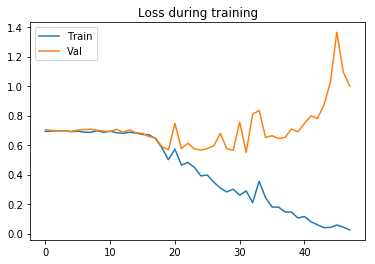

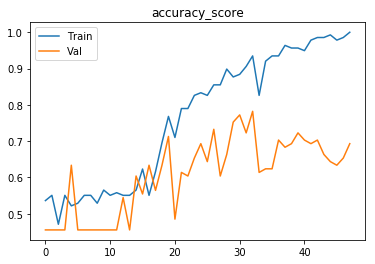

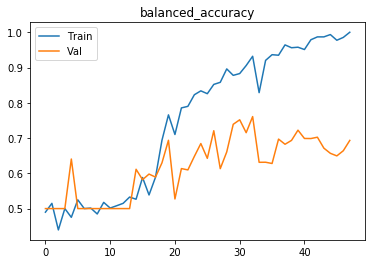

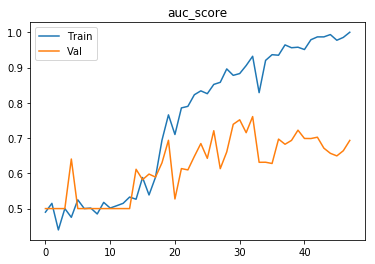

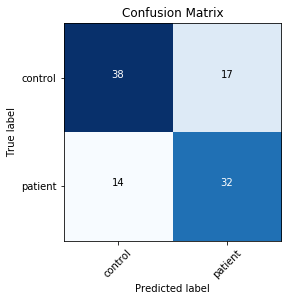

Finished outer fold.
{'final_acc': 0.700395256916996, 'best_acc': 0.7788537549407115, 'final_iter': 62, 'best_iter': 45, 'params': {'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 2}
###### Starting outer fold 3
# of patients 98, # of healthy controls 141
141
98
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 259131
[0,    10] loss: 0.69140
[0,    20] loss: 0.67539
Time elapsed: 0h:0m:2s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.43 %
train auc_score: 50.43 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.666284
[1,    10] loss: 0.68669
[1,    20] loss: 0.67262
Time elapsed: 0h:0m:6s
train accuracy_score: 56.74 %
train balanced_accuracy: 49.81 %
train auc_score: 49.81 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.668882
[2,    10] loss: 0.65750
[2,    20] loss

val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.665975
[30,    10] loss: 0.66063
[30,    20] loss: 0.71041
Time elapsed: 0h:1m:53s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.668044
[31,    10] loss: 0.69364
[31,    20] loss: 0.66771
Time elapsed: 0h:1m:57s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.669126
[32,    10] loss: 0.68678
[32,    20] loss: 0.67366
Time elapsed: 0h:2m:0s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.664491
[33,    10] loss: 0.70701
[33,    20] loss: 0.66305
Time elapsed: 0h:2m:4s
train accuracy_score: 57.45 %


val accuracy_score: 68.37 %
val balanced_accuracy: 71.75 %
val auc_score: 71.75 %
Val loss: 0.584987
[61,    10] loss: 0.45658
[61,    20] loss: 0.29175
Time elapsed: 0h:3m:51s
train accuracy_score: 82.98 %
train balanced_accuracy: 81.73 %
train auc_score: 81.73 %
val accuracy_score: 68.37 %
val balanced_accuracy: 70.79 %
val auc_score: 70.79 %
Val loss: 0.567762
[62,    10] loss: 0.30763
[62,    20] loss: 0.45665
Time elapsed: 0h:3m:55s
train accuracy_score: 80.85 %
train balanced_accuracy: 79.66 %
train auc_score: 79.66 %
val accuracy_score: 74.49 %
val balanced_accuracy: 73.38 %
val auc_score: 73.38 %
Val loss: 0.501271
[63,    10] loss: 0.41105
[63,    20] loss: 0.43151
Time elapsed: 0h:3m:59s
train accuracy_score: 84.40 %
train balanced_accuracy: 84.04 %
train auc_score: 84.04 %
val accuracy_score: 71.43 %
val balanced_accuracy: 74.25 %
val auc_score: 74.25 %
Val loss: 0.569530
[64,    10] loss: 0.31463
[64,    20] loss: 0.32483
Time elapsed: 0h:4m:3s
train accuracy_score: 89.36 %

val accuracy_score: 79.59 %
val balanced_accuracy: 82.37 %
val auc_score: 82.37 %
Val loss: 0.590434
[92,    10] loss: 0.11542
[92,    20] loss: 0.23894
Time elapsed: 0h:5m:49s
train accuracy_score: 93.62 %
train balanced_accuracy: 92.93 %
train auc_score: 92.93 %
val accuracy_score: 72.45 %
val balanced_accuracy: 76.54 %
val auc_score: 76.54 %
Val loss: 0.759031
[93,    10] loss: 0.22816
[93,    20] loss: 0.18288
Time elapsed: 0h:5m:52s
train accuracy_score: 93.62 %
train balanced_accuracy: 93.58 %
train auc_score: 93.58 %
val accuracy_score: 77.55 %
val balanced_accuracy: 78.77 %
val auc_score: 78.77 %
Val loss: 0.524871
[94,    10] loss: 0.13484
[94,    20] loss: 0.07615
Time elapsed: 0h:5m:56s
train accuracy_score: 98.58 %
train balanced_accuracy: 98.55 %
train auc_score: 98.55 %
val accuracy_score: 78.57 %
val balanced_accuracy: 81.54 %
val auc_score: 81.54 %
Val loss: 0.660003
[95,    10] loss: 0.13081
[95,    20] loss: 0.09558
Time elapsed: 0h:6m:0s
train accuracy_score: 97.16 %

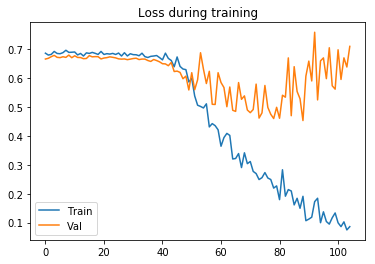

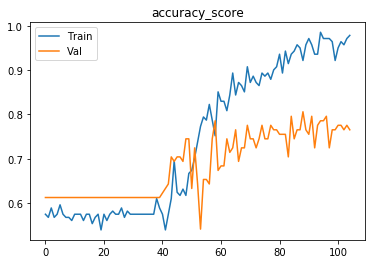

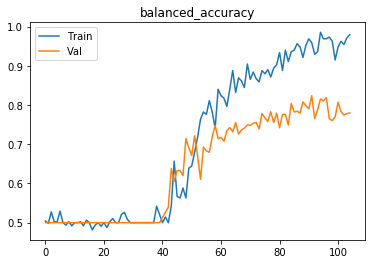

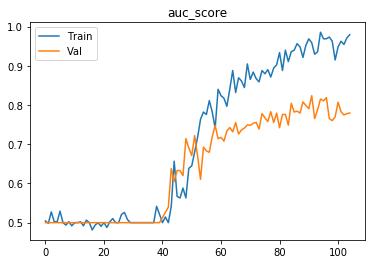

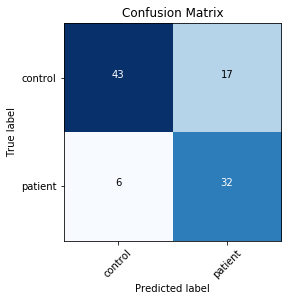

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 259131
[0,    10] loss: 0.69163
Time elapsed: 0h:0m:2s
train accuracy_score: 49.65 %
train balanced_accuracy: 48.18 %
train auc_score: 48.18 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.678737
[1,    10] loss: 0.69022
Time elapsed: 0h:0m:5s
train accuracy_score: 58.16 %
train balanced_accuracy: 50.83 %
train auc_score: 50.83 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.669727
[2,    10] loss: 0.67338
Time elapsed: 0h:0m:8s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.667130
[3,    10] loss: 0.68955
Time elapsed: 0h:0m:12s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score

[34,    10] loss: 0.67820
Time elapsed: 0h:1m:55s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.664999
[35,    10] loss: 0.68222
Time elapsed: 0h:1m:59s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.666928
[36,    10] loss: 0.68871
Time elapsed: 0h:2m:2s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.672002
[37,    10] loss: 0.67536
Time elapsed: 0h:2m:5s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.669222
[38,    10] loss: 0.68082
Time elapsed: 0h:2m:

val accuracy_score: 62.24 %
val balanced_accuracy: 51.32 %
val auc_score: 51.32 %
Val loss: 0.625989
[69,    10] loss: 0.64251
Time elapsed: 0h:3m:52s
train accuracy_score: 64.54 %
train balanced_accuracy: 59.85 %
train auc_score: 59.85 %
val accuracy_score: 72.45 %
val balanced_accuracy: 65.92 %
val auc_score: 65.92 %
Val loss: 0.634077
[70,    10] loss: 0.64708
Time elapsed: 0h:3m:55s
train accuracy_score: 63.83 %
train balanced_accuracy: 58.36 %
train auc_score: 58.36 %
val accuracy_score: 67.35 %
val balanced_accuracy: 57.89 %
val auc_score: 57.89 %
Val loss: 0.620047
[71,    10] loss: 0.64086
Time elapsed: 0h:3m:59s
train accuracy_score: 63.12 %
train balanced_accuracy: 60.34 %
train auc_score: 60.34 %
val accuracy_score: 78.57 %
val balanced_accuracy: 77.68 %
val auc_score: 77.68 %
Val loss: 0.638133
[72,    10] loss: 0.66829
Time elapsed: 0h:4m:2s
train accuracy_score: 58.87 %
train balanced_accuracy: 54.48 %
train auc_score: 54.48 %
val accuracy_score: 68.37 %
val balanced_accu

[103,    10] loss: 0.47430
Time elapsed: 0h:5m:46s
train accuracy_score: 80.14 %
train balanced_accuracy: 78.83 %
train auc_score: 78.83 %
val accuracy_score: 79.59 %
val balanced_accuracy: 78.03 %
val auc_score: 78.03 %
Val loss: 0.505293
[104,    10] loss: 0.46520
Time elapsed: 0h:5m:49s
train accuracy_score: 78.72 %
train balanced_accuracy: 77.81 %
train auc_score: 77.81 %
val accuracy_score: 79.59 %
val balanced_accuracy: 76.10 %
val auc_score: 76.10 %
Val loss: 0.508957
[105,    10] loss: 0.48434
Time elapsed: 0h:5m:52s
train accuracy_score: 73.76 %
train balanced_accuracy: 72.19 %
train auc_score: 72.19 %
val accuracy_score: 76.53 %
val balanced_accuracy: 76.01 %
val auc_score: 76.01 %
Val loss: 0.506433
[106,    10] loss: 0.47422
Time elapsed: 0h:5m:56s
train accuracy_score: 80.14 %
train balanced_accuracy: 78.40 %
train auc_score: 78.40 %
val accuracy_score: 78.57 %
val balanced_accuracy: 74.78 %
val auc_score: 74.78 %
Val loss: 0.506568
[107,    10] loss: 0.50982
Time elapsed:

val accuracy_score: 80.61 %
val balanced_accuracy: 78.38 %
val auc_score: 78.38 %
Val loss: 0.464610
[138,    10] loss: 0.35421
Time elapsed: 0h:7m:38s
train accuracy_score: 84.40 %
train balanced_accuracy: 82.75 %
train auc_score: 82.75 %
val accuracy_score: 73.47 %
val balanced_accuracy: 74.47 %
val auc_score: 74.47 %
Val loss: 0.506030
[139,    10] loss: 0.30837
Time elapsed: 0h:7m:41s
train accuracy_score: 89.36 %
train balanced_accuracy: 89.01 %
train auc_score: 89.01 %
val accuracy_score: 79.59 %
val balanced_accuracy: 75.61 %
val auc_score: 75.61 %
Val loss: 0.474197
[140,    10] loss: 0.37645
Time elapsed: 0h:7m:45s
train accuracy_score: 87.23 %
train balanced_accuracy: 86.30 %
train auc_score: 86.30 %
val accuracy_score: 77.55 %
val balanced_accuracy: 75.88 %
val auc_score: 75.88 %
Val loss: 0.468152
[141,    10] loss: 0.38702
Time elapsed: 0h:7m:48s
train accuracy_score: 81.56 %
train balanced_accuracy: 79.63 %
train auc_score: 79.63 %
val accuracy_score: 66.33 %
val balanced

[172,    10] loss: 0.23618
Time elapsed: 0h:9m:28s
train accuracy_score: 90.78 %
train balanced_accuracy: 90.03 %
train auc_score: 90.03 %
val accuracy_score: 73.47 %
val balanced_accuracy: 74.47 %
val auc_score: 74.47 %
Val loss: 0.494265
Early stopping in epoch 173
Total time elapsed: 0h:9m:29s
Writing model to disk...
Best result during training: 0.81. Saving model..
Finished inner fold.


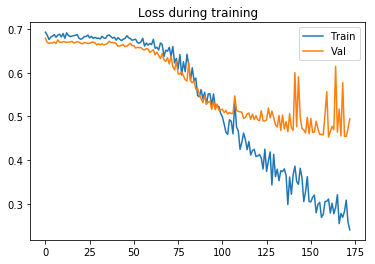

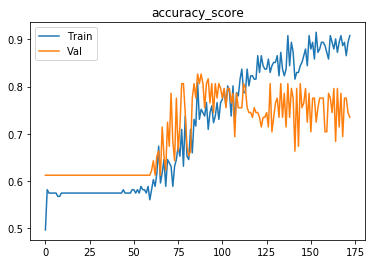

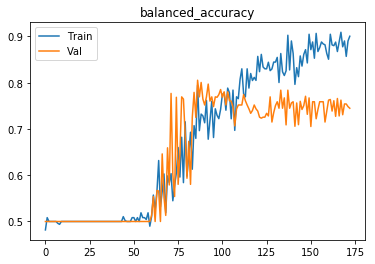

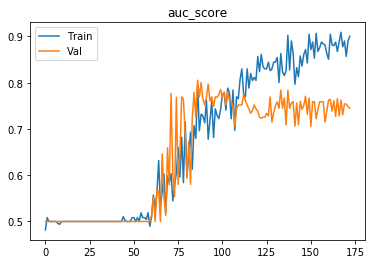

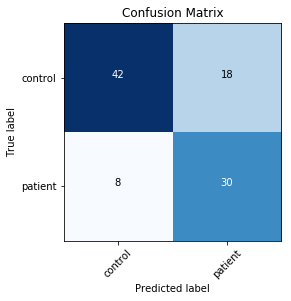

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 519979
[0,    10] loss: 0.68663
Time elapsed: 0h:0m:4s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.676046
[1,    10] loss: 0.67682
Time elapsed: 0h:0m:9s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.669491
[2,    10] loss: 0.68502
Time elapsed: 0h:0m:15s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.670423
[3,    10] loss: 0.68675
Time elapsed: 0h:0m:21s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_scor

[34,    10] loss: 0.63041
Time elapsed: 0h:3m:20s
train accuracy_score: 65.96 %
train balanced_accuracy: 61.94 %
train auc_score: 61.94 %
val accuracy_score: 79.59 %
val balanced_accuracy: 75.61 %
val auc_score: 75.61 %
Val loss: 0.622080
[35,    10] loss: 0.64439
Time elapsed: 0h:3m:26s
train accuracy_score: 64.54 %
train balanced_accuracy: 58.98 %
train auc_score: 58.98 %
val accuracy_score: 78.57 %
val balanced_accuracy: 74.30 %
val auc_score: 74.30 %
Val loss: 0.608393
[36,    10] loss: 0.62785
Time elapsed: 0h:3m:31s
train accuracy_score: 64.54 %
train balanced_accuracy: 63.09 %
train auc_score: 63.09 %
val accuracy_score: 68.37 %
val balanced_accuracy: 59.21 %
val auc_score: 59.21 %
Val loss: 0.604495
[37,    10] loss: 0.59044
Time elapsed: 0h:3m:37s
train accuracy_score: 72.34 %
train balanced_accuracy: 67.72 %
train auc_score: 67.72 %
val accuracy_score: 72.45 %
val balanced_accuracy: 64.47 %
val auc_score: 64.47 %
Val loss: 0.592669
[38,    10] loss: 0.58530
Time elapsed: 0h:3

val accuracy_score: 69.39 %
val balanced_accuracy: 69.21 %
val auc_score: 69.21 %
Val loss: 0.518709
[69,    10] loss: 0.25742
Time elapsed: 0h:6m:44s
train accuracy_score: 90.07 %
train balanced_accuracy: 88.98 %
train auc_score: 88.98 %
val accuracy_score: 69.39 %
val balanced_accuracy: 69.21 %
val auc_score: 69.21 %
Val loss: 0.523790
[70,    10] loss: 0.29910
Time elapsed: 0h:6m:50s
train accuracy_score: 90.78 %
train balanced_accuracy: 90.25 %
train auc_score: 90.25 %
val accuracy_score: 70.41 %
val balanced_accuracy: 65.70 %
val auc_score: 65.70 %
Val loss: 0.527594
[71,    10] loss: 0.31328
Time elapsed: 0h:6m:56s
train accuracy_score: 87.23 %
train balanced_accuracy: 86.51 %
train auc_score: 86.51 %
val accuracy_score: 71.43 %
val balanced_accuracy: 71.84 %
val auc_score: 71.84 %
Val loss: 0.531199
[72,    10] loss: 0.24485
Time elapsed: 0h:7m:2s
train accuracy_score: 90.07 %
train balanced_accuracy: 89.20 %
train auc_score: 89.20 %
val accuracy_score: 73.47 %
val balanced_accu

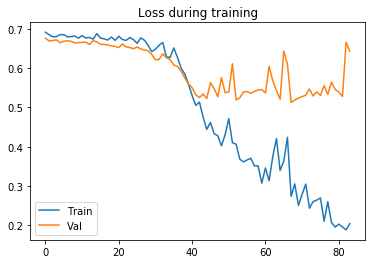

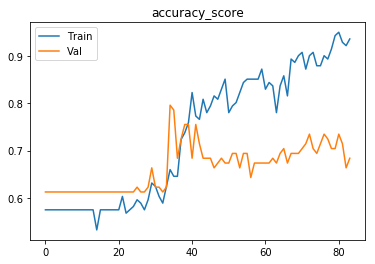

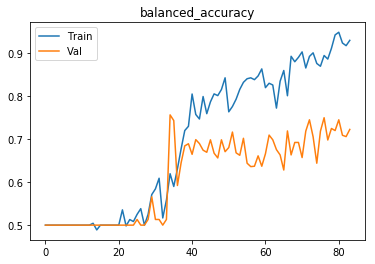

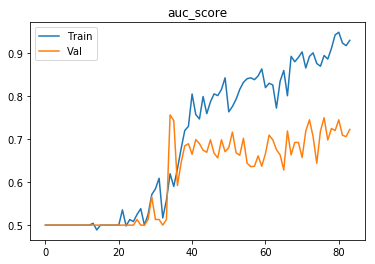

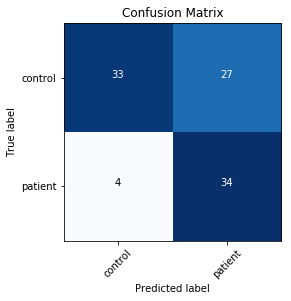

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 519979
[0,    10] loss: 0.69092
[0,    20] loss: 0.69291
Time elapsed: 0h:0m:4s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.675966
[1,    10] loss: 0.64751
[1,    20] loss: 0.73521
Time elapsed: 0h:0m:10s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.676528
[2,    10] loss: 0.68761
[2,    20] loss: 0.68353
Time elapsed: 0h:0m:16s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.677798
[3,    10] loss: 0.68139
[3,    20] loss: 0.69587
Time elapsed: 0h:0m:22s
train

val accuracy_score: 74.49 %
val balanced_accuracy: 75.31 %
val auc_score: 75.31 %
Val loss: 0.483846
[31,    10] loss: 0.43882
[31,    20] loss: 0.57762
Time elapsed: 0h:3m:24s
train accuracy_score: 75.89 %
train balanced_accuracy: 75.34 %
train auc_score: 75.34 %
val accuracy_score: 80.61 %
val balanced_accuracy: 77.41 %
val auc_score: 77.41 %
Val loss: 0.479438
[32,    10] loss: 0.46751
[32,    20] loss: 0.47824
Time elapsed: 0h:3m:30s
train accuracy_score: 81.56 %
train balanced_accuracy: 80.49 %
train auc_score: 80.49 %
val accuracy_score: 79.59 %
val balanced_accuracy: 78.99 %
val auc_score: 78.99 %
Val loss: 0.455903
[33,    10] loss: 0.42806
[33,    20] loss: 0.45307
Time elapsed: 0h:3m:36s
train accuracy_score: 79.43 %
train balanced_accuracy: 78.64 %
train auc_score: 78.64 %
val accuracy_score: 79.59 %
val balanced_accuracy: 76.10 %
val auc_score: 76.10 %
Val loss: 0.455302
[34,    10] loss: 0.42765
[34,    20] loss: 0.43845
Time elapsed: 0h:3m:42s
train accuracy_score: 80.85 

val accuracy_score: 78.57 %
val balanced_accuracy: 80.57 %
val auc_score: 80.57 %
Val loss: 0.443182
[62,    10] loss: 0.14589
[62,    20] loss: 0.14707
Time elapsed: 0h:6m:32s
train accuracy_score: 95.04 %
train balanced_accuracy: 94.81 %
train auc_score: 94.81 %
val accuracy_score: 82.65 %
val balanced_accuracy: 82.46 %
val auc_score: 82.46 %
Val loss: 0.342322
[63,    10] loss: 0.13906
[63,    20] loss: 0.11015
Time elapsed: 0h:6m:38s
train accuracy_score: 95.04 %
train balanced_accuracy: 94.81 %
train auc_score: 94.81 %
val accuracy_score: 83.67 %
val balanced_accuracy: 82.32 %
val auc_score: 82.32 %
Val loss: 0.342797
[64,    10] loss: 0.12700
[64,    20] loss: 0.06809
Time elapsed: 0h:6m:44s
train accuracy_score: 97.16 %
train balanced_accuracy: 97.31 %
train auc_score: 97.31 %
val accuracy_score: 83.67 %
val balanced_accuracy: 79.91 %
val auc_score: 79.91 %
Val loss: 0.388649
[65,    10] loss: 0.07286
[65,    20] loss: 0.08711
Time elapsed: 0h:6m:50s
train accuracy_score: 97.87 

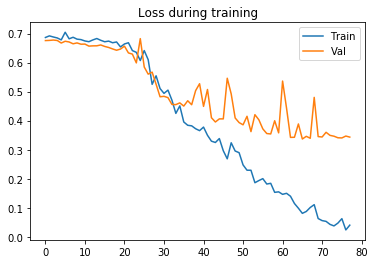

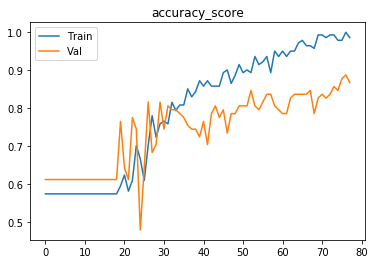

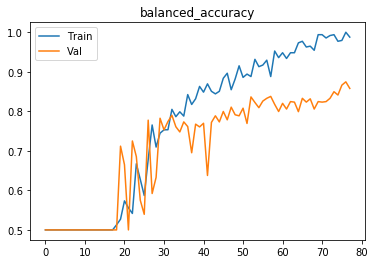

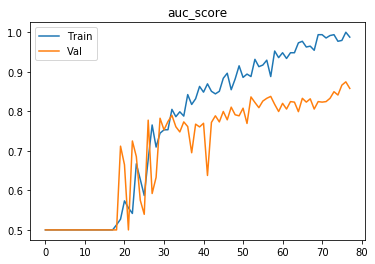

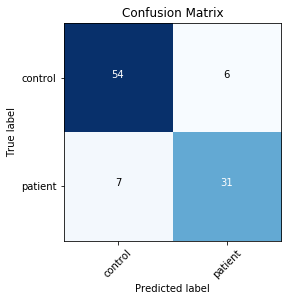

###### Starting inner fold 4
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 519979
[0,    10] loss: 0.68222
[0,    20] loss: 0.70220
Time elapsed: 0h:0m:4s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.673995
[1,    10] loss: 0.65316
[1,    20] loss: 0.70152
Time elapsed: 0h:0m:10s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.673649
[2,    10] loss: 0.69052
[2,    20] loss: 0.67831
Time elapsed: 0h:0m:16s
train accuracy_score: 57.45 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.22 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.671661
[3,    10] loss: 0.70296
[3,    20] loss: 0.67570
Time elapsed: 0h:0m:22s
trai

val accuracy_score: 70.41 %
val balanced_accuracy: 74.87 %
val auc_score: 74.87 %
Val loss: 0.616923
[31,    10] loss: 0.43965
[31,    20] loss: 0.35605
Time elapsed: 0h:3m:13s
train accuracy_score: 85.11 %
train balanced_accuracy: 84.88 %
train auc_score: 84.88 %
val accuracy_score: 75.51 %
val balanced_accuracy: 71.80 %
val auc_score: 71.80 %
Val loss: 0.484016
[32,    10] loss: 0.26299
[32,    20] loss: 0.28292
Time elapsed: 0h:3m:19s
train accuracy_score: 89.36 %
train balanced_accuracy: 89.01 %
train auc_score: 89.01 %
val accuracy_score: 78.57 %
val balanced_accuracy: 79.12 %
val auc_score: 79.12 %
Val loss: 0.443574
[33,    10] loss: 0.28463
[33,    20] loss: 0.24088
Time elapsed: 0h:3m:25s
train accuracy_score: 88.65 %
train balanced_accuracy: 88.18 %
train auc_score: 88.18 %
val accuracy_score: 73.47 %
val balanced_accuracy: 75.92 %
val auc_score: 75.92 %
Val loss: 0.517979
[34,    10] loss: 0.28972
[34,    20] loss: 0.29747
Time elapsed: 0h:3m:31s
train accuracy_score: 85.82 

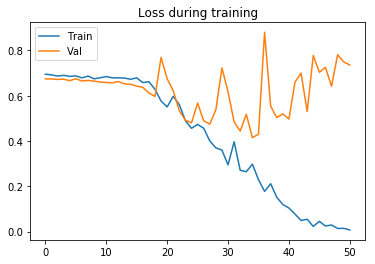

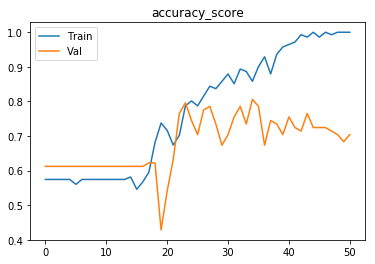

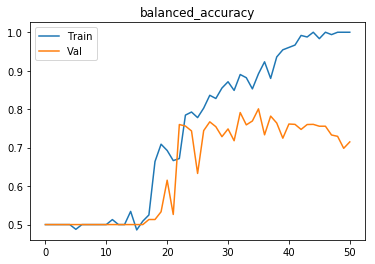

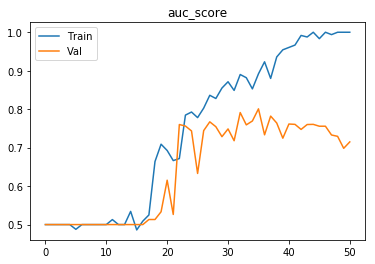

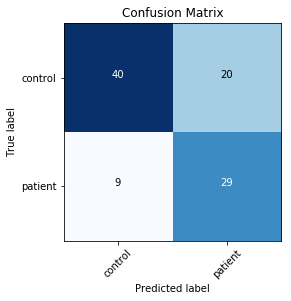

Finished outer fold.
{'final_acc': 0.8578947368421052, 'best_acc': 0.874561403508772, 'final_iter': 78, 'best_iter': 77, 'params': {'model': 'ModelBPIF', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 3}
###### Starting outer fold 4
# of patients 117, # of healthy controls 126
139
104
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 259131
[0,    10] loss: 0.69035
[0,    20] loss: 0.70417
Time elapsed: 0h:0m:2s
train accuracy_score: 50.36 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.696875
[1,    10] loss: 0.69133
[1,    20] loss: 0.69614
Time elapsed: 0h:0m:6s
train accuracy_score: 50.36 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.695491
[2,    10] loss: 0.69271
[2,    20] los

val accuracy_score: 63.46 %
val balanced_accuracy: 61.81 %
val auc_score: 61.81 %
Val loss: 0.655245
[30,    10] loss: 0.67443
[30,    20] loss: 0.67263
Time elapsed: 0h:1m:53s
train accuracy_score: 56.12 %
train balanced_accuracy: 56.31 %
train auc_score: 56.31 %
val accuracy_score: 58.65 %
val balanced_accuracy: 55.56 %
val auc_score: 55.56 %
Val loss: 0.658677
[31,    10] loss: 0.64279
[31,    20] loss: 0.62646
Time elapsed: 0h:1m:57s
train accuracy_score: 64.03 %
train balanced_accuracy: 63.98 %
train auc_score: 63.98 %
val accuracy_score: 66.35 %
val balanced_accuracy: 68.92 %
val auc_score: 68.92 %
Val loss: 0.664395
[32,    10] loss: 0.62471
[32,    20] loss: 0.66698
Time elapsed: 0h:2m:1s
train accuracy_score: 61.15 %
train balanced_accuracy: 61.16 %
train auc_score: 61.16 %
val accuracy_score: 64.42 %
val balanced_accuracy: 66.61 %
val auc_score: 66.61 %
Val loss: 0.658601
[33,    10] loss: 0.69819
[33,    20] loss: 0.63561
Time elapsed: 0h:2m:5s
train accuracy_score: 58.99 %


val accuracy_score: 67.31 %
val balanced_accuracy: 66.07 %
val auc_score: 66.07 %
Val loss: 0.536895
[61,    10] loss: 0.47723
[61,    20] loss: 0.55709
Time elapsed: 0h:3m:50s
train accuracy_score: 79.86 %
train balanced_accuracy: 79.79 %
train auc_score: 79.79 %
val accuracy_score: 70.19 %
val balanced_accuracy: 68.51 %
val auc_score: 68.51 %
Val loss: 0.536689
[62,    10] loss: 0.42980
[62,    20] loss: 0.58211
Time elapsed: 0h:3m:54s
train accuracy_score: 79.14 %
train balanced_accuracy: 79.13 %
train auc_score: 79.13 %
val accuracy_score: 68.27 %
val balanced_accuracy: 69.19 %
val auc_score: 69.19 %
Val loss: 0.538180
[63,    10] loss: 0.45962
[63,    20] loss: 0.60731
Time elapsed: 0h:3m:57s
train accuracy_score: 71.94 %
train balanced_accuracy: 72.01 %
train auc_score: 72.01 %
val accuracy_score: 72.12 %
val balanced_accuracy: 73.63 %
val auc_score: 73.63 %
Val loss: 0.557511
[64,    10] loss: 0.56331
[64,    20] loss: 0.54600
Time elapsed: 0h:4m:1s
train accuracy_score: 76.98 %

val accuracy_score: 77.88 %
val balanced_accuracy: 78.33 %
val auc_score: 78.33 %
Val loss: 0.459639
[92,    10] loss: 0.50198
[92,    20] loss: 0.41674
Time elapsed: 0h:5m:46s
train accuracy_score: 82.01 %
train balanced_accuracy: 82.00 %
train auc_score: 82.00 %
val accuracy_score: 75.00 %
val balanced_accuracy: 74.39 %
val auc_score: 74.39 %
Val loss: 0.443009
[93,    10] loss: 0.29666
[93,    20] loss: 0.52220
Time elapsed: 0h:5m:49s
train accuracy_score: 82.73 %
train balanced_accuracy: 82.73 %
train auc_score: 82.73 %
val accuracy_score: 72.12 %
val balanced_accuracy: 70.27 %
val auc_score: 70.27 %
Val loss: 0.474031
[94,    10] loss: 0.47170
[94,    20] loss: 0.34868
Time elapsed: 0h:5m:53s
train accuracy_score: 83.45 %
train balanced_accuracy: 83.43 %
train auc_score: 83.43 %
val accuracy_score: 74.04 %
val balanced_accuracy: 72.02 %
val auc_score: 72.02 %
Val loss: 0.470410
[95,    10] loss: 0.35821
[95,    20] loss: 0.42513
Time elapsed: 0h:5m:57s
train accuracy_score: 85.61 

val accuracy_score: 80.77 %
val balanced_accuracy: 79.84 %
val auc_score: 79.84 %
Val loss: 0.398313
[123,    10] loss: 0.27365
[123,    20] loss: 0.26237
Time elapsed: 0h:7m:42s
train accuracy_score: 89.93 %
train balanced_accuracy: 89.95 %
train auc_score: 89.95 %
val accuracy_score: 78.85 %
val balanced_accuracy: 77.34 %
val auc_score: 77.34 %
Val loss: 0.402762
[124,    10] loss: 0.39993
[124,    20] loss: 0.26151
Time elapsed: 0h:7m:46s
train accuracy_score: 87.05 %
train balanced_accuracy: 87.07 %
train auc_score: 87.07 %
val accuracy_score: 79.81 %
val balanced_accuracy: 78.41 %
val auc_score: 78.41 %
Val loss: 0.407344
[125,    10] loss: 0.31408
[125,    20] loss: 0.22769
Time elapsed: 0h:7m:49s
train accuracy_score: 87.05 %
train balanced_accuracy: 87.09 %
train auc_score: 87.09 %
val accuracy_score: 77.88 %
val balanced_accuracy: 78.52 %
val auc_score: 78.52 %
Val loss: 0.421168
[126,    10] loss: 0.26544
[126,    20] loss: 0.32787
Time elapsed: 0h:7m:53s
train accuracy_score

val accuracy_score: 80.77 %
val balanced_accuracy: 80.03 %
val auc_score: 80.03 %
Val loss: 0.395170
[154,    10] loss: 0.27996
[154,    20] loss: 0.21146
Time elapsed: 0h:9m:37s
train accuracy_score: 89.93 %
train balanced_accuracy: 89.95 %
train auc_score: 89.95 %
val accuracy_score: 80.77 %
val balanced_accuracy: 80.78 %
val auc_score: 80.78 %
Val loss: 0.402911
[155,    10] loss: 0.15894
[155,    20] loss: 0.22195
Time elapsed: 0h:9m:41s
train accuracy_score: 94.24 %
train balanced_accuracy: 94.28 %
train auc_score: 94.28 %
val accuracy_score: 82.69 %
val balanced_accuracy: 81.97 %
val auc_score: 81.97 %
Val loss: 0.381240
[156,    10] loss: 0.19888
[156,    20] loss: 0.20057
Time elapsed: 0h:9m:45s
train accuracy_score: 93.53 %
train balanced_accuracy: 93.50 %
train auc_score: 93.50 %
val accuracy_score: 74.04 %
val balanced_accuracy: 71.84 %
val auc_score: 71.84 %
Val loss: 0.482241
[157,    10] loss: 0.26899
[157,    20] loss: 0.22314
Time elapsed: 0h:9m:49s
train accuracy_score

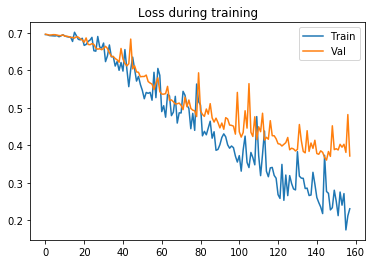

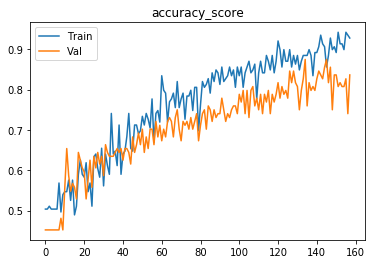

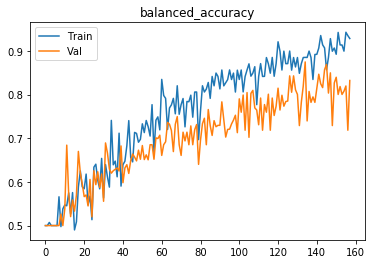

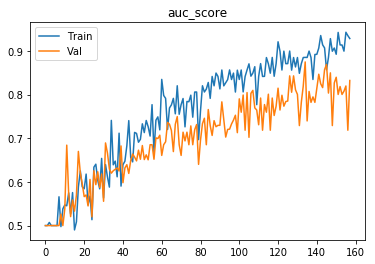

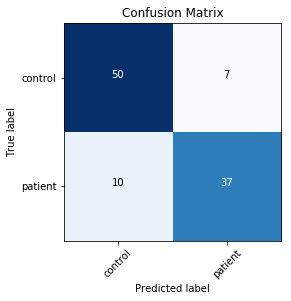

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 259131
[0,    10] loss: 0.69435
[0,    20] loss: 0.69720
Time elapsed: 0h:0m:2s
train accuracy_score: 48.92 %
train balanced_accuracy: 49.25 %
train auc_score: 49.25 %
val accuracy_score: 54.81 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.690841
[1,    10] loss: 0.68885
[1,    20] loss: 0.69636
Time elapsed: 0h:0m:6s
train accuracy_score: 45.32 %
train balanced_accuracy: 45.61 %
train auc_score: 45.61 %
val accuracy_score: 54.81 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.689000
[2,    10] loss: 0.68817
[2,    20] loss: 0.69992
Time elapsed: 0h:0m:9s
train accuracy_score: 51.80 %
train balanced_accuracy: 51.72 %
train auc_score: 51.72 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.693581
[3,    10] loss: 0.68096
[3,    20] loss: 0.70016
Time elapsed: 0h:0m:13s
train 

val accuracy_score: 75.96 %
val balanced_accuracy: 73.96 %
val auc_score: 73.96 %
Val loss: 0.473759
[31,    10] loss: 0.48546
[31,    20] loss: 0.48638
Time elapsed: 0h:1m:57s
train accuracy_score: 76.26 %
train balanced_accuracy: 76.24 %
train auc_score: 76.24 %
val accuracy_score: 77.88 %
val balanced_accuracy: 75.72 %
val auc_score: 75.72 %
Val loss: 0.483673
[32,    10] loss: 0.48459
[32,    20] loss: 0.48248
Time elapsed: 0h:2m:0s
train accuracy_score: 80.58 %
train balanced_accuracy: 80.61 %
train auc_score: 80.61 %
val accuracy_score: 76.92 %
val balanced_accuracy: 77.08 %
val auc_score: 77.08 %
Val loss: 0.429955
[33,    10] loss: 0.45527
[33,    20] loss: 0.49769
Time elapsed: 0h:2m:4s
train accuracy_score: 76.26 %
train balanced_accuracy: 76.26 %
train auc_score: 76.26 %
val accuracy_score: 75.00 %
val balanced_accuracy: 75.33 %
val auc_score: 75.33 %
Val loss: 0.426984
[34,    10] loss: 0.47001
[34,    20] loss: 0.47823
Time elapsed: 0h:2m:7s
train accuracy_score: 81.29 %
t

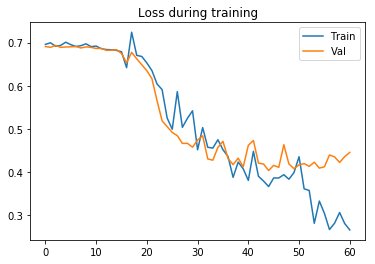

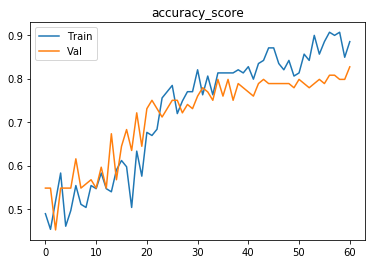

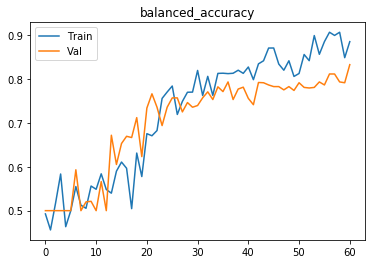

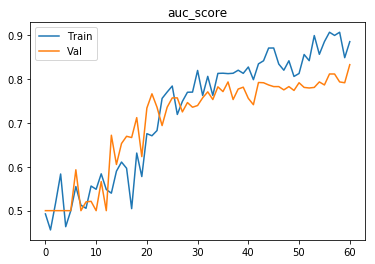

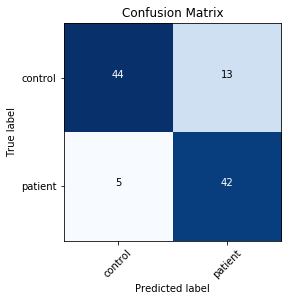

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 519979
[0,    10] loss: 0.69454
Time elapsed: 0h:0m:4s
train accuracy_score: 45.32 %
train balanced_accuracy: 45.00 %
train auc_score: 45.00 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.693198
[1,    10] loss: 0.69450
Time elapsed: 0h:0m:10s
train accuracy_score: 46.04 %
train balanced_accuracy: 45.81 %
train auc_score: 45.81 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.693999
[2,    10] loss: 0.69283
Time elapsed: 0h:0m:16s
train accuracy_score: 56.12 %
train balanced_accuracy: 55.87 %
train auc_score: 55.87 %
val accuracy_score: 58.65 %
val balanced_accuracy: 62.28 %
val auc_score: 62.28 %
Val loss: 0.692685
[3,    10] loss: 0.69096
Time elapsed: 0h:0m:22s
train accuracy_score: 57.55 %
train balanced_accuracy: 57.48 %
train auc_score: 57.48 %
val accuracy_sco

[34,    10] loss: 0.55473
Time elapsed: 0h:3m:22s
train accuracy_score: 76.26 %
train balanced_accuracy: 76.23 %
train auc_score: 76.23 %
val accuracy_score: 82.69 %
val balanced_accuracy: 81.04 %
val auc_score: 81.04 %
Val loss: 0.518684
[35,    10] loss: 0.51351
Time elapsed: 0h:3m:28s
train accuracy_score: 79.86 %
train balanced_accuracy: 79.81 %
train auc_score: 79.81 %
val accuracy_score: 74.04 %
val balanced_accuracy: 71.46 %
val auc_score: 71.46 %
Val loss: 0.507141
[36,    10] loss: 0.46690
Time elapsed: 0h:3m:34s
train accuracy_score: 75.54 %
train balanced_accuracy: 75.56 %
train auc_score: 75.56 %
val accuracy_score: 74.04 %
val balanced_accuracy: 73.52 %
val auc_score: 73.52 %
Val loss: 0.477304
[37,    10] loss: 0.52873
Time elapsed: 0h:3m:40s
train accuracy_score: 72.66 %
train balanced_accuracy: 72.68 %
train auc_score: 72.68 %
val accuracy_score: 77.88 %
val balanced_accuracy: 76.47 %
val auc_score: 76.47 %
Val loss: 0.474124
[38,    10] loss: 0.47720
Time elapsed: 0h:3

val accuracy_score: 82.69 %
val balanced_accuracy: 81.04 %
val auc_score: 81.04 %
Val loss: 0.413082
[69,    10] loss: 0.31114
Time elapsed: 0h:6m:46s
train accuracy_score: 87.05 %
train balanced_accuracy: 87.08 %
train auc_score: 87.08 %
val accuracy_score: 75.00 %
val balanced_accuracy: 75.33 %
val auc_score: 75.33 %
Val loss: 0.388442
[70,    10] loss: 0.36305
Time elapsed: 0h:6m:52s
train accuracy_score: 86.33 %
train balanced_accuracy: 86.31 %
train auc_score: 86.31 %
val accuracy_score: 84.62 %
val balanced_accuracy: 83.17 %
val auc_score: 83.17 %
Val loss: 0.388175
[71,    10] loss: 0.34448
Time elapsed: 0h:6m:58s
train accuracy_score: 87.77 %
train balanced_accuracy: 87.82 %
train auc_score: 87.82 %
val accuracy_score: 86.54 %
val balanced_accuracy: 85.85 %
val auc_score: 85.85 %
Val loss: 0.366244
[72,    10] loss: 0.34820
Time elapsed: 0h:7m:4s
train accuracy_score: 84.89 %
train balanced_accuracy: 84.90 %
train auc_score: 84.90 %
val accuracy_score: 84.62 %
val balanced_accu

[103,    10] loss: 0.21219
Time elapsed: 0h:10m:4s
train accuracy_score: 91.37 %
train balanced_accuracy: 91.38 %
train auc_score: 91.38 %
val accuracy_score: 83.65 %
val balanced_accuracy: 81.91 %
val auc_score: 81.91 %
Val loss: 0.331676
[104,    10] loss: 0.21282
Time elapsed: 0h:10m:10s
train accuracy_score: 94.24 %
train balanced_accuracy: 94.24 %
train auc_score: 94.24 %
val accuracy_score: 83.65 %
val balanced_accuracy: 81.91 %
val auc_score: 81.91 %
Val loss: 0.346717
[105,    10] loss: 0.20670
Time elapsed: 0h:10m:16s
train accuracy_score: 90.65 %
train balanced_accuracy: 90.67 %
train auc_score: 90.67 %
val accuracy_score: 87.50 %
val balanced_accuracy: 87.85 %
val auc_score: 87.85 %
Val loss: 0.284017
[106,    10] loss: 0.15871
Time elapsed: 0h:10m:21s
train accuracy_score: 93.53 %
train balanced_accuracy: 93.54 %
train auc_score: 93.54 %
val accuracy_score: 85.58 %
val balanced_accuracy: 84.23 %
val auc_score: 84.23 %
Val loss: 0.296835
[107,    10] loss: 0.16021
Time elaps

[137,    10] loss: 0.06341
Time elapsed: 0h:13m:23s
train accuracy_score: 97.84 %
train balanced_accuracy: 97.85 %
train auc_score: 97.85 %
val accuracy_score: 86.54 %
val balanced_accuracy: 85.67 %
val auc_score: 85.67 %
Val loss: 0.262019
[138,    10] loss: 0.06557
Time elapsed: 0h:13m:29s
train accuracy_score: 97.12 %
train balanced_accuracy: 97.11 %
train auc_score: 97.11 %
val accuracy_score: 85.58 %
val balanced_accuracy: 84.42 %
val auc_score: 84.42 %
Val loss: 0.340983
[139,    10] loss: 0.03452
Time elapsed: 0h:13m:35s
train accuracy_score: 99.28 %
train balanced_accuracy: 99.28 %
train auc_score: 99.28 %
val accuracy_score: 85.58 %
val balanced_accuracy: 84.60 %
val auc_score: 84.60 %
Val loss: 0.300471
[140,    10] loss: 0.04304
Time elapsed: 0h:13m:40s
train accuracy_score: 98.56 %
train balanced_accuracy: 98.57 %
train auc_score: 98.57 %
val accuracy_score: 85.58 %
val balanced_accuracy: 84.60 %
val auc_score: 84.60 %
Val loss: 0.298638
[141,    10] loss: 0.04714
Time elap

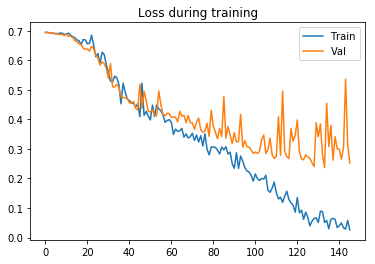

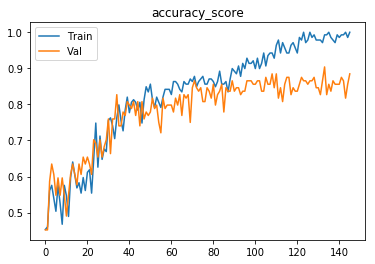

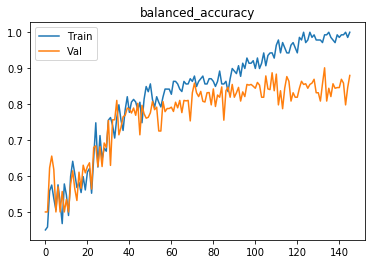

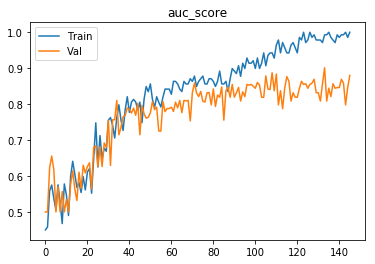

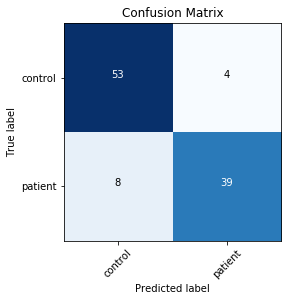

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 519979
[0,    10] loss: 0.69661
[0,    20] loss: 0.69422
Time elapsed: 0h:0m:4s
train accuracy_score: 43.88 %
train balanced_accuracy: 44.14 %
train auc_score: 44.14 %
val accuracy_score: 49.04 %
val balanced_accuracy: 52.95 %
val auc_score: 52.95 %
Val loss: 0.693290
[1,    10] loss: 0.69547
[1,    20] loss: 0.69372
Time elapsed: 0h:0m:10s
train accuracy_score: 50.36 %
train balanced_accuracy: 50.14 %
train auc_score: 50.14 %
val accuracy_score: 68.27 %
val balanced_accuracy: 65.27 %
val auc_score: 65.27 %
Val loss: 0.692806
[2,    10] loss: 0.69132
[2,    20] loss: 0.69259
Time elapsed: 0h:0m:16s
train accuracy_score: 47.48 %
train balanced_accuracy: 47.18 %
train auc_score: 47.18 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.694485
[3,    10] loss: 0.69264
[3,    20] loss: 0.69574
Time elapsed: 0h:0m:22s
train

val accuracy_score: 69.23 %
val balanced_accuracy: 67.64 %
val auc_score: 67.64 %
Val loss: 0.544650
[31,    10] loss: 0.51896
[31,    20] loss: 0.50372
Time elapsed: 0h:3m:15s
train accuracy_score: 75.54 %
train balanced_accuracy: 75.55 %
train auc_score: 75.55 %
val accuracy_score: 68.27 %
val balanced_accuracy: 67.51 %
val auc_score: 67.51 %
Val loss: 0.500950
[32,    10] loss: 0.44624
[32,    20] loss: 0.43941
Time elapsed: 0h:3m:21s
train accuracy_score: 82.73 %
train balanced_accuracy: 82.72 %
train auc_score: 82.72 %
val accuracy_score: 73.08 %
val balanced_accuracy: 73.95 %
val auc_score: 73.95 %
Val loss: 0.512308
[33,    10] loss: 0.44476
[33,    20] loss: 0.42293
Time elapsed: 0h:3m:27s
train accuracy_score: 79.86 %
train balanced_accuracy: 79.87 %
train auc_score: 79.87 %
val accuracy_score: 70.19 %
val balanced_accuracy: 71.50 %
val auc_score: 71.50 %
Val loss: 0.550945
[34,    10] loss: 0.37677
[34,    20] loss: 0.59457
Time elapsed: 0h:3m:33s
train accuracy_score: 79.86 

val accuracy_score: 82.69 %
val balanced_accuracy: 83.84 %
val auc_score: 83.84 %
Val loss: 0.510407
[62,    10] loss: 0.20783
[62,    20] loss: 0.27171
Time elapsed: 0h:6m:25s
train accuracy_score: 91.37 %
train balanced_accuracy: 91.39 %
train auc_score: 91.39 %
val accuracy_score: 82.69 %
val balanced_accuracy: 82.90 %
val auc_score: 82.90 %
Val loss: 0.426591
[63,    10] loss: 0.22026
[63,    20] loss: 0.18219
Time elapsed: 0h:6m:32s
train accuracy_score: 93.53 %
train balanced_accuracy: 93.54 %
train auc_score: 93.54 %
val accuracy_score: 78.85 %
val balanced_accuracy: 78.28 %
val auc_score: 78.28 %
Val loss: 0.395432
[64,    10] loss: 0.13678
[64,    20] loss: 0.23289
Time elapsed: 0h:6m:38s
train accuracy_score: 93.53 %
train balanced_accuracy: 93.55 %
train auc_score: 93.55 %
val accuracy_score: 84.62 %
val balanced_accuracy: 85.22 %
val auc_score: 85.22 %
Val loss: 0.437897
[65,    10] loss: 0.23166
[65,    20] loss: 0.28786
Time elapsed: 0h:6m:44s
train accuracy_score: 91.37 

val accuracy_score: 82.69 %
val balanced_accuracy: 82.53 %
val auc_score: 82.53 %
Val loss: 0.469944
[93,    10] loss: 0.01468
[93,    20] loss: 0.01799
Time elapsed: 0h:9m:37s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
train auc_score: 100.00 %
val accuracy_score: 82.69 %
val balanced_accuracy: 82.72 %
val auc_score: 82.72 %
Val loss: 0.464306
[94,    10] loss: 0.02381
[94,    20] loss: 0.03631
Time elapsed: 0h:9m:43s
train accuracy_score: 99.28 %
train balanced_accuracy: 99.28 %
train auc_score: 99.28 %
val accuracy_score: 84.62 %
val balanced_accuracy: 85.22 %
val auc_score: 85.22 %
Val loss: 0.490178
[95,    10] loss: 0.01181
[95,    20] loss: 0.04546
Time elapsed: 0h:9m:49s
train accuracy_score: 99.28 %
train balanced_accuracy: 99.29 %
train auc_score: 99.29 %
val accuracy_score: 86.54 %
val balanced_accuracy: 87.35 %
val auc_score: 87.35 %
Val loss: 0.504696
[96,    10] loss: 0.01668
[96,    20] loss: 0.02208
Time elapsed: 0h:9m:55s
train accuracy_score: 100

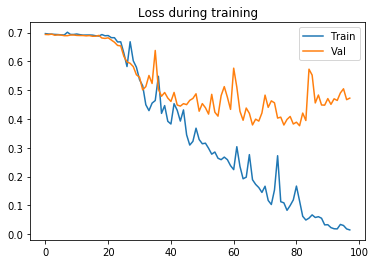

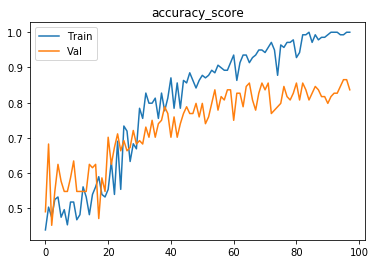

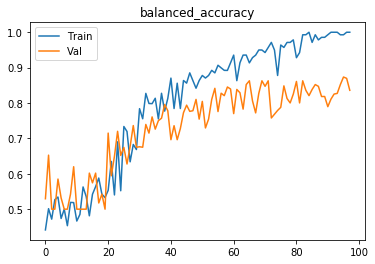

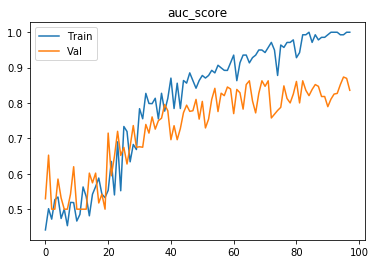

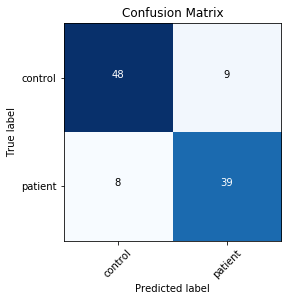

###### Starting inner fold 4
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 259131
[0,    10] loss: 0.69417
Time elapsed: 0h:0m:2s
train accuracy_score: 51.08 %
train balanced_accuracy: 50.72 %
train auc_score: 50.72 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.694529
[1,    10] loss: 0.69503
Time elapsed: 0h:0m:5s
train accuracy_score: 48.20 %
train balanced_accuracy: 47.86 %
train auc_score: 47.86 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.695097
[2,    10] loss: 0.69328
Time elapsed: 0h:0m:8s
train accuracy_score: 50.36 %
train balanced_accuracy: 50.01 %
train auc_score: 50.01 %
val accuracy_score: 45.19 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.694752
[3,    10] loss: 0.69061
Time elapsed: 0h:0m:11s
train accuracy_score: 56.12 %
train balanced_accuracy: 55.86 %
train auc_score: 55.86 %
val accuracy_score

[34,    10] loss: 0.67283
Time elapsed: 0h:1m:53s
train accuracy_score: 64.03 %
train balanced_accuracy: 63.90 %
train auc_score: 63.90 %
val accuracy_score: 64.42 %
val balanced_accuracy: 64.56 %
val auc_score: 64.56 %
Val loss: 0.680158
[35,    10] loss: 0.66638
Time elapsed: 0h:1m:57s
train accuracy_score: 61.15 %
train balanced_accuracy: 61.06 %
train auc_score: 61.06 %
val accuracy_score: 61.54 %
val balanced_accuracy: 63.98 %
val auc_score: 63.98 %
Val loss: 0.679535
[36,    10] loss: 0.67246
Time elapsed: 0h:2m:0s
train accuracy_score: 57.55 %
train balanced_accuracy: 57.44 %
train auc_score: 57.44 %
val accuracy_score: 57.69 %
val balanced_accuracy: 54.68 %
val auc_score: 54.68 %
Val loss: 0.668822
[37,    10] loss: 0.67738
Time elapsed: 0h:2m:3s
train accuracy_score: 61.15 %
train balanced_accuracy: 61.27 %
train auc_score: 61.27 %
val accuracy_score: 66.35 %
val balanced_accuracy: 65.94 %
val auc_score: 65.94 %
Val loss: 0.671427
[38,    10] loss: 0.66262
Time elapsed: 0h:2m:

val accuracy_score: 70.19 %
val balanced_accuracy: 69.45 %
val auc_score: 69.45 %
Val loss: 0.576051
[69,    10] loss: 0.60853
Time elapsed: 0h:3m:49s
train accuracy_score: 69.78 %
train balanced_accuracy: 69.93 %
train auc_score: 69.93 %
val accuracy_score: 71.15 %
val balanced_accuracy: 69.95 %
val auc_score: 69.95 %
Val loss: 0.571906
[70,    10] loss: 0.54656
Time elapsed: 0h:3m:52s
train accuracy_score: 66.91 %
train balanced_accuracy: 66.83 %
train auc_score: 66.83 %
val accuracy_score: 68.27 %
val balanced_accuracy: 69.37 %
val auc_score: 69.37 %
Val loss: 0.592320
[71,    10] loss: 0.57720
Time elapsed: 0h:3m:55s
train accuracy_score: 69.06 %
train balanced_accuracy: 69.08 %
train auc_score: 69.08 %
val accuracy_score: 67.31 %
val balanced_accuracy: 67.00 %
val auc_score: 67.00 %
Val loss: 0.571563
[72,    10] loss: 0.55396
Time elapsed: 0h:3m:58s
train accuracy_score: 72.66 %
train balanced_accuracy: 72.56 %
train auc_score: 72.56 %
val accuracy_score: 66.35 %
val balanced_acc

[103,    10] loss: 0.47813
Time elapsed: 0h:5m:40s
train accuracy_score: 78.42 %
train balanced_accuracy: 78.46 %
train auc_score: 78.46 %
val accuracy_score: 74.04 %
val balanced_accuracy: 73.89 %
val auc_score: 73.89 %
Val loss: 0.496743
[104,    10] loss: 0.44265
Time elapsed: 0h:5m:44s
train accuracy_score: 81.29 %
train balanced_accuracy: 81.27 %
train auc_score: 81.27 %
val accuracy_score: 71.15 %
val balanced_accuracy: 70.51 %
val auc_score: 70.51 %
Val loss: 0.490905
[105,    10] loss: 0.44739
Time elapsed: 0h:5m:47s
train accuracy_score: 82.01 %
train balanced_accuracy: 82.04 %
train auc_score: 82.04 %
val accuracy_score: 74.04 %
val balanced_accuracy: 73.89 %
val auc_score: 73.89 %
Val loss: 0.483586
[106,    10] loss: 0.44001
Time elapsed: 0h:5m:50s
train accuracy_score: 81.29 %
train balanced_accuracy: 81.28 %
train auc_score: 81.28 %
val accuracy_score: 74.04 %
val balanced_accuracy: 73.89 %
val auc_score: 73.89 %
Val loss: 0.479959
[107,    10] loss: 0.45765
Time elapsed:

val accuracy_score: 74.04 %
val balanced_accuracy: 73.89 %
val auc_score: 73.89 %
Val loss: 0.440721
[138,    10] loss: 0.44918
Time elapsed: 0h:7m:34s
train accuracy_score: 84.17 %
train balanced_accuracy: 84.13 %
train auc_score: 84.13 %
val accuracy_score: 73.08 %
val balanced_accuracy: 72.83 %
val auc_score: 72.83 %
Val loss: 0.447079
[139,    10] loss: 0.45905
Time elapsed: 0h:7m:37s
train accuracy_score: 81.29 %
train balanced_accuracy: 81.38 %
train auc_score: 81.38 %
val accuracy_score: 75.00 %
val balanced_accuracy: 74.02 %
val auc_score: 74.02 %
Val loss: 0.451658
[140,    10] loss: 0.40126
Time elapsed: 0h:7m:41s
train accuracy_score: 81.29 %
train balanced_accuracy: 81.27 %
train auc_score: 81.27 %
val accuracy_score: 75.00 %
val balanced_accuracy: 75.14 %
val auc_score: 75.14 %
Val loss: 0.444510
[141,    10] loss: 0.39994
Time elapsed: 0h:7m:44s
train accuracy_score: 86.33 %
train balanced_accuracy: 86.39 %
train auc_score: 86.39 %
val accuracy_score: 76.92 %
val balanced

[172,    10] loss: 0.36160
Time elapsed: 0h:9m:26s
train accuracy_score: 87.05 %
train balanced_accuracy: 87.05 %
train auc_score: 87.05 %
val accuracy_score: 78.85 %
val balanced_accuracy: 78.46 %
val auc_score: 78.46 %
Val loss: 0.417158
[173,    10] loss: 0.38076
Time elapsed: 0h:9m:29s
train accuracy_score: 84.89 %
train balanced_accuracy: 84.95 %
train auc_score: 84.95 %
val accuracy_score: 78.85 %
val balanced_accuracy: 78.65 %
val auc_score: 78.65 %
Val loss: 0.413443
[174,    10] loss: 0.32585
Time elapsed: 0h:9m:33s
train accuracy_score: 88.49 %
train balanced_accuracy: 88.46 %
train auc_score: 88.46 %
val accuracy_score: 77.88 %
val balanced_accuracy: 77.40 %
val auc_score: 77.40 %
Val loss: 0.414535
[175,    10] loss: 0.33750
Time elapsed: 0h:9m:36s
train accuracy_score: 86.33 %
train balanced_accuracy: 86.36 %
train auc_score: 86.36 %
val accuracy_score: 77.88 %
val balanced_accuracy: 77.40 %
val auc_score: 77.40 %
Val loss: 0.421333
[176,    10] loss: 0.35944
Time elapsed:

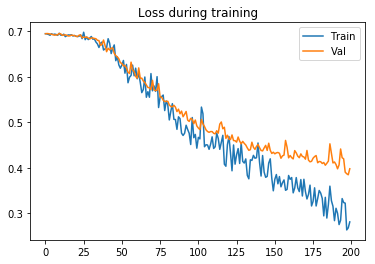

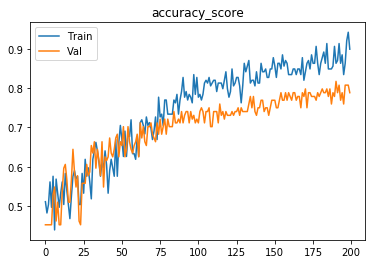

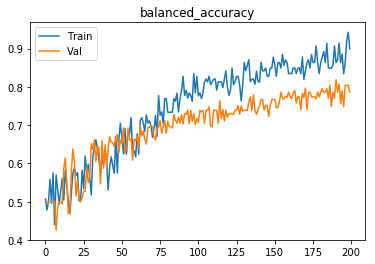

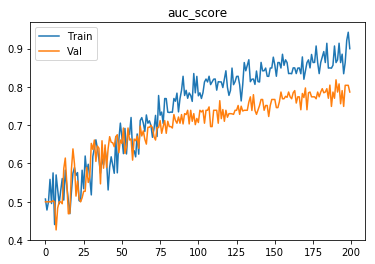

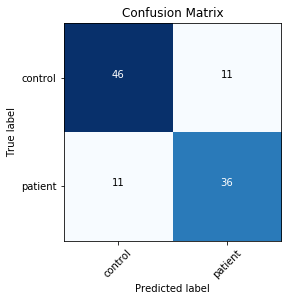

Finished outer fold.
{'final_acc': 0.879805897723031, 'best_acc': 0.9010824934677119, 'final_iter': 146, 'best_iter': 134, 'params': {'model': 'ModelBPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 2}
###### Starting outer fold 5
# of patients 125, # of healthy controls 126
136
115
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 259131
[0,    10] loss: 0.69330
[0,    20] loss: 0.69127
[0,    30] loss: 0.69858
Time elapsed: 0h:0m:2s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.18 %
train auc_score: 50.18 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.702947
[1,    10] loss: 0.67481
[1,    20] loss: 0.71179
[1,    30] loss: 0.67699
Time elapsed: 0h:0m:7s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val 

[27,    10] loss: 0.63321
[27,    20] loss: 0.66540
[27,    30] loss: 0.68192
Time elapsed: 0h:2m:6s
train accuracy_score: 60.29 %
train balanced_accuracy: 56.93 %
train auc_score: 56.93 %
val accuracy_score: 73.04 %
val balanced_accuracy: 73.10 %
val auc_score: 73.10 %
Val loss: 0.642090
[28,    10] loss: 0.59684
[28,    20] loss: 0.70183
[28,    30] loss: 0.66949
Time elapsed: 0h:2m:11s
train accuracy_score: 59.56 %
train balanced_accuracy: 58.38 %
train auc_score: 58.38 %
val accuracy_score: 63.48 %
val balanced_accuracy: 57.93 %
val auc_score: 57.93 %
Val loss: 0.619678
[29,    10] loss: 0.68008
[29,    20] loss: 0.66056
[29,    30] loss: 0.64359
Time elapsed: 0h:2m:15s
train accuracy_score: 59.56 %
train balanced_accuracy: 59.43 %
train auc_score: 59.43 %
val accuracy_score: 77.39 %
val balanced_accuracy: 80.30 %
val auc_score: 80.30 %
Val loss: 0.646597
[30,    10] loss: 0.63862
[30,    20] loss: 0.62231
[30,    30] loss: 0.65878
Time elapsed: 0h:2m:20s
train accuracy_score: 66.9

[55,    30] loss: 0.25116
Time elapsed: 0h:4m:14s
train accuracy_score: 89.71 %
train balanced_accuracy: 89.56 %
train auc_score: 89.56 %
val accuracy_score: 84.35 %
val balanced_accuracy: 85.05 %
val auc_score: 85.05 %
Val loss: 0.386954
[56,    10] loss: 0.34672
[56,    20] loss: 0.23444
[56,    30] loss: 0.29172
Time elapsed: 0h:4m:19s
train accuracy_score: 91.18 %
train balanced_accuracy: 91.05 %
train auc_score: 91.05 %
val accuracy_score: 80.00 %
val balanced_accuracy: 78.90 %
val auc_score: 78.90 %
Val loss: 0.389373
[57,    10] loss: 0.18251
[57,    20] loss: 0.33386
[57,    30] loss: 0.26908
Time elapsed: 0h:4m:24s
train accuracy_score: 92.65 %
train balanced_accuracy: 92.54 %
train auc_score: 92.54 %
val accuracy_score: 81.74 %
val balanced_accuracy: 81.46 %
val auc_score: 81.46 %
Val loss: 0.386143
[58,    10] loss: 0.20481
[58,    20] loss: 0.20969
[58,    30] loss: 0.21739
Time elapsed: 0h:4m:28s
train accuracy_score: 91.18 %
train balanced_accuracy: 91.05 %
train auc_scor

val accuracy_score: 72.17 %
val balanced_accuracy: 75.76 %
val auc_score: 75.76 %
Val loss: 0.837852
[84,    10] loss: 0.13065
[84,    20] loss: 0.08747
[84,    30] loss: 0.07847
Time elapsed: 0h:6m:27s
train accuracy_score: 94.85 %
train balanced_accuracy: 94.52 %
train auc_score: 94.52 %
val accuracy_score: 85.22 %
val balanced_accuracy: 86.33 %
val auc_score: 86.33 %
Val loss: 0.492328
Early stopping in epoch 85
Total time elapsed: 0h:6m:28s
Writing model to disk...
Best result during training: 0.87. Saving model..
Finished inner fold.


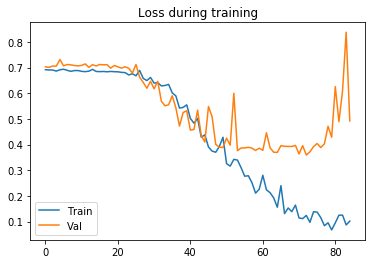

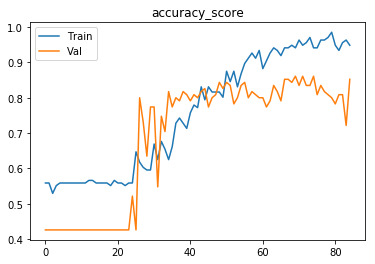

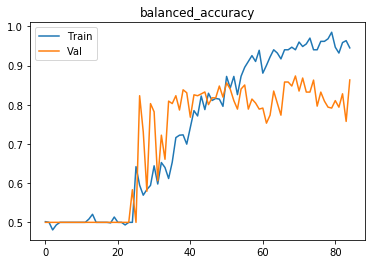

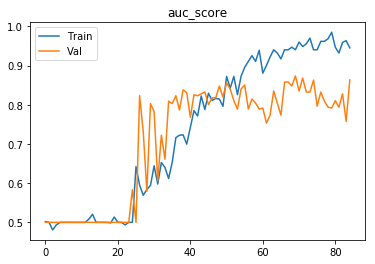

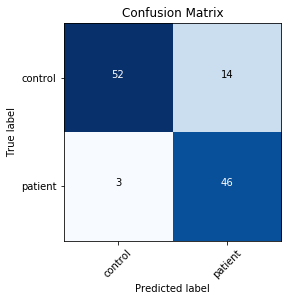

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 259131
[0,    10] loss: 0.69193
Time elapsed: 0h:0m:2s
train accuracy_score: 52.21 %
train balanced_accuracy: 52.32 %
train auc_score: 52.32 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.700153
[1,    10] loss: 0.69199
Time elapsed: 0h:0m:6s
train accuracy_score: 53.68 %
train balanced_accuracy: 48.55 %
train auc_score: 48.55 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.702765
[2,    10] loss: 0.68437
Time elapsed: 0h:0m:10s
train accuracy_score: 54.41 %
train balanced_accuracy: 48.86 %
train auc_score: 48.86 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.708895
[3,    10] loss: 0.69149
Time elapsed: 0h:0m:13s
train accuracy_score: 55.15 %
train balanced_accuracy: 49.52 %
train auc_score: 49.52 %
val accuracy_scor

[34,    10] loss: 0.68807
Time elapsed: 0h:2m:7s
train accuracy_score: 53.68 %
train balanced_accuracy: 48.55 %
train auc_score: 48.55 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.700361
[35,    10] loss: 0.68639
Time elapsed: 0h:2m:10s
train accuracy_score: 52.94 %
train balanced_accuracy: 47.37 %
train auc_score: 47.37 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.709679
[36,    10] loss: 0.68540
Time elapsed: 0h:2m:14s
train accuracy_score: 55.15 %
train balanced_accuracy: 49.34 %
train auc_score: 49.34 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.711419
[37,    10] loss: 0.69228
Time elapsed: 0h:2m:17s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.713532
[38,    10] loss: 0.68426
Time elapsed: 0h:2m

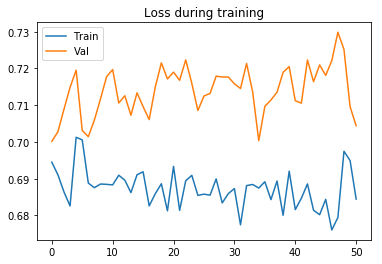

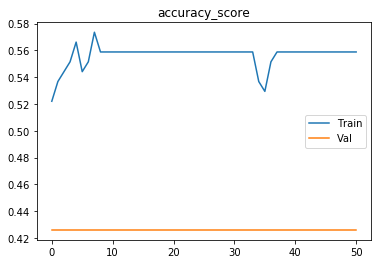

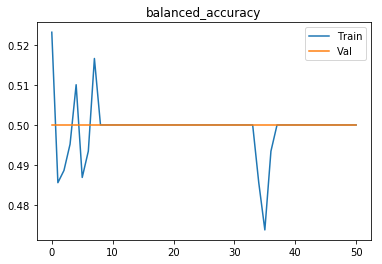

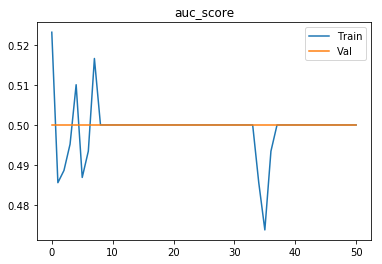

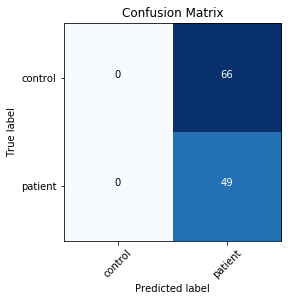

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 519979
[0,    10] loss: 0.68364
[0,    20] loss: 0.77352
Time elapsed: 0h:0m:4s
train accuracy_score: 50.74 %
train balanced_accuracy: 47.68 %
train auc_score: 47.68 %
val accuracy_score: 56.52 %
val balanced_accuracy: 49.24 %
val auc_score: 49.24 %
Val loss: 0.692776
[1,    10] loss: 0.69516
[1,    20] loss: 0.69703
Time elapsed: 0h:0m:10s
train accuracy_score: 47.06 %
train balanced_accuracy: 46.14 %
train auc_score: 46.14 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.700872
[2,    10] loss: 0.68048
[2,    20] loss: 0.69666
Time elapsed: 0h:0m:16s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.725063
[3,    10] loss: 0.68758
[3,    20] loss: 0.69297
Time elapsed: 0h:0m:23s
trai

val accuracy_score: 72.17 %
val balanced_accuracy: 68.14 %
val auc_score: 68.14 %
Val loss: 0.602012
[31,    10] loss: 0.62463
[31,    20] loss: 0.59738
Time elapsed: 0h:3m:19s
train accuracy_score: 69.85 %
train balanced_accuracy: 67.41 %
train auc_score: 67.41 %
val accuracy_score: 76.52 %
val balanced_accuracy: 76.65 %
val auc_score: 76.65 %
Val loss: 0.549805
[32,    10] loss: 0.58984
[32,    20] loss: 0.57650
Time elapsed: 0h:3m:25s
train accuracy_score: 69.12 %
train balanced_accuracy: 67.98 %
train auc_score: 67.98 %
val accuracy_score: 79.13 %
val balanced_accuracy: 80.24 %
val auc_score: 80.24 %
Val loss: 0.519455
[33,    10] loss: 0.47625
[33,    20] loss: 0.54917
Time elapsed: 0h:3m:31s
train accuracy_score: 78.68 %
train balanced_accuracy: 78.46 %
train auc_score: 78.46 %
val accuracy_score: 77.39 %
val balanced_accuracy: 77.67 %
val auc_score: 77.67 %
Val loss: 0.471177
[34,    10] loss: 0.50076
[34,    20] loss: 0.41952
Time elapsed: 0h:3m:38s
train accuracy_score: 79.41 

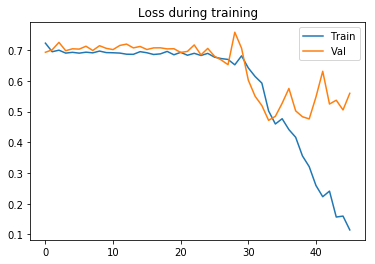

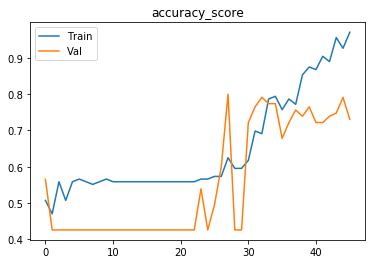

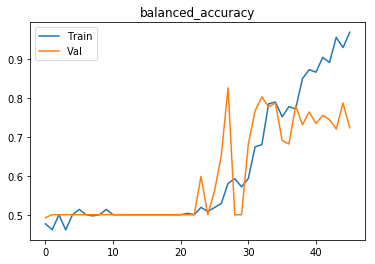

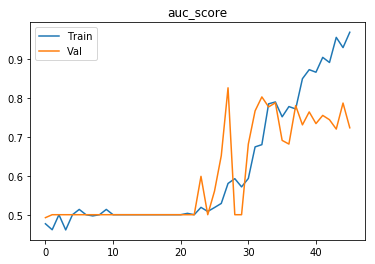

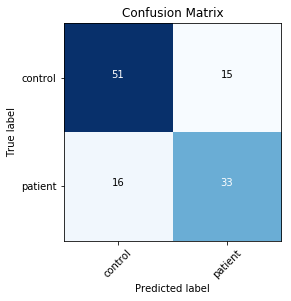

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 519979
[0,    10] loss: 0.69016
[0,    20] loss: 0.70866
[0,    30] loss: 0.69361
Time elapsed: 0h:0m:4s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.18 %
train auc_score: 50.18 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.700830
[1,    10] loss: 0.68262
[1,    20] loss: 0.70358
[1,    30] loss: 0.68844
Time elapsed: 0h:0m:11s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.717646
[2,    10] loss: 0.67360
[2,    20] loss: 0.65577
[2,    30] loss: 0.75822
Time elapsed: 0h:0m:18s
train accuracy_score: 55.88 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.695899
[3,

[28,    10] loss: 0.47874
[28,    20] loss: 0.53211
[28,    30] loss: 0.53197
Time elapsed: 0h:3m:16s
train accuracy_score: 77.94 %
train balanced_accuracy: 77.28 %
train auc_score: 77.28 %
val accuracy_score: 80.87 %
val balanced_accuracy: 79.65 %
val auc_score: 79.65 %
Val loss: 0.416442
[29,    10] loss: 0.41389
[29,    20] loss: 0.45839
[29,    30] loss: 0.61461
Time elapsed: 0h:3m:23s
train accuracy_score: 76.47 %
train balanced_accuracy: 75.44 %
train auc_score: 75.44 %
val accuracy_score: 80.87 %
val balanced_accuracy: 80.44 %
val auc_score: 80.44 %
Val loss: 0.433626
[30,    10] loss: 0.49806
[30,    20] loss: 0.53577
[30,    30] loss: 0.52258
Time elapsed: 0h:3m:30s
train accuracy_score: 77.94 %
train balanced_accuracy: 78.16 %
train auc_score: 78.16 %
val accuracy_score: 73.91 %
val balanced_accuracy: 75.17 %
val auc_score: 75.17 %
Val loss: 0.454737
[31,    10] loss: 0.36726
[31,    20] loss: 0.44852
[31,    30] loss: 0.47277
Time elapsed: 0h:3m:37s
train accuracy_score: 84.

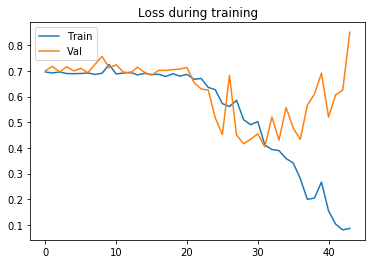

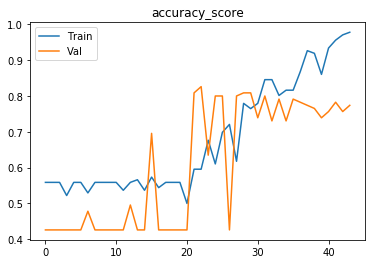

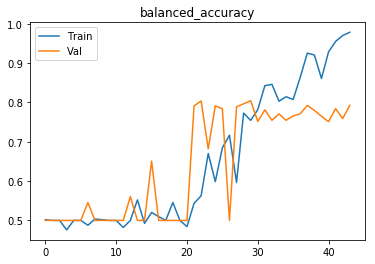

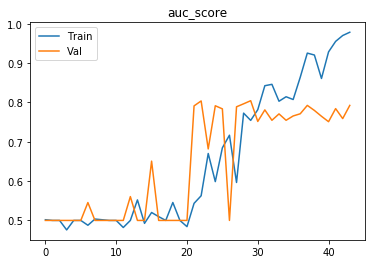

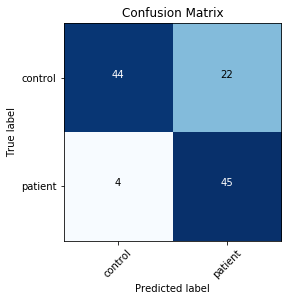

###### Starting inner fold 4
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 259131
[0,    10] loss: 0.69279
[0,    20] loss: 0.69426
Time elapsed: 0h:0m:2s
train accuracy_score: 50.00 %
train balanced_accuracy: 45.44 %
train auc_score: 45.44 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.703606
[1,    10] loss: 0.68327
[1,    20] loss: 0.69922
Time elapsed: 0h:0m:6s
train accuracy_score: 57.35 %
train balanced_accuracy: 51.84 %
train auc_score: 51.84 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.701112
[2,    10] loss: 0.69350
[2,    20] loss: 0.67272
Time elapsed: 0h:0m:10s
train accuracy_score: 55.15 %
train balanced_accuracy: 51.62 %
train auc_score: 51.62 %
val accuracy_score: 42.61 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.728918
[3,    10] loss: 0.69860
[3,    20] loss: 0.68018
Time elapsed: 0h:0m:14s
train

val accuracy_score: 66.96 %
val balanced_accuracy: 63.33 %
val auc_score: 63.33 %
Val loss: 0.637031
[31,    10] loss: 0.65730
[31,    20] loss: 0.68187
Time elapsed: 0h:2m:8s
train accuracy_score: 57.35 %
train balanced_accuracy: 54.30 %
train auc_score: 54.30 %
val accuracy_score: 78.26 %
val balanced_accuracy: 78.70 %
val auc_score: 78.70 %
Val loss: 0.639496
[32,    10] loss: 0.63428
[32,    20] loss: 0.60209
Time elapsed: 0h:2m:12s
train accuracy_score: 66.18 %
train balanced_accuracy: 65.70 %
train auc_score: 65.70 %
val accuracy_score: 74.78 %
val balanced_accuracy: 74.09 %
val auc_score: 74.09 %
Val loss: 0.601120
[33,    10] loss: 0.63271
[33,    20] loss: 0.60984
Time elapsed: 0h:2m:16s
train accuracy_score: 62.50 %
train balanced_accuracy: 60.31 %
train auc_score: 60.31 %
val accuracy_score: 66.96 %
val balanced_accuracy: 61.22 %
val auc_score: 61.22 %
Val loss: 0.588676
[34,    10] loss: 0.62300
[34,    20] loss: 0.54993
Time elapsed: 0h:2m:20s
train accuracy_score: 62.50 %

val accuracy_score: 70.43 %
val balanced_accuracy: 71.88 %
val auc_score: 71.88 %
Val loss: 0.525392
[62,    10] loss: 0.37341
[62,    20] loss: 0.35995
Time elapsed: 0h:4m:17s
train accuracy_score: 86.03 %
train balanced_accuracy: 85.39 %
train auc_score: 85.39 %
val accuracy_score: 67.83 %
val balanced_accuracy: 68.03 %
val auc_score: 68.03 %
Val loss: 0.514267
[63,    10] loss: 0.36542
[63,    20] loss: 0.38048
Time elapsed: 0h:4m:21s
train accuracy_score: 83.82 %
train balanced_accuracy: 84.30 %
train auc_score: 84.30 %
val accuracy_score: 73.91 %
val balanced_accuracy: 72.54 %
val auc_score: 72.54 %
Val loss: 0.488400
[64,    10] loss: 0.34277
[64,    20] loss: 0.38791
Time elapsed: 0h:4m:25s
train accuracy_score: 83.09 %
train balanced_accuracy: 82.24 %
train auc_score: 82.24 %
val accuracy_score: 73.91 %
val balanced_accuracy: 71.23 %
val auc_score: 71.23 %
Val loss: 0.489548
[65,    10] loss: 0.31250
[65,    20] loss: 0.32973
Time elapsed: 0h:4m:29s
train accuracy_score: 86.03 

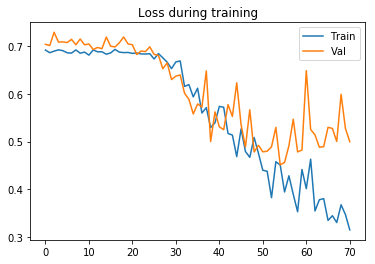

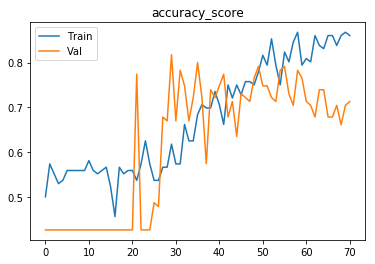

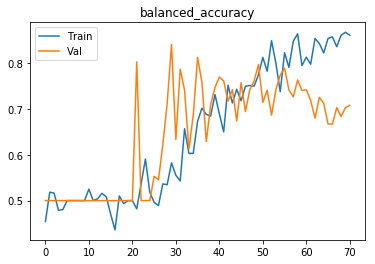

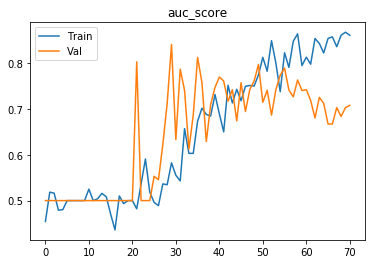

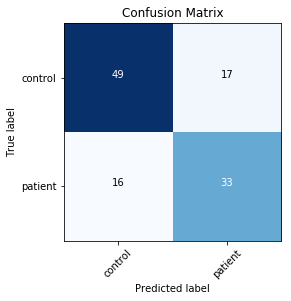

Finished outer fold.
{'final_acc': 0.8633271490414347, 'best_acc': 0.8735312306740879, 'final_iter': 85, 'best_iter': 70, 'params': {'model': 'ModelAPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 0}
###### Starting outer fold 6
# of patients 112, # of healthy controls 132
141
103
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 259131
[0,    10] loss: 0.69317
Time elapsed: 0h:0m:2s
train accuracy_score: 53.19 %
train balanced_accuracy: 52.60 %
train auc_score: 52.60 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.699351
[1,    10] loss: 0.69278
Time elapsed: 0h:0m:5s
train accuracy_score: 51.06 %
train balanced_accuracy: 50.33 %
train auc_score: 50.33 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.700853
[2,    10] loss: 0.69523
Time elapsed: 0h:0m:8s
train accuracy_score: 48.94 %
train b

val accuracy_score: 61.17 %
val balanced_accuracy: 50.46 %
val auc_score: 50.46 %
Val loss: 0.660567
[33,    10] loss: 0.68349
Time elapsed: 0h:1m:51s
train accuracy_score: 59.57 %
train balanced_accuracy: 59.66 %
train auc_score: 59.66 %
val accuracy_score: 64.08 %
val balanced_accuracy: 68.81 %
val auc_score: 68.81 %
Val loss: 0.679967
[34,    10] loss: 0.67150
Time elapsed: 0h:1m:54s
train accuracy_score: 68.09 %
train balanced_accuracy: 68.18 %
train auc_score: 68.18 %
val accuracy_score: 67.96 %
val balanced_accuracy: 60.12 %
val auc_score: 60.12 %
Val loss: 0.652111
[35,    10] loss: 0.65203
Time elapsed: 0h:1m:57s
train accuracy_score: 61.70 %
train balanced_accuracy: 61.47 %
train auc_score: 61.47 %
val accuracy_score: 71.84 %
val balanced_accuracy: 66.49 %
val auc_score: 66.49 %
Val loss: 0.642004
[36,    10] loss: 0.64489
Time elapsed: 0h:2m:0s
train accuracy_score: 58.87 %
train balanced_accuracy: 58.94 %
train auc_score: 58.94 %
val accuracy_score: 73.79 %
val balanced_accu

[67,    10] loss: 0.33082
Time elapsed: 0h:3m:43s
train accuracy_score: 89.36 %
train balanced_accuracy: 89.55 %
train auc_score: 89.55 %
val accuracy_score: 74.76 %
val balanced_accuracy: 76.17 %
val auc_score: 76.17 %
Val loss: 0.480411
[68,    10] loss: 0.32484
Time elapsed: 0h:3m:46s
train accuracy_score: 86.52 %
train balanced_accuracy: 86.56 %
train auc_score: 86.56 %
val accuracy_score: 80.58 %
val balanced_accuracy: 80.93 %
val auc_score: 80.93 %
Val loss: 0.454612
[69,    10] loss: 0.33601
Time elapsed: 0h:3m:49s
train accuracy_score: 84.40 %
train balanced_accuracy: 84.48 %
train auc_score: 84.48 %
val accuracy_score: 80.58 %
val balanced_accuracy: 80.93 %
val auc_score: 80.93 %
Val loss: 0.450026
[70,    10] loss: 0.34508
Time elapsed: 0h:3m:53s
train accuracy_score: 84.40 %
train balanced_accuracy: 84.36 %
train auc_score: 84.36 %
val accuracy_score: 74.76 %
val balanced_accuracy: 76.17 %
val auc_score: 76.17 %
Val loss: 0.467325
[71,    10] loss: 0.32010
Time elapsed: 0h:3

val accuracy_score: 83.50 %
val balanced_accuracy: 81.49 %
val auc_score: 81.49 %
Val loss: 0.419822
[102,    10] loss: 0.25510
Time elapsed: 0h:5m:38s
train accuracy_score: 87.94 %
train balanced_accuracy: 88.01 %
train auc_score: 88.01 %
val accuracy_score: 76.70 %
val balanced_accuracy: 76.85 %
val auc_score: 76.85 %
Val loss: 0.477078
[103,    10] loss: 0.16949
Time elapsed: 0h:5m:41s
train accuracy_score: 92.91 %
train balanced_accuracy: 93.03 %
train auc_score: 93.03 %
val accuracy_score: 82.52 %
val balanced_accuracy: 80.69 %
val auc_score: 80.69 %
Val loss: 0.432562
[104,    10] loss: 0.21607
Time elapsed: 0h:5m:44s
train accuracy_score: 88.65 %
train balanced_accuracy: 88.62 %
train auc_score: 88.62 %
val accuracy_score: 83.50 %
val balanced_accuracy: 81.49 %
val auc_score: 81.49 %
Val loss: 0.432201
[105,    10] loss: 0.20853
Time elapsed: 0h:5m:48s
train accuracy_score: 90.07 %
train balanced_accuracy: 90.16 %
train auc_score: 90.16 %
val accuracy_score: 70.87 %
val balanced

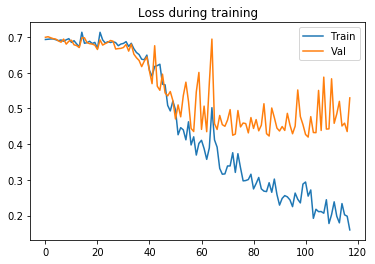

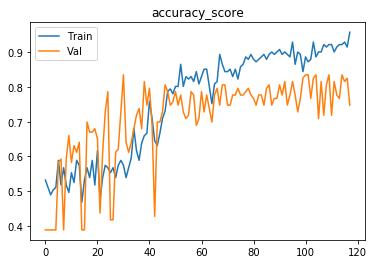

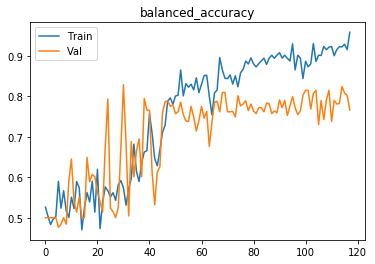

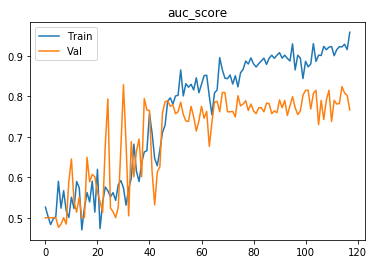

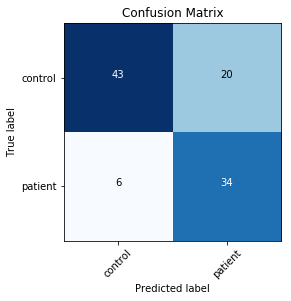

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 259131
[0,    10] loss: 0.69429
[0,    20] loss: 0.69500
[0,    30] loss: 0.69598
Time elapsed: 0h:0m:2s
train accuracy_score: 46.10 %
train balanced_accuracy: 47.07 %
train auc_score: 47.07 %
val accuracy_score: 61.17 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.688989
[1,    10] loss: 0.69798
[1,    20] loss: 0.69833
[1,    30] loss: 0.69570
Time elapsed: 0h:0m:7s
train accuracy_score: 41.13 %
train balanced_accuracy: 41.33 %
train auc_score: 41.33 %
val accuracy_score: 61.17 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.689193
[2,    10] loss: 0.68718
[2,    20] loss: 0.69864
[2,    30] loss: 0.70022
Time elapsed: 0h:0m:11s
train accuracy_score: 48.94 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 61.17 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.687058
[3,  

[28,    10] loss: 0.70129
[28,    20] loss: 0.69271
[28,    30] loss: 0.68602
Time elapsed: 0h:2m:2s
train accuracy_score: 51.77 %
train balanced_accuracy: 51.54 %
train auc_score: 51.54 %
val accuracy_score: 77.67 %
val balanced_accuracy: 73.99 %
val auc_score: 73.99 %
Val loss: 0.669690
[29,    10] loss: 0.68400
[29,    20] loss: 0.67396
[29,    30] loss: 0.68693
Time elapsed: 0h:2m:7s
train accuracy_score: 56.74 %
train balanced_accuracy: 57.16 %
train auc_score: 57.16 %
val accuracy_score: 79.61 %
val balanced_accuracy: 79.23 %
val auc_score: 79.23 %
Val loss: 0.671892
[30,    10] loss: 0.69162
[30,    20] loss: 0.66384
[30,    30] loss: 0.66322
Time elapsed: 0h:2m:11s
train accuracy_score: 64.54 %
train balanced_accuracy: 64.40 %
train auc_score: 64.40 %
val accuracy_score: 79.61 %
val balanced_accuracy: 79.23 %
val auc_score: 79.23 %
Val loss: 0.667623
[31,    10] loss: 0.65990
[31,    20] loss: 0.67320
[31,    30] loss: 0.66297
Time elapsed: 0h:2m:15s
train accuracy_score: 69.50

[56,    30] loss: 0.48879
Time elapsed: 0h:4m:2s
train accuracy_score: 80.85 %
train balanced_accuracy: 80.95 %
train auc_score: 80.95 %
val accuracy_score: 76.70 %
val balanced_accuracy: 75.93 %
val auc_score: 75.93 %
Val loss: 0.551640
[57,    10] loss: 0.40723
[57,    20] loss: 0.46871
[57,    30] loss: 0.36976
Time elapsed: 0h:4m:6s
train accuracy_score: 86.52 %
train balanced_accuracy: 86.56 %
train auc_score: 86.56 %
val accuracy_score: 79.61 %
val balanced_accuracy: 78.31 %
val auc_score: 78.31 %
Val loss: 0.542317
[58,    10] loss: 0.30210
[58,    20] loss: 0.50860
[58,    30] loss: 0.36546
Time elapsed: 0h:4m:10s
train accuracy_score: 82.98 %
train balanced_accuracy: 83.06 %
train auc_score: 83.06 %
val accuracy_score: 79.61 %
val balanced_accuracy: 77.86 %
val auc_score: 77.86 %
Val loss: 0.504329
[59,    10] loss: 0.39364
[59,    20] loss: 0.52844
[59,    30] loss: 0.43225
Time elapsed: 0h:4m:14s
train accuracy_score: 84.40 %
train balanced_accuracy: 84.51 %
train auc_score:

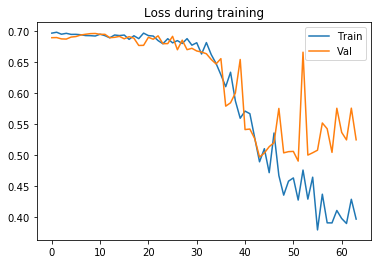

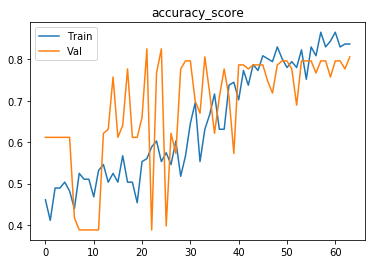

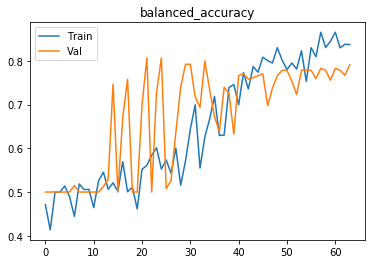

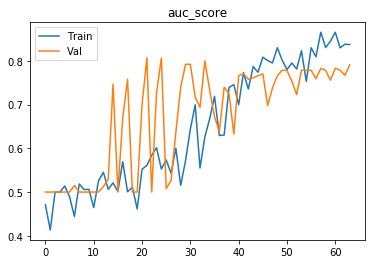

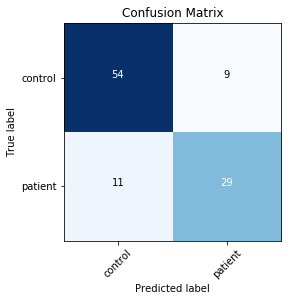

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 519979
[0,    10] loss: 0.69466
Time elapsed: 0h:0m:4s
train accuracy_score: 51.77 %
train balanced_accuracy: 51.18 %
train auc_score: 51.18 %
val accuracy_score: 47.57 %
val balanced_accuracy: 55.77 %
val auc_score: 55.77 %
Val loss: 0.693007
[1,    10] loss: 0.69372
Time elapsed: 0h:0m:9s
train accuracy_score: 46.81 %
train balanced_accuracy: 46.07 %
train auc_score: 46.07 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.697818
[2,    10] loss: 0.69175
Time elapsed: 0h:0m:15s
train accuracy_score: 51.06 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.698876
[3,    10] loss: 0.69078
Time elapsed: 0h:0m:21s
train accuracy_score: 52.48 %
train balanced_accuracy: 51.57 %
train auc_score: 51.57 %
val accuracy_scor

[34,    10] loss: 0.57897
Time elapsed: 0h:3m:23s
train accuracy_score: 72.34 %
train balanced_accuracy: 72.43 %
train auc_score: 72.43 %
val accuracy_score: 66.99 %
val balanced_accuracy: 70.28 %
val auc_score: 70.28 %
Val loss: 0.573419
[35,    10] loss: 0.54193
Time elapsed: 0h:3m:29s
train accuracy_score: 76.60 %
train balanced_accuracy: 76.84 %
train auc_score: 76.84 %
val accuracy_score: 70.87 %
val balanced_accuracy: 72.08 %
val auc_score: 72.08 %
Val loss: 0.527905
[36,    10] loss: 0.48644
Time elapsed: 0h:3m:35s
train accuracy_score: 76.60 %
train balanced_accuracy: 76.69 %
train auc_score: 76.69 %
val accuracy_score: 66.02 %
val balanced_accuracy: 69.94 %
val auc_score: 69.94 %
Val loss: 0.588039
[37,    10] loss: 0.56317
Time elapsed: 0h:3m:41s
train accuracy_score: 71.63 %
train balanced_accuracy: 71.80 %
train auc_score: 71.80 %
val accuracy_score: 70.87 %
val balanced_accuracy: 75.28 %
val auc_score: 75.28 %
Val loss: 0.567880
[38,    10] loss: 0.47009
Time elapsed: 0h:3

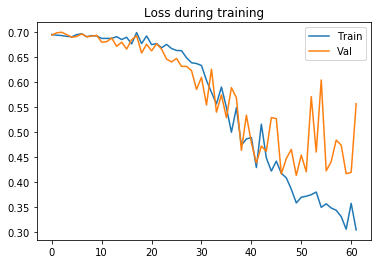

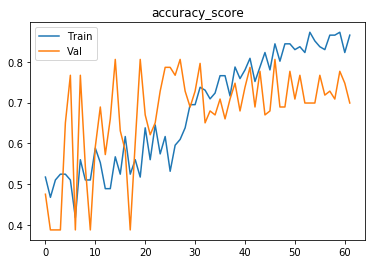

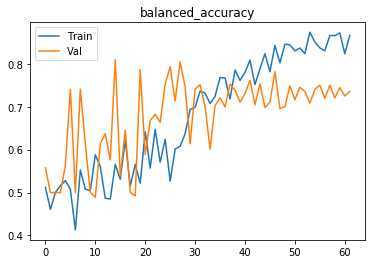

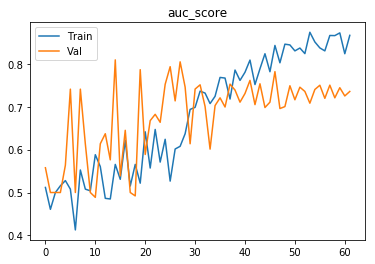

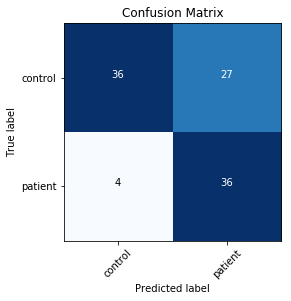

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 519979
[0,    10] loss: 0.69269
[0,    20] loss: 0.69731
[0,    30] loss: 0.68923
Time elapsed: 0h:0m:4s
train accuracy_score: 51.77 %
train balanced_accuracy: 50.88 %
train auc_score: 50.88 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.698089
[1,    10] loss: 0.68958
[1,    20] loss: 0.68885
[1,    30] loss: 0.69335
Time elapsed: 0h:0m:11s
train accuracy_score: 51.06 %
train balanced_accuracy: 50.30 %
train auc_score: 50.30 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.694799
[2,    10] loss: 0.69361
[2,    20] loss: 0.69883
[2,    30] loss: 0.69737
Time elapsed: 0h:0m:18s
train accuracy_score: 46.10 %
train balanced_accuracy: 47.07 %
train auc_score: 47.07 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.695674
[3, 

[28,    10] loss: 0.34644
[28,    20] loss: 0.38595
[28,    30] loss: 0.35504
Time elapsed: 0h:3m:15s
train accuracy_score: 80.14 %
train balanced_accuracy: 80.31 %
train auc_score: 80.31 %
val accuracy_score: 80.58 %
val balanced_accuracy: 79.11 %
val auc_score: 79.11 %
Val loss: 0.541655
[29,    10] loss: 0.25573
[29,    20] loss: 0.26486
[29,    30] loss: 0.44236
Time elapsed: 0h:3m:21s
train accuracy_score: 84.40 %
train balanced_accuracy: 84.51 %
train auc_score: 84.51 %
val accuracy_score: 36.89 %
val balanced_accuracy: 47.50 %
val auc_score: 47.50 %
Val loss: 1.247535
[30,    10] loss: 0.51371
[30,    20] loss: 0.31347
[30,    30] loss: 0.30325
Time elapsed: 0h:3m:28s
train accuracy_score: 85.11 %
train balanced_accuracy: 85.02 %
train auc_score: 85.02 %
val accuracy_score: 79.61 %
val balanced_accuracy: 78.31 %
val auc_score: 78.31 %
Val loss: 0.532299
[31,    10] loss: 0.28375
[31,    20] loss: 0.31865
[31,    30] loss: 0.35212
Time elapsed: 0h:3m:35s
train accuracy_score: 89.

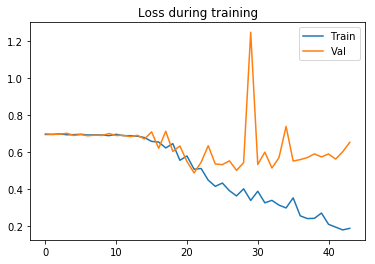

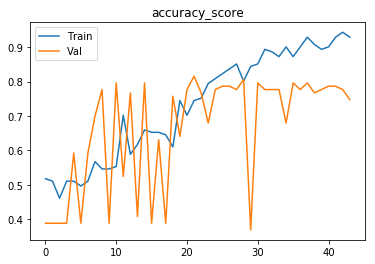

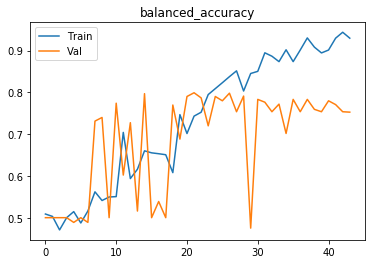

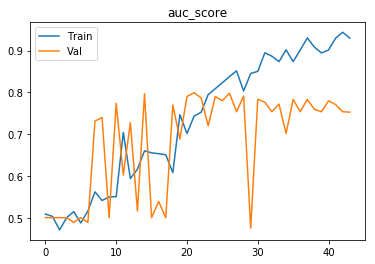

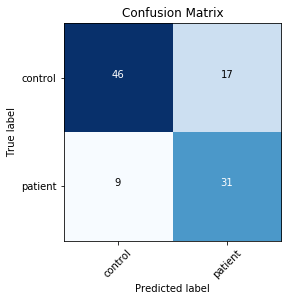

###### Starting inner fold 4
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 259131
[0,    10] loss: 0.69152
Time elapsed: 0h:0m:1s
train accuracy_score: 51.06 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.705678
[1,    10] loss: 0.69037
Time elapsed: 0h:0m:5s
train accuracy_score: 51.77 %
train balanced_accuracy: 50.72 %
train auc_score: 50.72 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.707371
[2,    10] loss: 0.69293
Time elapsed: 0h:0m:8s
train accuracy_score: 53.90 %
train balanced_accuracy: 53.26 %
train auc_score: 53.26 %
val accuracy_score: 38.83 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.694790
[3,    10] loss: 0.69654
Time elapsed: 0h:0m:11s
train accuracy_score: 53.19 %
train balanced_accuracy: 52.99 %
train auc_score: 52.99 %
val accuracy_score

[34,    10] loss: 0.67716
Time elapsed: 0h:1m:53s
train accuracy_score: 60.28 %
train balanced_accuracy: 60.05 %
train auc_score: 60.05 %
val accuracy_score: 77.67 %
val balanced_accuracy: 74.44 %
val auc_score: 74.44 %
Val loss: 0.673332
[35,    10] loss: 0.68786
Time elapsed: 0h:1m:57s
train accuracy_score: 54.61 %
train balanced_accuracy: 54.35 %
train auc_score: 54.35 %
val accuracy_score: 74.76 %
val balanced_accuracy: 70.69 %
val auc_score: 70.69 %
Val loss: 0.671200
[36,    10] loss: 0.66635
Time elapsed: 0h:2m:0s
train accuracy_score: 63.12 %
train balanced_accuracy: 62.77 %
train auc_score: 62.77 %
val accuracy_score: 78.64 %
val balanced_accuracy: 78.89 %
val auc_score: 78.89 %
Val loss: 0.673520
[37,    10] loss: 0.69026
Time elapsed: 0h:2m:3s
train accuracy_score: 56.74 %
train balanced_accuracy: 56.55 %
train auc_score: 56.55 %
val accuracy_score: 78.64 %
val balanced_accuracy: 77.52 %
val auc_score: 77.52 %
Val loss: 0.669937
[38,    10] loss: 0.68114
Time elapsed: 0h:2m:

val accuracy_score: 68.93 %
val balanced_accuracy: 70.95 %
val auc_score: 70.95 %
Val loss: 0.529955
[69,    10] loss: 0.45346
Time elapsed: 0h:3m:47s
train accuracy_score: 80.85 %
train balanced_accuracy: 80.83 %
train auc_score: 80.83 %
val accuracy_score: 69.90 %
val balanced_accuracy: 71.29 %
val auc_score: 71.29 %
Val loss: 0.511832
[70,    10] loss: 0.47032
Time elapsed: 0h:3m:50s
train accuracy_score: 81.56 %
train balanced_accuracy: 81.43 %
train auc_score: 81.43 %
val accuracy_score: 77.67 %
val balanced_accuracy: 74.44 %
val auc_score: 74.44 %
Val loss: 0.474812
[71,    10] loss: 0.46048
Time elapsed: 0h:3m:53s
train accuracy_score: 78.01 %
train balanced_accuracy: 78.14 %
train auc_score: 78.14 %
val accuracy_score: 69.90 %
val balanced_accuracy: 71.29 %
val auc_score: 71.29 %
Val loss: 0.518521
[72,    10] loss: 0.41640
Time elapsed: 0h:3m:57s
train accuracy_score: 82.27 %
train balanced_accuracy: 82.31 %
train auc_score: 82.31 %
val accuracy_score: 66.99 %
val balanced_acc

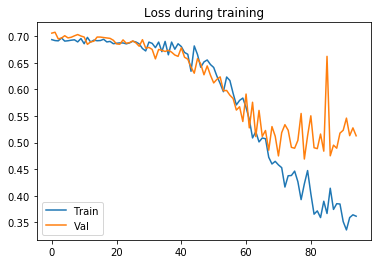

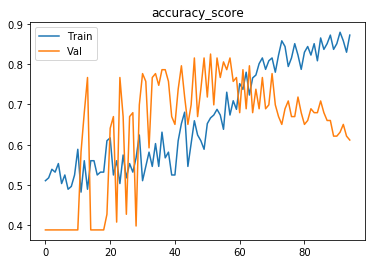

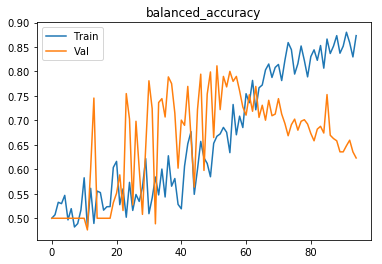

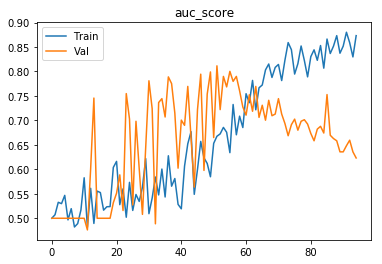

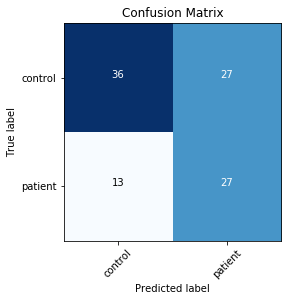

Finished outer fold.
{'final_acc': 0.7910714285714285, 'best_acc': 0.8001984126984127, 'final_iter': 64, 'best_iter': 25, 'params': {'model': 'ModelAPIF', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 1}
###### Starting outer fold 7
# of patients 116, # of healthy controls 118
140
94
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 259131
[0,    10] loss: 0.68887
[0,    20] loss: 0.69638
[0,    30] loss: 0.68209
Time elapsed: 0h:0m:2s
train accuracy_score: 53.57 %
train balanced_accuracy: 50.92 %
train auc_score: 50.92 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.697102
[1,    10] loss: 0.68171
[1,    20] loss: 0.69666
[1,    30] loss: 0.70331
Time elapsed: 0h:0m:7s
train accuracy_score: 47.14 %
train balanced_accuracy: 45.82 %
train auc_score: 45.82 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss

[27,    10] loss: 0.65354
[27,    20] loss: 0.66017
[27,    30] loss: 0.71903
Time elapsed: 0h:1m:59s
train accuracy_score: 57.14 %
train balanced_accuracy: 54.79 %
train auc_score: 54.79 %
val accuracy_score: 65.96 %
val balanced_accuracy: 66.25 %
val auc_score: 66.25 %
Val loss: 0.682320
[28,    10] loss: 0.68070
[28,    20] loss: 0.66966
[28,    30] loss: 0.64014
Time elapsed: 0h:2m:4s
train accuracy_score: 67.14 %
train balanced_accuracy: 67.20 %
train auc_score: 67.20 %
val accuracy_score: 69.15 %
val balanced_accuracy: 69.14 %
val auc_score: 69.14 %
Val loss: 0.674938
[29,    10] loss: 0.68604
[29,    20] loss: 0.72271
[29,    30] loss: 0.64487
Time elapsed: 0h:2m:8s
train accuracy_score: 57.86 %
train balanced_accuracy: 57.84 %
train auc_score: 57.84 %
val accuracy_score: 62.77 %
val balanced_accuracy: 63.60 %
val auc_score: 63.60 %
Val loss: 0.678435
[30,    10] loss: 0.65763
[30,    20] loss: 0.70686
[30,    30] loss: 0.66188
Time elapsed: 0h:2m:13s
train accuracy_score: 53.57

[55,    30] loss: 0.38941
Time elapsed: 0h:4m:0s
train accuracy_score: 82.86 %
train balanced_accuracy: 82.96 %
train auc_score: 82.96 %
val accuracy_score: 71.28 %
val balanced_accuracy: 70.38 %
val auc_score: 70.38 %
Val loss: 0.578562
[56,    10] loss: 0.46459
[56,    20] loss: 0.31432
[56,    30] loss: 0.30452
Time elapsed: 0h:4m:5s
train accuracy_score: 83.57 %
train balanced_accuracy: 83.89 %
train auc_score: 83.89 %
val accuracy_score: 70.21 %
val balanced_accuracy: 68.96 %
val auc_score: 68.96 %
Val loss: 0.611834
[57,    10] loss: 0.36620
[57,    20] loss: 0.39532
[57,    30] loss: 0.47533
Time elapsed: 0h:4m:10s
train accuracy_score: 83.57 %
train balanced_accuracy: 83.64 %
train auc_score: 83.64 %
val accuracy_score: 71.28 %
val balanced_accuracy: 71.06 %
val auc_score: 71.06 %
Val loss: 0.624905
[58,    10] loss: 0.29008
[58,    20] loss: 0.39656
[58,    30] loss: 0.59684
Time elapsed: 0h:4m:14s
train accuracy_score: 82.86 %
train balanced_accuracy: 82.96 %
train auc_score:

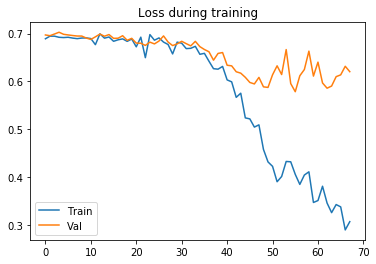

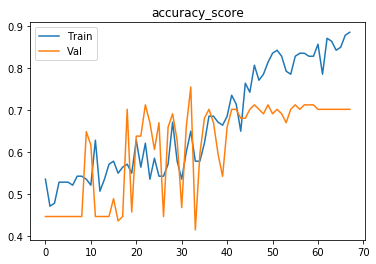

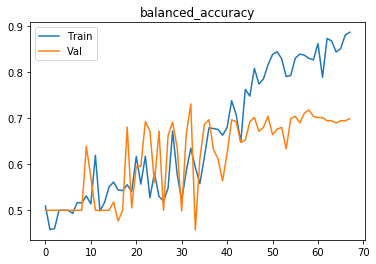

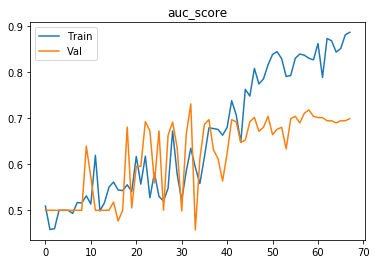

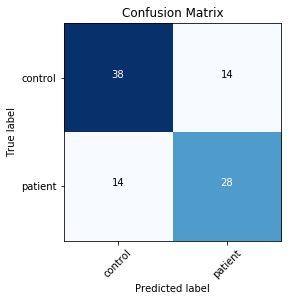

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 259131
[0,    10] loss: 0.69801
[0,    20] loss: 0.69663
Time elapsed: 0h:0m:2s
train accuracy_score: 40.71 %
train balanced_accuracy: 40.56 %
train auc_score: 40.56 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.693676
[1,    10] loss: 0.69443
[1,    20] loss: 0.69488
Time elapsed: 0h:0m:6s
train accuracy_score: 47.86 %
train balanced_accuracy: 48.22 %
train auc_score: 48.22 %
val accuracy_score: 55.32 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.692437
[2,    10] loss: 0.69132
[2,    20] loss: 0.68731
Time elapsed: 0h:0m:9s
train accuracy_score: 59.29 %
train balanced_accuracy: 58.21 %
train auc_score: 58.21 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.696441
[3,    10] loss: 0.68173
[3,    20] loss: 0.70107
Time elapsed: 0h:0m:13s
train a

val accuracy_score: 59.57 %
val balanced_accuracy: 59.57 %
val auc_score: 59.57 %
Val loss: 0.681268
[31,    10] loss: 0.65901
[31,    20] loss: 0.70395
Time elapsed: 0h:2m:5s
train accuracy_score: 62.14 %
train balanced_accuracy: 61.73 %
train auc_score: 61.73 %
val accuracy_score: 59.57 %
val balanced_accuracy: 59.57 %
val auc_score: 59.57 %
Val loss: 0.678920
[32,    10] loss: 0.68345
[32,    20] loss: 0.65183
Time elapsed: 0h:2m:9s
train accuracy_score: 57.86 %
train balanced_accuracy: 56.78 %
train auc_score: 56.78 %
val accuracy_score: 53.19 %
val balanced_accuracy: 57.46 %
val auc_score: 57.46 %
Val loss: 0.685997
[33,    10] loss: 0.68296
[33,    20] loss: 0.66875
Time elapsed: 0h:2m:12s
train accuracy_score: 60.00 %
train balanced_accuracy: 59.62 %
train auc_score: 59.62 %
val accuracy_score: 63.83 %
val balanced_accuracy: 59.52 %
val auc_score: 59.52 %
Val loss: 0.671816
[34,    10] loss: 0.66453
[34,    20] loss: 0.66990
Time elapsed: 0h:2m:16s
train accuracy_score: 61.43 %


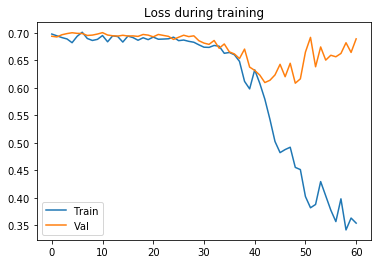

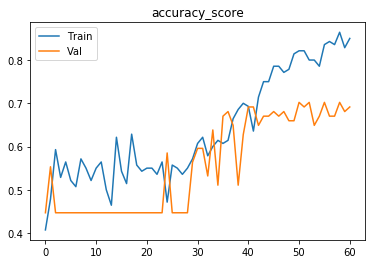

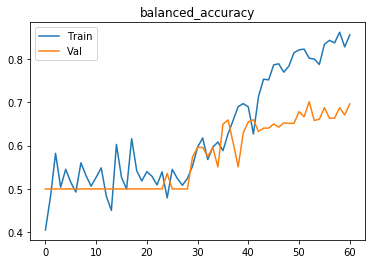

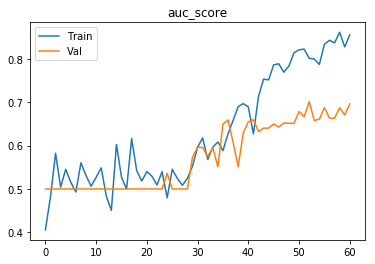

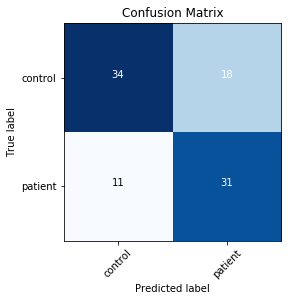

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 519979
[0,    10] loss: 0.68119
[0,    20] loss: 0.70055
[0,    30] loss: 0.70890
Time elapsed: 0h:0m:4s
train accuracy_score: 54.29 %
train balanced_accuracy: 51.76 %
train auc_score: 51.76 %
val accuracy_score: 55.32 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.690809
[1,    10] loss: 0.69086
[1,    20] loss: 0.70284
[1,    30] loss: 0.70630
Time elapsed: 0h:0m:11s
train accuracy_score: 48.57 %
train balanced_accuracy: 48.65 %
train auc_score: 48.65 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.693792
[2,    10] loss: 0.69239
[2,    20] loss: 0.69506
[2,    30] loss: 0.69434
Time elapsed: 0h:0m:18s
train accuracy_score: 54.29 %
train balanced_accuracy: 51.68 %
train auc_score: 51.68 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.694266
[3,

[28,    10] loss: 0.13577
[28,    20] loss: 0.15859
[28,    30] loss: 0.20997
Time elapsed: 0h:3m:10s
train accuracy_score: 94.29 %
train balanced_accuracy: 94.27 %
train auc_score: 94.27 %
val accuracy_score: 79.79 %
val balanced_accuracy: 77.84 %
val auc_score: 77.84 %
Val loss: 0.888029
[29,    10] loss: 0.07831
[29,    20] loss: 0.06715
[29,    30] loss: 0.13835
Time elapsed: 0h:3m:17s
train accuracy_score: 95.71 %
train balanced_accuracy: 95.86 %
train auc_score: 95.86 %
val accuracy_score: 73.40 %
val balanced_accuracy: 73.44 %
val auc_score: 73.44 %
Val loss: 0.831685
[30,    10] loss: 0.15002
[30,    20] loss: 0.05407
[30,    30] loss: 0.06653
Time elapsed: 0h:3m:24s
train accuracy_score: 96.43 %
train balanced_accuracy: 96.38 %
train auc_score: 96.38 %
val accuracy_score: 79.79 %
val balanced_accuracy: 78.53 %
val auc_score: 78.53 %
Val loss: 0.832085
[31,    10] loss: 0.06316
[31,    20] loss: 0.08920
[31,    30] loss: 0.04062
Time elapsed: 0h:3m:30s
train accuracy_score: 98.

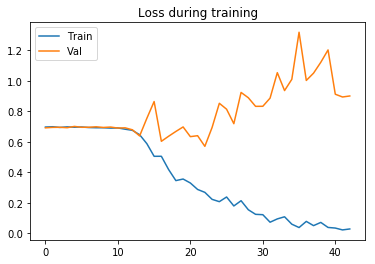

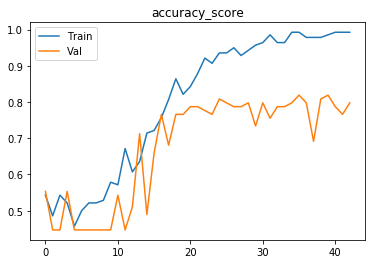

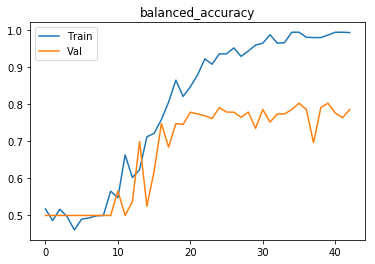

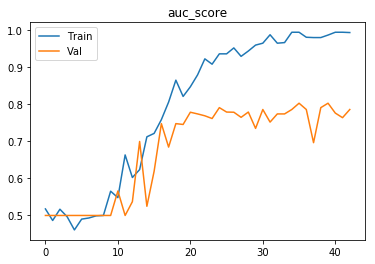

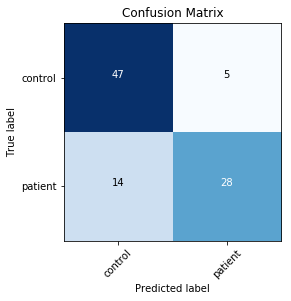

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 519979
[0,    10] loss: 0.69765
[0,    20] loss: 0.69002
[0,    30] loss: 0.70164
Time elapsed: 0h:0m:4s
train accuracy_score: 50.71 %
train balanced_accuracy: 49.77 %
train auc_score: 49.77 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.701777
[1,    10] loss: 0.70443
[1,    20] loss: 0.69861
[1,    30] loss: 0.69237
Time elapsed: 0h:0m:11s
train accuracy_score: 42.14 %
train balanced_accuracy: 41.42 %
train auc_score: 41.42 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.694715
[2,    10] loss: 0.69315
[2,    20] loss: 0.69338
[2,    30] loss: 0.70222
Time elapsed: 0h:0m:18s
train accuracy_score: 48.57 %
train balanced_accuracy: 47.01 %
train auc_score: 47.01 %
val accuracy_score: 55.32 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.691441
[3, 

[28,    10] loss: 0.43102
[28,    20] loss: 0.33095
[28,    30] loss: 0.27630
Time elapsed: 0h:3m:9s
train accuracy_score: 85.00 %
train balanced_accuracy: 85.07 %
train auc_score: 85.07 %
val accuracy_score: 77.66 %
val balanced_accuracy: 76.14 %
val auc_score: 76.14 %
Val loss: 0.595097
[29,    10] loss: 0.31300
[29,    20] loss: 0.26253
[29,    30] loss: 0.28570
Time elapsed: 0h:3m:16s
train accuracy_score: 89.29 %
train balanced_accuracy: 89.46 %
train auc_score: 89.46 %
val accuracy_score: 77.66 %
val balanced_accuracy: 75.69 %
val auc_score: 75.69 %
Val loss: 0.657816
[30,    10] loss: 0.46835
[30,    20] loss: 0.23297
[30,    30] loss: 0.27247
Time elapsed: 0h:3m:23s
train accuracy_score: 86.43 %
train balanced_accuracy: 86.59 %
train auc_score: 86.59 %
val accuracy_score: 73.40 %
val balanced_accuracy: 73.44 %
val auc_score: 73.44 %
Val loss: 0.566340
[31,    10] loss: 0.21511
[31,    20] loss: 0.29193
[31,    30] loss: 0.34157
Time elapsed: 0h:3m:29s
train accuracy_score: 90.7

[56,    30] loss: 0.13416
Time elapsed: 0h:6m:15s
train accuracy_score: 95.71 %
train balanced_accuracy: 95.70 %
train auc_score: 95.70 %
val accuracy_score: 75.53 %
val balanced_accuracy: 75.37 %
val auc_score: 75.37 %
Val loss: 0.563398
[57,    10] loss: 0.07558
[57,    20] loss: 0.07939
[57,    30] loss: 0.04055
Time elapsed: 0h:6m:22s
train accuracy_score: 99.29 %
train balanced_accuracy: 99.32 %
train auc_score: 99.32 %
val accuracy_score: 76.60 %
val balanced_accuracy: 76.10 %
val auc_score: 76.10 %
Val loss: 0.594275
[58,    10] loss: 0.02789
[58,    20] loss: 0.02378
[58,    30] loss: 0.11214
Time elapsed: 0h:6m:28s
train accuracy_score: 97.14 %
train balanced_accuracy: 97.22 %
train auc_score: 97.22 %
val accuracy_score: 75.53 %
val balanced_accuracy: 75.37 %
val auc_score: 75.37 %
Val loss: 0.594711
[59,    10] loss: 0.04164
[59,    20] loss: 0.15284
[59,    30] loss: 0.14497
Time elapsed: 0h:6m:35s
train accuracy_score: 95.71 %
train balanced_accuracy: 95.62 %
train auc_scor

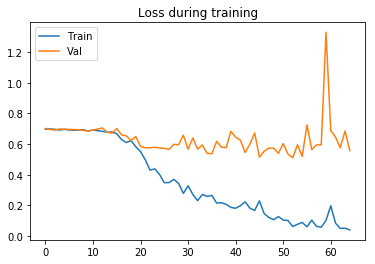

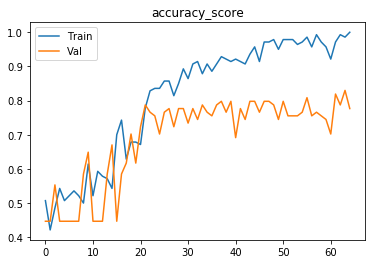

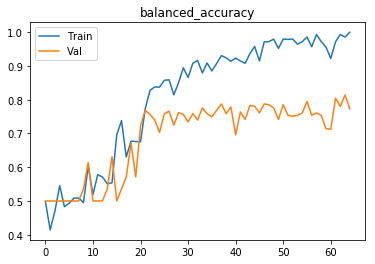

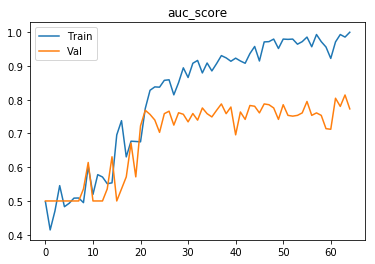

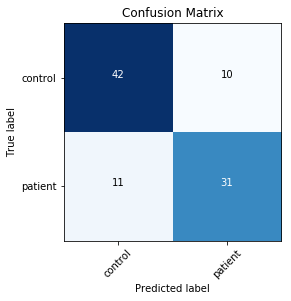

###### Starting inner fold 4
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 259131
[0,    10] loss: 0.69436
[0,    20] loss: 0.68444
[0,    30] loss: 0.70155
Time elapsed: 0h:0m:2s
train accuracy_score: 47.14 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 55.32 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.690466
[1,    10] loss: 0.68675
[1,    20] loss: 0.69306
[1,    30] loss: 0.70741
Time elapsed: 0h:0m:7s
train accuracy_score: 50.00 %
train balanced_accuracy: 48.61 %
train auc_score: 48.61 %
val accuracy_score: 44.68 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.697059
[2,    10] loss: 0.69587
[2,    20] loss: 0.69594
[2,    30] loss: 0.69197
Time elapsed: 0h:0m:11s
train accuracy_score: 46.43 %
train balanced_accuracy: 45.97 %
train auc_score: 45.97 %
val accuracy_score: 47.87 %
val balanced_accuracy: 52.88 %
val auc_score: 52.88 %
Val loss: 0.693016
[3,  

[28,    10] loss: 0.66334
[28,    20] loss: 0.66538
[28,    30] loss: 0.65548
Time elapsed: 0h:2m:6s
train accuracy_score: 62.14 %
train balanced_accuracy: 61.90 %
train auc_score: 61.90 %
val accuracy_score: 54.26 %
val balanced_accuracy: 56.59 %
val auc_score: 56.59 %
Val loss: 0.674531
[29,    10] loss: 0.63530
[29,    20] loss: 0.67164
[29,    30] loss: 0.63357
Time elapsed: 0h:2m:11s
train accuracy_score: 66.43 %
train balanced_accuracy: 65.38 %
train auc_score: 65.38 %
val accuracy_score: 69.15 %
val balanced_accuracy: 65.48 %
val auc_score: 65.48 %
Val loss: 0.654806
[30,    10] loss: 0.62595
[30,    20] loss: 0.63308
[30,    30] loss: 0.56993
Time elapsed: 0h:2m:15s
train accuracy_score: 72.14 %
train balanced_accuracy: 72.67 %
train auc_score: 72.67 %
val accuracy_score: 68.09 %
val balanced_accuracy: 66.35 %
val auc_score: 66.35 %
Val loss: 0.642301
[31,    10] loss: 0.59084
[31,    20] loss: 0.65486
[31,    30] loss: 0.62150
Time elapsed: 0h:2m:19s
train accuracy_score: 69.2

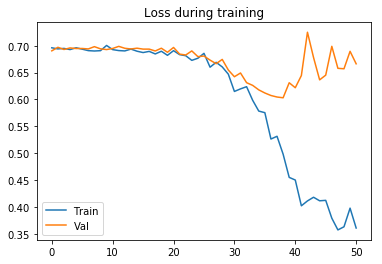

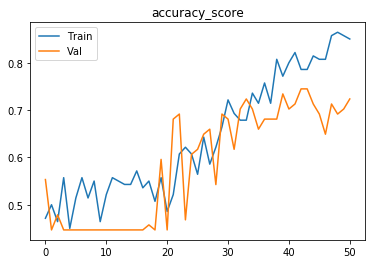

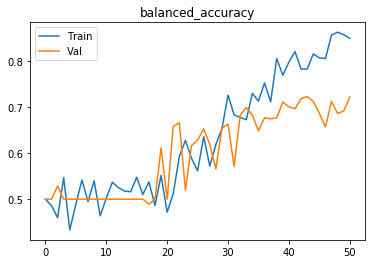

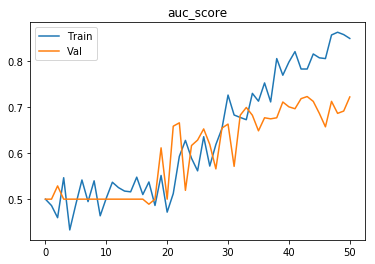

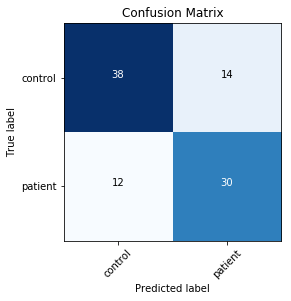

Finished outer fold.
{'final_acc': 0.7852564102564104, 'best_acc': 0.8021978021978023, 'final_iter': 43, 'best_iter': 40, 'params': {'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 2}
###### Starting outer fold 8
# of patients 118, # of healthy controls 119
138
99
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 259131
[0,    10] loss: 0.69361
[0,    20] loss: 0.68135
[0,    30] loss: 0.68563
Time elapsed: 0h:0m:3s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.718589
[1,    10] loss: 0.67138
[1,    20] loss: 0.69798
[1,    30] loss: 0.67254
Time elapsed: 0h:0m:7s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val lo

[27,    10] loss: 0.63507
[27,    20] loss: 0.67798
[27,    30] loss: 0.58671
Time elapsed: 0h:2m:5s
train accuracy_score: 65.94 %
train balanced_accuracy: 65.10 %
train auc_score: 65.10 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.824413
[28,    10] loss: 0.64650
[28,    20] loss: 0.62846
[28,    30] loss: 0.59664
Time elapsed: 0h:2m:9s
train accuracy_score: 60.87 %
train balanced_accuracy: 55.74 %
train auc_score: 55.74 %
val accuracy_score: 62.63 %
val balanced_accuracy: 67.82 %
val auc_score: 67.82 %
Val loss: 0.652042
[29,    10] loss: 0.69623
[29,    20] loss: 0.62453
[29,    30] loss: 0.63969
Time elapsed: 0h:2m:14s
train accuracy_score: 60.87 %
train balanced_accuracy: 59.39 %
train auc_score: 59.39 %
val accuracy_score: 62.63 %
val balanced_accuracy: 67.82 %
val auc_score: 67.82 %
Val loss: 0.651808
[30,    10] loss: 0.60023
[30,    20] loss: 0.59765
[30,    30] loss: 0.57445
Time elapsed: 0h:2m:18s
train accuracy_score: 69.57

[55,    30] loss: 0.34187
Time elapsed: 0h:4m:11s
train accuracy_score: 88.41 %
train balanced_accuracy: 88.59 %
train auc_score: 88.59 %
val accuracy_score: 71.72 %
val balanced_accuracy: 75.32 %
val auc_score: 75.32 %
Val loss: 0.742180
Early stopping in epoch 56
Total time elapsed: 0h:4m:13s
Writing model to disk...
Best result during training: 0.81. Saving model..
Finished inner fold.


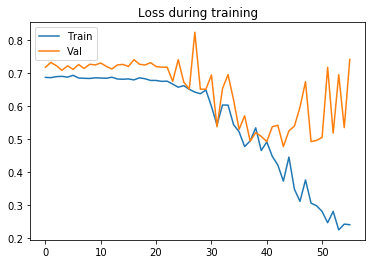

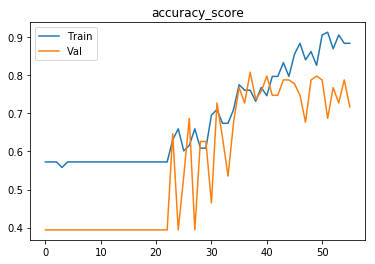

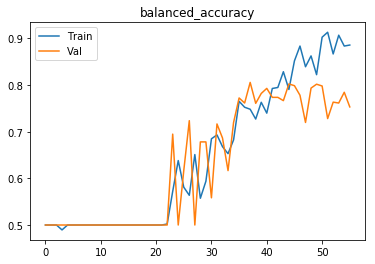

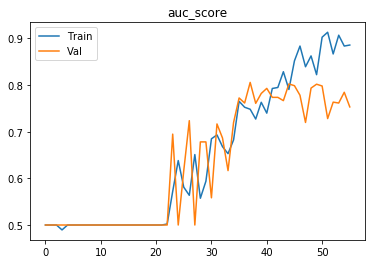

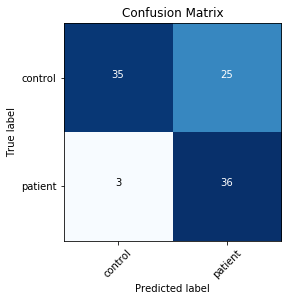

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 259131
[0,    10] loss: 0.69705
[0,    20] loss: 0.68585
Time elapsed: 0h:0m:2s
train accuracy_score: 50.72 %
train balanced_accuracy: 50.10 %
train auc_score: 50.10 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.716124
[1,    10] loss: 0.68462
[1,    20] loss: 0.66797
Time elapsed: 0h:0m:7s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.760883
[2,    10] loss: 0.69534
[2,    20] loss: 0.68755
Time elapsed: 0h:0m:11s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.721901
[3,    10] loss: 0.69799
[3,    20] loss: 0.68413
Time elapsed: 0h:0m:14s
train

val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.691416
[31,    10] loss: 0.66676
[31,    20] loss: 0.67146
Time elapsed: 0h:2m:6s
train accuracy_score: 56.52 %
train balanced_accuracy: 51.94 %
train auc_score: 51.94 %
val accuracy_score: 52.53 %
val balanced_accuracy: 60.83 %
val auc_score: 60.83 %
Val loss: 0.676594
[32,    10] loss: 0.65224
[32,    20] loss: 0.61086
Time elapsed: 0h:2m:10s
train accuracy_score: 59.42 %
train balanced_accuracy: 53.83 %
train auc_score: 53.83 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.716568
[33,    10] loss: 0.60860
[33,    20] loss: 0.62468
Time elapsed: 0h:2m:14s
train accuracy_score: 61.59 %
train balanced_accuracy: 58.52 %
train auc_score: 58.52 %
val accuracy_score: 64.65 %
val balanced_accuracy: 59.62 %
val auc_score: 59.62 %
Val loss: 0.602377
[34,    10] loss: 0.58837
[34,    20] loss: 0.57862
Time elapsed: 0h:2m:18s
train accuracy_score: 63.77 %

val accuracy_score: 82.83 %
val balanced_accuracy: 82.69 %
val auc_score: 82.69 %
Val loss: 0.453400
[62,    10] loss: 0.26933
[62,    20] loss: 0.27770
Time elapsed: 0h:4m:12s
train accuracy_score: 89.13 %
train balanced_accuracy: 88.58 %
train auc_score: 88.58 %
val accuracy_score: 82.83 %
val balanced_accuracy: 84.94 %
val auc_score: 84.94 %
Val loss: 0.547097
[63,    10] loss: 0.18323
[63,    20] loss: 0.39993
Time elapsed: 0h:4m:15s
train accuracy_score: 88.41 %
train balanced_accuracy: 88.37 %
train auc_score: 88.37 %
val accuracy_score: 82.83 %
val balanced_accuracy: 84.94 %
val auc_score: 84.94 %
Val loss: 0.544704
[64,    10] loss: 0.25313
[64,    20] loss: 0.27319
Time elapsed: 0h:4m:19s
train accuracy_score: 89.13 %
train balanced_accuracy: 89.65 %
train auc_score: 89.65 %
val accuracy_score: 82.83 %
val balanced_accuracy: 84.94 %
val auc_score: 84.94 %
Val loss: 0.516611
[65,    10] loss: 0.20201
[65,    20] loss: 0.33135
Time elapsed: 0h:4m:23s
train accuracy_score: 88.41 

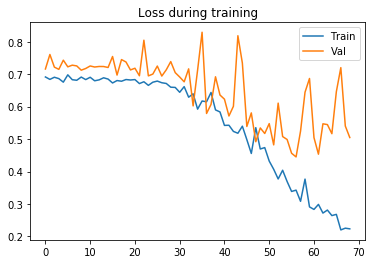

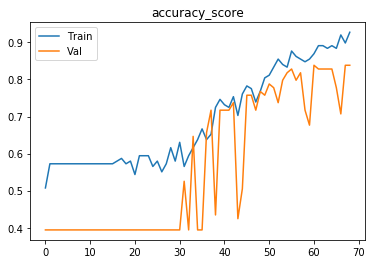

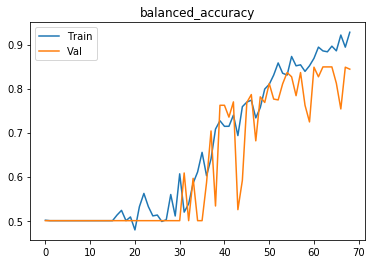

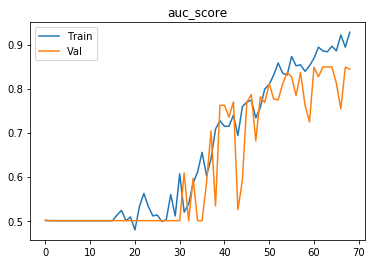

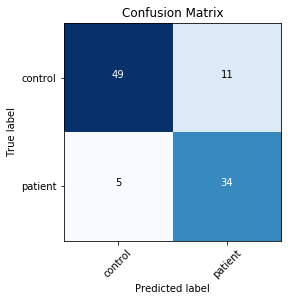

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 519979
[0,    10] loss: 0.69315
[0,    20] loss: 0.67894
[0,    30] loss: 0.71390
Time elapsed: 0h:0m:4s
train accuracy_score: 56.52 %
train balanced_accuracy: 50.44 %
train auc_score: 50.44 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.725247
[1,    10] loss: 0.69885
[1,    20] loss: 0.66161
[1,    30] loss: 0.71220
Time elapsed: 0h:0m:11s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.727123
[2,    10] loss: 0.68980
[2,    20] loss: 0.68974
[2,    30] loss: 0.68129
Time elapsed: 0h:0m:18s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.716548
[3, 

[28,    10] loss: 0.53245
[28,    20] loss: 0.50291
[28,    30] loss: 0.37646
Time elapsed: 0h:3m:14s
train accuracy_score: 79.71 %
train balanced_accuracy: 78.85 %
train auc_score: 78.85 %
val accuracy_score: 79.80 %
val balanced_accuracy: 81.54 %
val auc_score: 81.54 %
Val loss: 0.548061
[29,    10] loss: 0.47709
[29,    20] loss: 0.39361
[29,    30] loss: 0.43561
Time elapsed: 0h:3m:21s
train accuracy_score: 80.43 %
train balanced_accuracy: 79.48 %
train auc_score: 79.48 %
val accuracy_score: 80.81 %
val balanced_accuracy: 80.13 %
val auc_score: 80.13 %
Val loss: 0.480748
[30,    10] loss: 0.55191
[30,    20] loss: 0.36805
[30,    30] loss: 0.32932
Time elapsed: 0h:3m:28s
train accuracy_score: 83.33 %
train balanced_accuracy: 83.30 %
train auc_score: 83.30 %
val accuracy_score: 80.81 %
val balanced_accuracy: 81.92 %
val auc_score: 81.92 %
Val loss: 0.527493
[31,    10] loss: 0.27167
[31,    20] loss: 0.46472
[31,    30] loss: 0.59857
Time elapsed: 0h:3m:34s
train accuracy_score: 84.

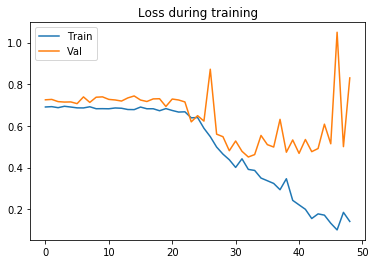

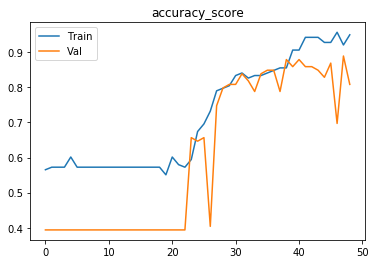

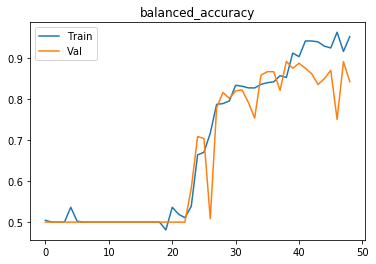

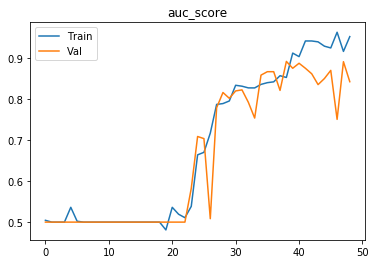

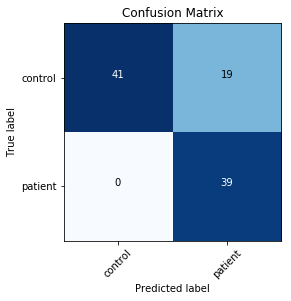

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 519979
[0,    10] loss: 0.69947
[0,    20] loss: 0.69409
[0,    30] loss: 0.68636
Time elapsed: 0h:0m:4s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.710860
[1,    10] loss: 0.66571
[1,    20] loss: 0.69251
[1,    30] loss: 0.71776
Time elapsed: 0h:0m:11s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.714484
[2,    10] loss: 0.68465
[2,    20] loss: 0.67208
[2,    30] loss: 0.72172
Time elapsed: 0h:0m:18s
train accuracy_score: 57.97 %
train balanced_accuracy: 50.85 %
train auc_score: 50.85 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.711091
[3, 

[28,    10] loss: 0.61116
[28,    20] loss: 0.51991
[28,    30] loss: 0.44672
Time elapsed: 0h:3m:14s
train accuracy_score: 80.43 %
train balanced_accuracy: 80.55 %
train auc_score: 80.55 %
val accuracy_score: 51.52 %
val balanced_accuracy: 60.00 %
val auc_score: 60.00 %
Val loss: 0.743270
[29,    10] loss: 0.61789
[29,    20] loss: 0.58992
[29,    30] loss: 0.53806
Time elapsed: 0h:3m:20s
train accuracy_score: 71.01 %
train balanced_accuracy: 69.96 %
train auc_score: 69.96 %
val accuracy_score: 56.57 %
val balanced_accuracy: 64.17 %
val auc_score: 64.17 %
Val loss: 0.707992
[30,    10] loss: 0.54015
[30,    20] loss: 0.46513
[30,    30] loss: 0.62584
Time elapsed: 0h:3m:27s
train accuracy_score: 71.01 %
train balanced_accuracy: 69.32 %
train auc_score: 69.32 %
val accuracy_score: 62.63 %
val balanced_accuracy: 69.17 %
val auc_score: 69.17 %
Val loss: 0.685802
[31,    10] loss: 0.44743
[31,    20] loss: 0.44796
[31,    30] loss: 0.71429
Time elapsed: 0h:3m:34s
train accuracy_score: 74.

[56,    30] loss: 0.10877
Time elapsed: 0h:6m:22s
train accuracy_score: 95.65 %
train balanced_accuracy: 95.77 %
train auc_score: 95.77 %
val accuracy_score: 87.88 %
val balanced_accuracy: 90.00 %
val auc_score: 90.00 %
Val loss: 0.622576
[57,    10] loss: 0.09185
[57,    20] loss: 0.04657
[57,    30] loss: 0.06186
Time elapsed: 0h:6m:29s
train accuracy_score: 97.83 %
train balanced_accuracy: 97.67 %
train auc_score: 97.67 %
val accuracy_score: 86.87 %
val balanced_accuracy: 86.47 %
val auc_score: 86.47 %
Val loss: 0.568239
[58,    10] loss: 0.13034
[58,    20] loss: 0.05372
[58,    30] loss: 0.06028
Time elapsed: 0h:6m:36s
train accuracy_score: 98.55 %
train balanced_accuracy: 98.52 %
train auc_score: 98.52 %
val accuracy_score: 81.82 %
val balanced_accuracy: 85.00 %
val auc_score: 85.00 %
Val loss: 0.859260
Early stopping in epoch 59
Total time elapsed: 0h:6m:37s
Writing model to disk...
Best result during training: 0.90. Saving model..
Finished inner fold.


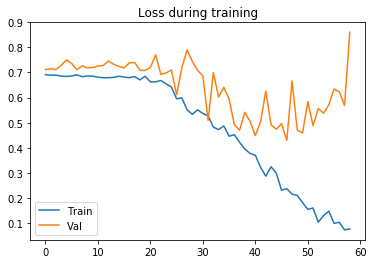

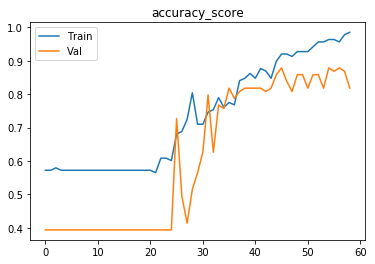

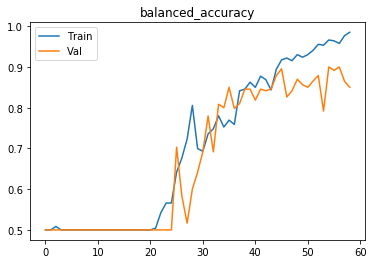

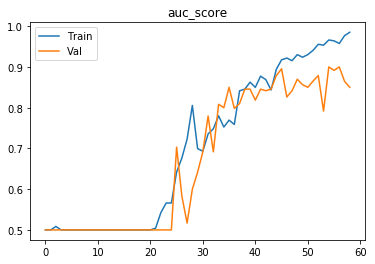

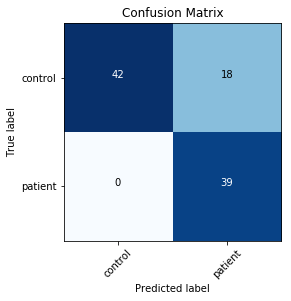

###### Starting inner fold 4
{'model': 'ModelAPIF', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}
Trainable model parameters: 259131
[0,    10] loss: 0.68949
[0,    20] loss: 0.69633
[0,    30] loss: 0.67932
Time elapsed: 0h:0m:2s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.713106
[1,    10] loss: 0.67015
[1,    20] loss: 0.68379
[1,    30] loss: 0.66081
Time elapsed: 0h:0m:7s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.749903
[2,    10] loss: 0.66936
[2,    20] loss: 0.69120
[2,    30] loss: 0.67454
Time elapsed: 0h:0m:11s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.728950
[3,  

[28,    10] loss: 0.68480
[28,    20] loss: 0.69509
[28,    30] loss: 0.66266
Time elapsed: 0h:2m:8s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.719436
[29,    10] loss: 0.69110
[29,    20] loss: 0.67713
[29,    30] loss: 0.67475
Time elapsed: 0h:2m:13s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.720510
[30,    10] loss: 0.69833
[30,    20] loss: 0.68740
[30,    30] loss: 0.65808
Time elapsed: 0h:2m:17s
train accuracy_score: 57.25 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 39.39 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.719739
[31,    10] loss: 0.67857
[31,    20] loss: 0.69753
[31,    30] loss: 0.67867
Time elapsed: 0h:2m:22s
train accuracy_score: 57.2

[56,    30] loss: 0.68309
Time elapsed: 0h:4m:14s
train accuracy_score: 65.22 %
train balanced_accuracy: 61.47 %
train auc_score: 61.47 %
val accuracy_score: 70.71 %
val balanced_accuracy: 69.10 %
val auc_score: 69.10 %
Val loss: 0.639916
[57,    10] loss: 0.63793
[57,    20] loss: 0.61981
[57,    30] loss: 0.61671
Time elapsed: 0h:4m:18s
train accuracy_score: 64.49 %
train balanced_accuracy: 64.05 %
train auc_score: 64.05 %
val accuracy_score: 49.49 %
val balanced_accuracy: 58.33 %
val auc_score: 58.33 %
Val loss: 0.684015
[58,    10] loss: 0.60520
[58,    20] loss: 0.62009
[58,    30] loss: 0.62579
Time elapsed: 0h:4m:23s
train accuracy_score: 61.59 %
train balanced_accuracy: 59.16 %
train auc_score: 59.16 %
val accuracy_score: 64.65 %
val balanced_accuracy: 60.06 %
val auc_score: 60.06 %
Val loss: 0.609944
[59,    10] loss: 0.61725
[59,    20] loss: 0.59641
[59,    30] loss: 0.57638
Time elapsed: 0h:4m:27s
train accuracy_score: 67.39 %
train balanced_accuracy: 65.08 %
train auc_scor

val accuracy_score: 72.73 %
val balanced_accuracy: 74.36 %
val auc_score: 74.36 %
Val loss: 0.547978
[85,    10] loss: 0.40069
[85,    20] loss: 0.39877
[85,    30] loss: 0.30491
Time elapsed: 0h:6m:24s
train accuracy_score: 81.88 %
train balanced_accuracy: 81.82 %
train auc_score: 81.82 %
val accuracy_score: 72.73 %
val balanced_accuracy: 77.50 %
val auc_score: 77.50 %
Val loss: 0.674364
[86,    10] loss: 0.38911
[86,    20] loss: 0.52851
[86,    30] loss: 0.42225
Time elapsed: 0h:6m:28s
train accuracy_score: 81.88 %
train balanced_accuracy: 81.60 %
train auc_score: 81.60 %
val accuracy_score: 73.74 %
val balanced_accuracy: 78.33 %
val auc_score: 78.33 %
Val loss: 0.666564
[87,    10] loss: 0.46140
[87,    20] loss: 0.34156
[87,    30] loss: 0.43028
Time elapsed: 0h:6m:33s
train accuracy_score: 79.71 %
train balanced_accuracy: 78.20 %
train auc_score: 78.20 %
val accuracy_score: 71.72 %
val balanced_accuracy: 72.18 %
val auc_score: 72.18 %
Val loss: 0.495151
[88,    10] loss: 0.38904


[113,    10] loss: 0.26552
[113,    20] loss: 0.26819
[113,    30] loss: 0.33877
Time elapsed: 0h:8m:30s
train accuracy_score: 86.96 %
train balanced_accuracy: 86.25 %
train auc_score: 86.25 %
val accuracy_score: 76.77 %
val balanced_accuracy: 78.14 %
val auc_score: 78.14 %
Val loss: 0.550814
[114,    10] loss: 0.26712
[114,    20] loss: 0.15892
[114,    30] loss: 0.28988
Time elapsed: 0h:8m:35s
train accuracy_score: 87.68 %
train balanced_accuracy: 87.52 %
train auc_score: 87.52 %
val accuracy_score: 78.79 %
val balanced_accuracy: 80.71 %
val auc_score: 80.71 %
Val loss: 0.553061
[115,    10] loss: 0.21017
[115,    20] loss: 0.24117
[115,    30] loss: 0.21151
Time elapsed: 0h:8m:39s
train accuracy_score: 89.86 %
train balanced_accuracy: 89.85 %
train auc_score: 89.85 %
val accuracy_score: 78.79 %
val balanced_accuracy: 80.71 %
val auc_score: 80.71 %
Val loss: 0.573011
Early stopping in epoch 116
Total time elapsed: 0h:8m:41s
Writing model to disk...
Best result during training: 0.81. 

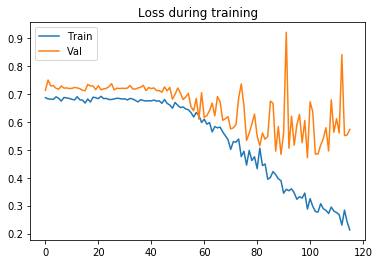

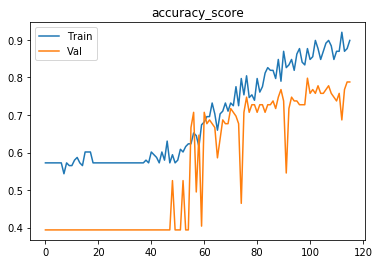

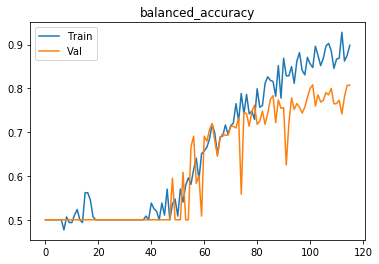

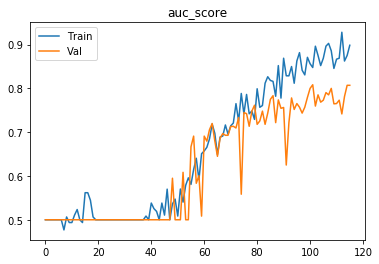

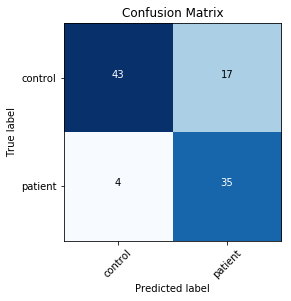

Finished outer fold.
{'final_acc': 0.8499999999999999, 'best_acc': 0.9000000000000001, 'final_iter': 59, 'best_iter': 57, 'params': {'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 3}
###### Starting outer fold 9
# of patients 121, # of healthy controls 128
137
112
###### Starting inner fold 0
{'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 259131
[0,    10] loss: 0.70140
[0,    20] loss: 0.69550
Time elapsed: 0h:0m:2s
train accuracy_score: 45.26 %
train balanced_accuracy: 44.99 %
train auc_score: 44.99 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.696501
[1,    10] loss: 0.69384
[1,    20] loss: 0.69593
Time elapsed: 0h:0m:6s
train accuracy_score: 49.64 %
train balanced_accuracy: 48.57 %
train auc_score: 48.57 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.696491
[2,    10] loss: 0.69358
[2,    20] l

val accuracy_score: 56.25 %
val balanced_accuracy: 52.76 %
val auc_score: 52.76 %
Val loss: 0.686967
[30,    10] loss: 0.68694
[30,    20] loss: 0.68870
Time elapsed: 0h:2m:7s
train accuracy_score: 59.85 %
train balanced_accuracy: 59.95 %
train auc_score: 59.95 %
val accuracy_score: 65.18 %
val balanced_accuracy: 63.21 %
val auc_score: 63.21 %
Val loss: 0.687977
[31,    10] loss: 0.68280
[31,    20] loss: 0.66956
Time elapsed: 0h:2m:12s
train accuracy_score: 63.50 %
train balanced_accuracy: 63.23 %
train auc_score: 63.23 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.693167
[32,    10] loss: 0.67210
[32,    20] loss: 0.69482
Time elapsed: 0h:2m:16s
train accuracy_score: 60.58 %
train balanced_accuracy: 60.50 %
train auc_score: 60.50 %
val accuracy_score: 56.25 %
val balanced_accuracy: 52.93 %
val auc_score: 52.93 %
Val loss: 0.682325
[33,    10] loss: 0.67827
[33,    20] loss: 0.69524
Time elapsed: 0h:2m:20s
train accuracy_score: 51.82 %

val accuracy_score: 75.00 %
val balanced_accuracy: 74.32 %
val auc_score: 74.32 %
Val loss: 0.650622
[61,    10] loss: 0.32678
[61,    20] loss: 0.37700
Time elapsed: 0h:4m:17s
train accuracy_score: 85.40 %
train balanced_accuracy: 85.52 %
train auc_score: 85.52 %
val accuracy_score: 75.00 %
val balanced_accuracy: 75.44 %
val auc_score: 75.44 %
Val loss: 0.685511
[62,    10] loss: 0.27003
[62,    20] loss: 0.24912
Time elapsed: 0h:4m:21s
train accuracy_score: 92.70 %
train balanced_accuracy: 92.73 %
train auc_score: 92.73 %
val accuracy_score: 75.00 %
val balanced_accuracy: 74.16 %
val auc_score: 74.16 %
Val loss: 0.653924
[63,    10] loss: 0.24098
[63,    20] loss: 0.43204
Time elapsed: 0h:4m:25s
train accuracy_score: 86.86 %
train balanced_accuracy: 86.89 %
train auc_score: 86.89 %
val accuracy_score: 75.00 %
val balanced_accuracy: 74.32 %
val auc_score: 74.32 %
Val loss: 0.635527
[64,    10] loss: 0.29973
[64,    20] loss: 0.28710
Time elapsed: 0h:4m:29s
train accuracy_score: 88.32 

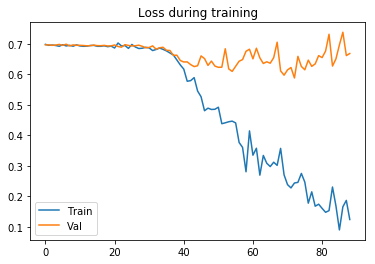

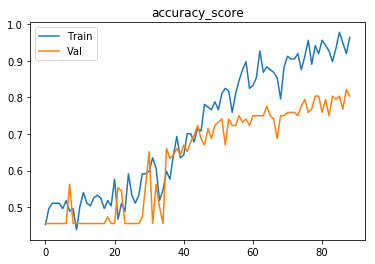

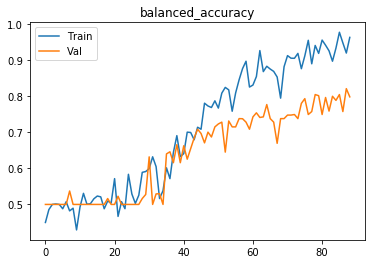

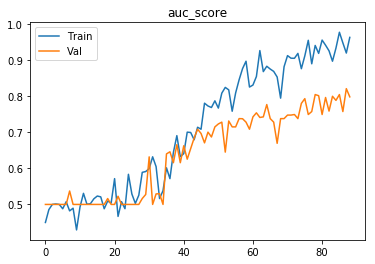

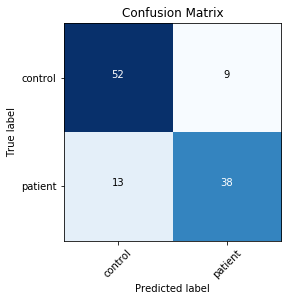

###### Starting inner fold 1
{'model': 'ModelAPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}
Trainable model parameters: 259131
[0,    10] loss: 0.69450
Time elapsed: 0h:0m:2s
train accuracy_score: 51.09 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.696200
[1,    10] loss: 0.69329
Time elapsed: 0h:0m:5s
train accuracy_score: 51.09 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.696775
[2,    10] loss: 0.69222
Time elapsed: 0h:0m:9s
train accuracy_score: 51.09 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.695347
[3,    10] loss: 0.69145
Time elapsed: 0h:0m:13s
train accuracy_score: 51.09 %
train balanced_accuracy: 50.03 %
train auc_score: 50.03 %
val accuracy_score

[34,    10] loss: 0.65816
Time elapsed: 0h:2m:8s
train accuracy_score: 61.31 %
train balanced_accuracy: 60.83 %
train auc_score: 60.83 %
val accuracy_score: 63.39 %
val balanced_accuracy: 64.46 %
val auc_score: 64.46 %
Val loss: 0.677101
[35,    10] loss: 0.68035
Time elapsed: 0h:2m:12s
train accuracy_score: 57.66 %
train balanced_accuracy: 57.42 %
train auc_score: 57.42 %
val accuracy_score: 57.14 %
val balanced_accuracy: 53.42 %
val auc_score: 53.42 %
Val loss: 0.670388
[36,    10] loss: 0.69411
Time elapsed: 0h:2m:16s
train accuracy_score: 56.20 %
train balanced_accuracy: 56.25 %
train auc_score: 56.25 %
val accuracy_score: 67.86 %
val balanced_accuracy: 65.99 %
val auc_score: 65.99 %
Val loss: 0.673316
[37,    10] loss: 0.68196
Time elapsed: 0h:2m:20s
train accuracy_score: 54.74 %
train balanced_accuracy: 54.69 %
train auc_score: 54.69 %
val accuracy_score: 67.86 %
val balanced_accuracy: 65.99 %
val auc_score: 65.99 %
Val loss: 0.674180
[38,    10] loss: 0.65781
Time elapsed: 0h:2m

val accuracy_score: 69.64 %
val balanced_accuracy: 67.15 %
val auc_score: 67.15 %
Val loss: 0.593775
[69,    10] loss: 0.52293
Time elapsed: 0h:4m:21s
train accuracy_score: 71.53 %
train balanced_accuracy: 71.57 %
train auc_score: 71.57 %
val accuracy_score: 76.79 %
val balanced_accuracy: 75.96 %
val auc_score: 75.96 %
Val loss: 0.545687
[70,    10] loss: 0.49948
Time elapsed: 0h:4m:25s
train accuracy_score: 76.64 %
train balanced_accuracy: 76.66 %
train auc_score: 76.66 %
val accuracy_score: 78.57 %
val balanced_accuracy: 78.08 %
val auc_score: 78.08 %
Val loss: 0.548210
[71,    10] loss: 0.47450
Time elapsed: 0h:4m:29s
train accuracy_score: 75.91 %
train balanced_accuracy: 75.82 %
train auc_score: 75.82 %
val accuracy_score: 75.89 %
val balanced_accuracy: 74.98 %
val auc_score: 74.98 %
Val loss: 0.539557
[72,    10] loss: 0.51411
Time elapsed: 0h:4m:33s
train accuracy_score: 75.18 %
train balanced_accuracy: 75.27 %
train auc_score: 75.27 %
val accuracy_score: 80.36 %
val balanced_acc

[103,    10] loss: 0.37219
Time elapsed: 0h:6m:32s
train accuracy_score: 81.75 %
train balanced_accuracy: 81.76 %
train auc_score: 81.76 %
val accuracy_score: 76.79 %
val balanced_accuracy: 75.80 %
val auc_score: 75.80 %
Val loss: 0.502952
[104,    10] loss: 0.40136
Time elapsed: 0h:6m:36s
train accuracy_score: 83.94 %
train balanced_accuracy: 83.93 %
train auc_score: 83.93 %
val accuracy_score: 77.68 %
val balanced_accuracy: 76.78 %
val auc_score: 76.78 %
Val loss: 0.499847
[105,    10] loss: 0.40670
Time elapsed: 0h:6m:40s
train accuracy_score: 81.02 %
train balanced_accuracy: 81.24 %
train auc_score: 81.24 %
val accuracy_score: 77.68 %
val balanced_accuracy: 76.78 %
val auc_score: 76.78 %
Val loss: 0.497667
[106,    10] loss: 0.42542
Time elapsed: 0h:6m:44s
train accuracy_score: 80.29 %
train balanced_accuracy: 80.30 %
train auc_score: 80.30 %
val accuracy_score: 75.89 %
val balanced_accuracy: 74.49 %
val auc_score: 74.49 %
Val loss: 0.536093
[107,    10] loss: 0.36711
Time elapsed:

val accuracy_score: 74.11 %
val balanced_accuracy: 74.30 %
val auc_score: 74.30 %
Val loss: 0.510828
[138,    10] loss: 0.30778
Time elapsed: 0h:8m:45s
train accuracy_score: 86.86 %
train balanced_accuracy: 86.95 %
train auc_score: 86.95 %
val accuracy_score: 76.79 %
val balanced_accuracy: 75.47 %
val auc_score: 75.47 %
Val loss: 0.496537
[139,    10] loss: 0.29433
Time elapsed: 0h:8m:48s
train accuracy_score: 85.40 %
train balanced_accuracy: 85.36 %
train auc_score: 85.36 %
val accuracy_score: 76.79 %
val balanced_accuracy: 75.47 %
val auc_score: 75.47 %
Val loss: 0.492707
[140,    10] loss: 0.31871
Time elapsed: 0h:8m:52s
train accuracy_score: 87.59 %
train balanced_accuracy: 87.60 %
train auc_score: 87.60 %
val accuracy_score: 77.68 %
val balanced_accuracy: 76.62 %
val auc_score: 76.62 %
Val loss: 0.486679
Early stopping in epoch 141
Total time elapsed: 0h:8m:54s
Writing model to disk...
Best result during training: 0.80. Saving model..
Finished inner fold.


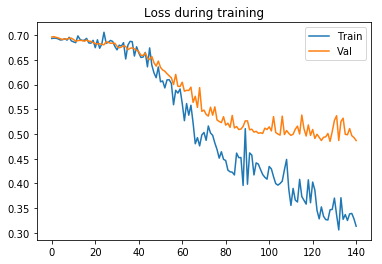

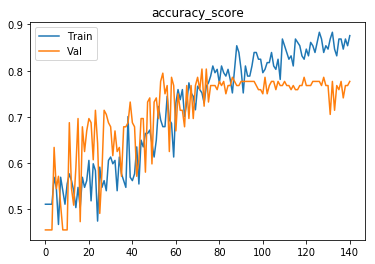

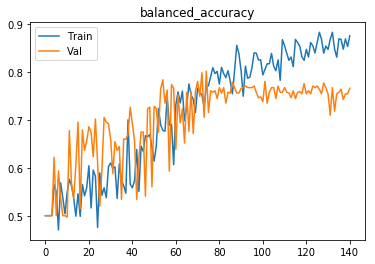

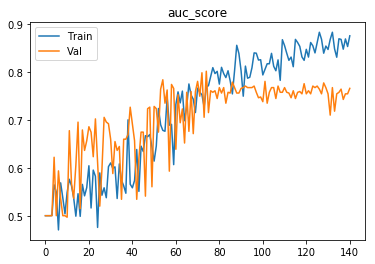

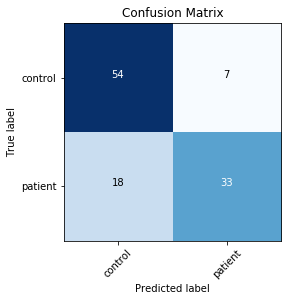

###### Starting inner fold 2
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 519979
[0,    10] loss: 0.69739
[0,    20] loss: 0.69099
[0,    30] loss: 0.68939
Time elapsed: 0h:0m:5s
train accuracy_score: 51.09 %
train balanced_accuracy: 51.02 %
train auc_score: 51.02 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.698650
[1,    10] loss: 0.69353
[1,    20] loss: 0.70378
[1,    30] loss: 0.69478
Time elapsed: 0h:0m:12s
train accuracy_score: 43.07 %
train balanced_accuracy: 42.78 %
train auc_score: 42.78 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.695857
[2,    10] loss: 0.69387
[2,    20] loss: 0.68385
[2,    30] loss: 0.70353
Time elapsed: 0h:0m:19s
train accuracy_score: 51.09 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.694882
[3,

[28,    10] loss: 0.33089
[28,    20] loss: 0.19672
[28,    30] loss: 0.23501
Time elapsed: 0h:3m:22s
train accuracy_score: 87.59 %
train balanced_accuracy: 87.63 %
train auc_score: 87.63 %
val accuracy_score: 76.79 %
val balanced_accuracy: 76.12 %
val auc_score: 76.12 %
Val loss: 0.563761
[29,    10] loss: 0.17900
[29,    20] loss: 0.24096
[29,    30] loss: 0.11329
Time elapsed: 0h:3m:29s
train accuracy_score: 93.43 %
train balanced_accuracy: 93.44 %
train auc_score: 93.44 %
val accuracy_score: 77.68 %
val balanced_accuracy: 77.74 %
val auc_score: 77.74 %
Val loss: 0.604370
[30,    10] loss: 0.18268
[30,    20] loss: 0.11664
[30,    30] loss: 0.18531
Time elapsed: 0h:3m:36s
train accuracy_score: 94.16 %
train balanced_accuracy: 94.16 %
train auc_score: 94.16 %
val accuracy_score: 75.89 %
val balanced_accuracy: 75.14 %
val auc_score: 75.14 %
Val loss: 0.594044
[31,    10] loss: 0.15615
[31,    20] loss: 0.11452
[31,    30] loss: 0.09018
Time elapsed: 0h:3m:43s
train accuracy_score: 95.

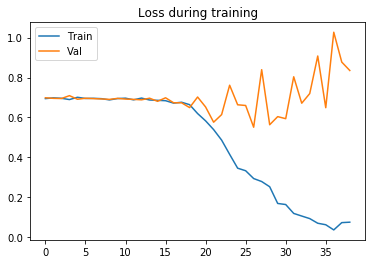

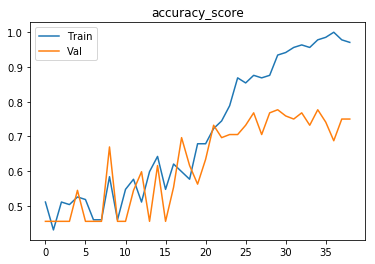

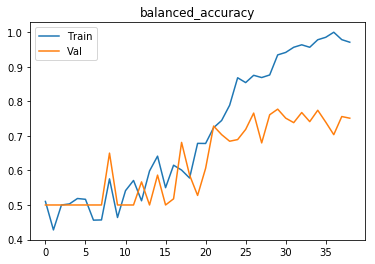

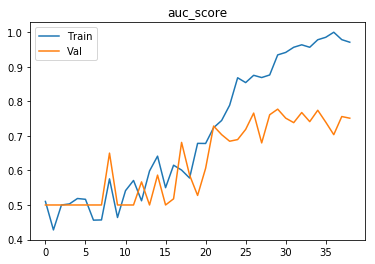

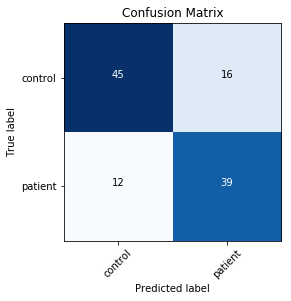

###### Starting inner fold 3
{'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}
Trainable model parameters: 519979
[0,    10] loss: 0.70330
[0,    20] loss: 0.69299
[0,    30] loss: 0.70005
Time elapsed: 0h:0m:4s
train accuracy_score: 49.64 %
train balanced_accuracy: 49.43 %
train auc_score: 49.43 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.696466
[1,    10] loss: 0.69033
[1,    20] loss: 0.69014
[1,    30] loss: 0.70024
Time elapsed: 0h:0m:12s
train accuracy_score: 48.91 %
train balanced_accuracy: 48.18 %
train auc_score: 48.18 %
val accuracy_score: 47.32 %
val balanced_accuracy: 51.64 %
val auc_score: 51.64 %
Val loss: 0.693014
[2,    10] loss: 0.69386
[2,    20] loss: 0.69310
[2,    30] loss: 0.70292
Time elapsed: 0h:0m:19s
train accuracy_score: 44.53 %
train balanced_accuracy: 44.34 %
train auc_score: 44.34 %
val accuracy_score: 52.68 %
val balanced_accuracy: 49.32 %
val auc_score: 49.32 %
Val loss: 0.692035
[3,

[28,    10] loss: 0.08606
[28,    20] loss: 0.11762
[28,    30] loss: 0.12002
Time elapsed: 0h:3m:22s
train accuracy_score: 95.62 %
train balanced_accuracy: 95.68 %
train auc_score: 95.68 %
val accuracy_score: 81.25 %
val balanced_accuracy: 81.18 %
val auc_score: 81.18 %
Val loss: 0.626782
[29,    10] loss: 0.05501
[29,    20] loss: 0.13100
[29,    30] loss: 0.03511
Time elapsed: 0h:3m:29s
train accuracy_score: 99.27 %
train balanced_accuracy: 99.29 %
train auc_score: 99.29 %
val accuracy_score: 77.68 %
val balanced_accuracy: 77.10 %
val auc_score: 77.10 %
Val loss: 0.641111
[30,    10] loss: 0.04506
[30,    20] loss: 0.03296
[30,    30] loss: 0.01616
Time elapsed: 0h:3m:36s
train accuracy_score: 100.00 %
train balanced_accuracy: 100.00 %
train auc_score: 100.00 %
val accuracy_score: 75.89 %
val balanced_accuracy: 75.14 %
val auc_score: 75.14 %
Val loss: 0.790001
[31,    10] loss: 0.04126
[31,    20] loss: 0.04612
[31,    30] loss: 0.04065
Time elapsed: 0h:3m:43s
train accuracy_score: 

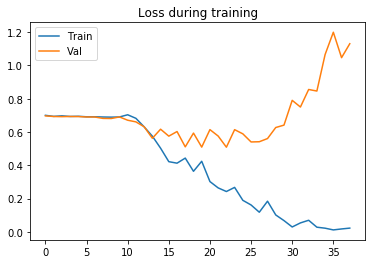

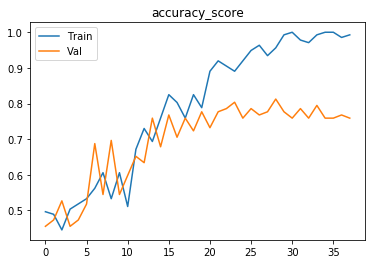

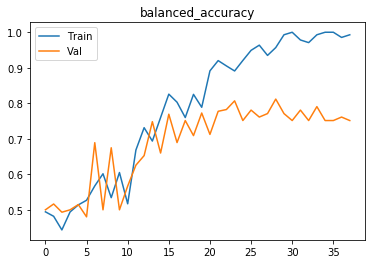

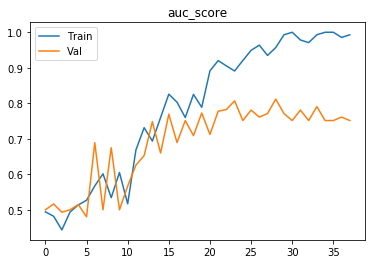

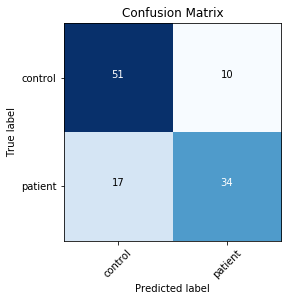

###### Starting inner fold 4
{'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}
Trainable model parameters: 519979
[0,    10] loss: 0.69785
Time elapsed: 0h:0m:4s
train accuracy_score: 51.82 %
train balanced_accuracy: 50.75 %
train auc_score: 50.75 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.696147
[1,    10] loss: 0.69809
Time elapsed: 0h:0m:10s
train accuracy_score: 40.15 %
train balanced_accuracy: 40.15 %
train auc_score: 40.15 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.694533
[2,    10] loss: 0.69372
Time elapsed: 0h:0m:16s
train accuracy_score: 51.09 %
train balanced_accuracy: 50.00 %
train auc_score: 50.00 %
val accuracy_score: 45.54 %
val balanced_accuracy: 50.00 %
val auc_score: 50.00 %
Val loss: 0.695119
[3,    10] loss: 0.69242
Time elapsed: 0h:0m:22s
train accuracy_score: 51.09 %
train balanced_accuracy: 50.54 %
train auc_score: 50.54 %
val accuracy_sc

[34,    10] loss: 0.26993
Time elapsed: 0h:3m:30s
train accuracy_score: 87.59 %
train balanced_accuracy: 87.51 %
train auc_score: 87.51 %
val accuracy_score: 78.57 %
val balanced_accuracy: 78.24 %
val auc_score: 78.24 %
Val loss: 0.499424
[35,    10] loss: 0.24225
Time elapsed: 0h:3m:36s
train accuracy_score: 91.24 %
train balanced_accuracy: 91.30 %
train auc_score: 91.30 %
val accuracy_score: 81.25 %
val balanced_accuracy: 81.34 %
val auc_score: 81.34 %
Val loss: 0.562433
[36,    10] loss: 0.25524
Time elapsed: 0h:3m:42s
train accuracy_score: 90.51 %
train balanced_accuracy: 90.55 %
train auc_score: 90.55 %
val accuracy_score: 78.57 %
val balanced_accuracy: 78.24 %
val auc_score: 78.24 %
Val loss: 0.507166
[37,    10] loss: 0.24036
Time elapsed: 0h:3m:48s
train accuracy_score: 89.05 %
train balanced_accuracy: 89.09 %
train auc_score: 89.09 %
val accuracy_score: 80.36 %
val balanced_accuracy: 80.20 %
val auc_score: 80.20 %
Val loss: 0.527617
[38,    10] loss: 0.23851
Time elapsed: 0h:3

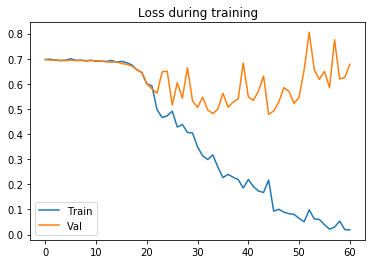

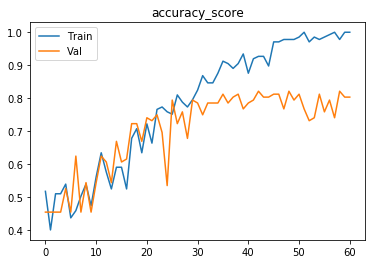

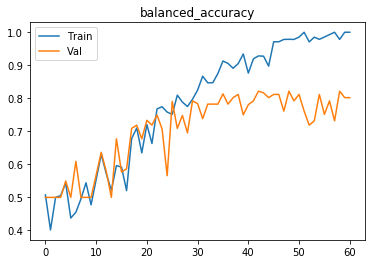

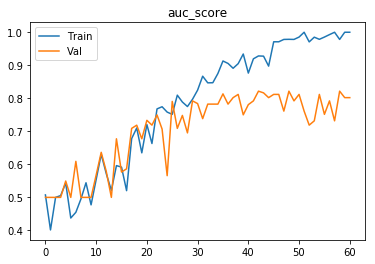

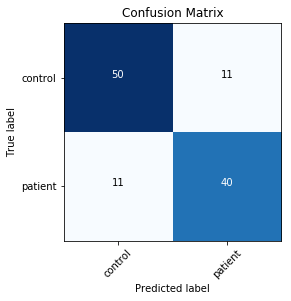

Finished outer fold.
{'final_acc': 0.7987785278045644, 'best_acc': 0.8216007714561234, 'final_iter': 89, 'best_iter': 88, 'params': {'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 0}
################################
################################
All accuracies: [0.7922237860661504, 0.7677691766361716, 0.7413793103448276, 0.7851864883884588, 0.8078817733990147, 0.8352272727272727, 0.8113636363636364, 0.8431818181818181, 0.7034090909090908, 0.8329545454545455, 0.7258893280632411, 0.6187747035573122, 0.700395256916996, 0.6693675889328063, 0.6932806324110673, 0.7793859649122807, 0.7447368421052631, 0.7223684210526315, 0.8578947368421052, 0.7149122807017544, 0.8322135125046659, 0.8327734229189996, 0.879805897723031, 0.8359462486002239, 0.7864874953340799, 0.8633271490414347, 0.5, 0.7230983302411873, 0.7925170068027211, 0.7079468150896722, 0.7662698412698413, 0.7910714285714285, 0.7357142857142858, 0.7525793650793651, 0.6232142857142857, 0.69871794

In [18]:
fold_metric, models = run(net=None, data=None,
                  k_folds=-1,
                  callbacks=callbacks,
                  shape=-1,
                  masked=False,
                  metrics=metrics,
                  num_epochs=num_epochs,
                  retain_metric=retain_metric,
                  b=None
                 )

print(np.mean(fold_metric))
print(np.std(fold_metric))

In [19]:
print(np.mean(fold_metric))
print(np.std(fold_metric))

0.7642312644842213
0.07084207523942875


In [20]:
5/0

ZeroDivisionError: division by zero

# Start inference

In [7]:
training_res = [{'final_acc': 0.7851864883884588, 'best_acc': 0.8423645320197044, 'final_iter': 48, 'best_iter': 41, 'params': {'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 3}, {'final_acc': 0.8431818181818181, 'best_acc': 0.8727272727272728, 'final_iter': 61, 'best_iter': 43, 'params': {'model': 'ModelBPIF', 'batch_size': 12, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 2}, {'final_acc': 0.700395256916996, 'best_acc': 0.7788537549407115, 'final_iter': 62, 'best_iter': 45, 'params': {'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 5e-05}, 'inner_fold_idx': 2}, {'final_acc': 0.8578947368421052, 'best_acc': 0.874561403508772, 'final_iter': 78, 'best_iter': 77, 'params': {'model': 'ModelBPIF', 'batch_size': 6, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 3}, {'final_acc': 0.879805897723031, 'best_acc': 0.9010824934677119, 'final_iter': 146, 'best_iter': 134, 'params': {'model': 'ModelBPIF', 'batch_size': 12, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 2}, {'final_acc': 0.8633271490414347, 'best_acc': 0.8735312306740879, 'final_iter': 85, 'best_iter': 70, 'params': {'model': 'ModelAPIF', 'batch_size': 4, 'patience': 12, 'lr': 0.0001}, 'inner_fold_idx': 0}, {'final_acc': 0.7910714285714285, 'best_acc': 0.8001984126984127, 'final_iter': 64, 'best_iter': 25, 'params': {'model': 'ModelAPIF', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 1}, {'final_acc': 0.7852564102564104, 'best_acc': 0.8021978021978023, 'final_iter': 43, 'best_iter': 40, 'params': {'model': 'ModelBPIF', 'batch_size': 4, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 2}, {'final_acc': 0.8499999999999999, 'best_acc': 0.9000000000000001, 'final_iter': 59, 'best_iter': 57, 'params': {'model': 'ModelBPIF', 'batch_size': 4, 'patience': 12, 'lr': 5e-05}, 'inner_fold_idx': 3}, {'final_acc': 0.7987785278045644, 'best_acc': 0.8216007714561234, 'final_iter': 89, 'best_iter': 88, 'params': {'model': 'ModelAPIF', 'batch_size': 6, 'patience': 16, 'lr': 0.0001}, 'inner_fold_idx': 0}]

In [8]:
print(len(training_res))
res_df = pd.DataFrame(training_res)

10


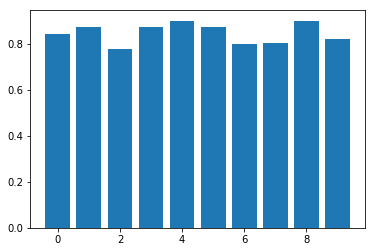

0.8467117673690601
0.8154897713726246


In [9]:
plt.bar(np.arange(len(res_df["best_acc"])), res_df["best_acc"])
plt.show()
print(np.mean(res_df["best_acc"]))
print(np.mean(res_df["final_acc"]))

In [10]:
print(np.mean(res_df["final_iter"]))

73.5


In [11]:
print(res_df["final_iter"])

0     48
1     61
2     62
3     78
4    146
5     85
6     64
7     43
8     59
9     89
Name: final_iter, dtype: int64


### Using best model checkpoint for inference

In [44]:
metrics = []
random_states = np.arange(20, 30) # important to use the same values as during training

for outer_fold, r in enumerate(random_states):
    print("Outer fold {}".format(outer_fold))

    all_scores = []
    all_preds = []
    all_labels = []
    
    train_res = training_res[outer_fold]
    model_dir = os.path.join(output_dir,"outer_{}_inner_{}_cv_fold_{}_BEST_ITERATION.h5".format(outer_fold, train_res["inner_fold_idx"], outer_fold * 5 + train_res["inner_fold_idx"]))
    model_name = train_res["params"]["model"]
    net = pick_model(model_name)
    
    net.load_state_dict(torch.load(model_dir, map_location='cpu'))
    net = net.cuda(gpu)
    net.eval()
    
    test_h5 = h5py.File(train_data_path.replace("train", "holdout") + str(r) + ".h5", 'r')

    X_test, y_test = np.array(test_h5['X']), np.array(test_h5['y'])

    # dataset overview
    print("# of patients {}, # of healthy controls {}".format(np.sum(y_test), len(y_test)-np.sum(y_test)))

    print(len(y_test))

    if zero_one_normalize:
        intensity = IntensityRescale(data_min=np.min(X_train), data_max=np.max(X_train)) # use the same min and max for all datasets
        adni_data_test= ADNIDataset(X_test, y_test, transform=transforms.Compose([intensity, ToTensor()]), mask=mask, dtype=dtype)
    else:
        adni_data_test = ADNIDataset(X_test, y_test, transform=transforms.Compose([ToTensor()]), mask=mask, dtype=dtype)

    test_h5.close()
    
    test_loader = DataLoader(
            adni_data_test, batch_size=1, num_workers=1, shuffle=False)
    
    with torch.no_grad():
        for sample in test_loader:
            img = sample["image"]
            label = sample["label"]
            img = img.to(torch.device("cuda:" + str(gpu)))
            
            output = net.forward(img)
            score = torch.sigmoid(output)
            pred = score >= 0.5
            
            all_scores.append(score.cpu().numpy().item())
            all_preds.append(pred.cpu().numpy().item())
            all_labels.append(label.numpy().item())
    
    balanced_acc = balanced_accuracy(all_labels, all_preds)
    roc_score = roc_auc_score(all_labels, all_scores)
    sens = sensitivity(all_labels, all_preds)
    spec = specificity(all_labels, all_preds)
    print("Bal. accuracy {:.3f} %".format(balanced_acc*100))
    print("ROC AUC Score {:.3f} %".format(roc_score*100))
    print("Sensitivity {:.3f} %".format(sens*100))
    print("Specificity {:.3f} %".format(spec*100))
    metrics.append([balanced_acc, roc_score, sens, spec])
# reset network to training mode6
net.train()
print("######## Final results ########")
metrics_df = pd.DataFrame(metrics, columns=["Bal Acc", "ROC AUC", "Sensitivity", "Specificity"])
print(metrics_df)
print("Balanced accuracy mean {:.3f} %".format(np.mean(metrics_df["Bal Acc"])*100))
print("ROC AUC mean {:.3f} %".format(np.mean(metrics_df["ROC AUC"])*100))
print("Sensitivity mean {:.3f} %".format(np.mean(metrics_df["Sensitivity"])*100))
print("Specificity mean {:.3f} %".format(np.mean(metrics_df["Specificity"])*100))

Outer fold 0
# of patients 65, # of healthy controls 98
163
Bal. accuracy 73.925 %
ROC AUC Score 79.246 %
Sensitivity 78.462 %
Specificity 69.388 %
Outer fold 1
# of patients 77, # of healthy controls 99
176
Bal. accuracy 84.127 %
ROC AUC Score 89.833 %
Sensitivity 84.416 %
Specificity 83.838 %
Outer fold 2
# of patients 78, # of healthy controls 100
178
Bal. accuracy 80.756 %
ROC AUC Score 88.885 %
Sensitivity 70.513 %
Specificity 91.000 %
Outer fold 3
# of patients 70, # of healthy controls 93
163
Bal. accuracy 77.673 %
ROC AUC Score 93.948 %
Sensitivity 58.571 %
Specificity 96.774 %
Outer fold 4
# of patients 73, # of healthy controls 96
169
Bal. accuracy 74.650 %
ROC AUC Score 87.985 %
Sensitivity 75.342 %
Specificity 73.958 %
Outer fold 5
# of patients 73, # of healthy controls 97
170
Bal. accuracy 80.794 %
ROC AUC Score 89.775 %
Sensitivity 78.082 %
Specificity 83.505 %
Outer fold 6
# of patients 68, # of healthy controls 90
158
Bal. accuracy 60.163 %
ROC AUC Score 67.500 %
Sensi